In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/CIRUGIA GENERAL.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=172.2, y1=135.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 485
Page 1, Q1, A: Yellow percentage: 0.0%


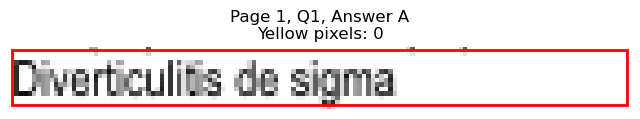

Page 1, Q1 - B: Detected box: x0=82.5, y0=135.6, x1=148.7, y1=148.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 328
Page 1, Q1, B: Yellow percentage: 0.0%


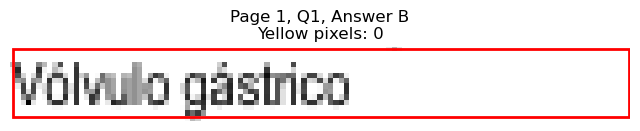

Page 1, Q1 - C: Detected box: x0=82.9, y0=149.3, x1=167.2, y1=162.0
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 438
Page 1, Q1, C: Yellow percentage: 0.0%


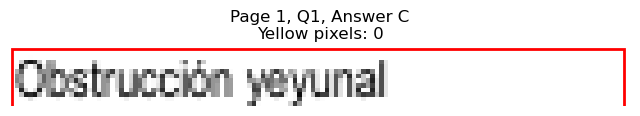

Page 1, Q1 - D: Detected box: x0=334.6, y0=123.0, x1=422.3, y1=135.7
Page 1, Q1, D: Yellow pixels: 1475
Page 1, Q1, D: Total non-white pixels: 1807
Page 1, Q1, D: Yellow percentage: 81.6%


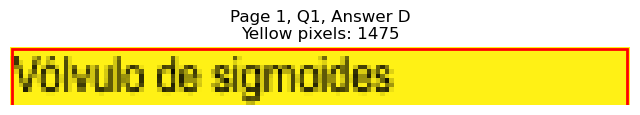

Page 1, Q1 - E: Detected box: x0=334.1, y0=136.6, x1=415.4, y1=149.2
Page 1, Q1, E: Yellow pixels: 132
Page 1, Q1, E: Total non-white pixels: 549
Page 1, Q1, E: Yellow percentage: 24.0%


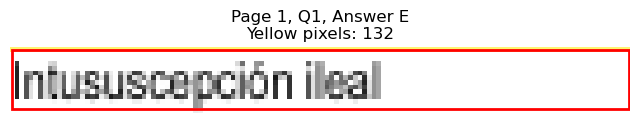


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=565.1, x1=157.3, y1=577.8
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 681
Page 1, Q2, A: Yellow percentage: 0.0%


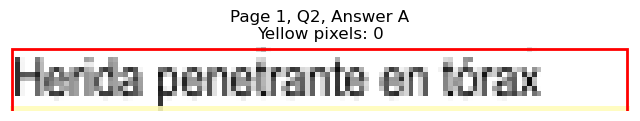

Page 1, Q2 - B: Detected box: x0=82.5, y0=200.8, x1=162.7, y1=213.4
Page 1, Q2, B: Yellow pixels: 1393
Page 1, Q2, B: Total non-white pixels: 1834
Page 1, Q2, B: Yellow percentage: 76.0%


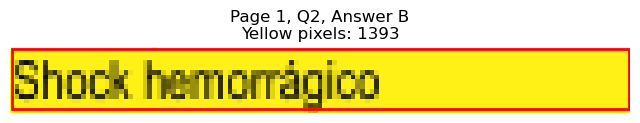

Page 1, Q2 - C: Detected box: x0=82.9, y0=214.5, x1=236.9, y1=227.1
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 770
Page 1, Q2, C: Yellow percentage: 0.0%


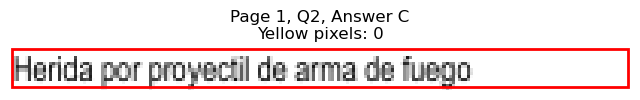

Page 1, Q2 - D: Detected box: x0=334.6, y0=188.2, x1=419.3, y1=200.8
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 438
Page 1, Q2, D: Yellow percentage: 0.0%


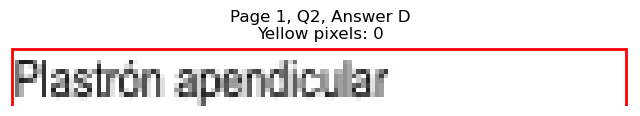

Page 1, Q2 - E: Detected box: x0=334.1, y0=201.6, x1=437.0, y1=214.3
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 511
Page 1, Q2, E: Yellow percentage: 0.0%


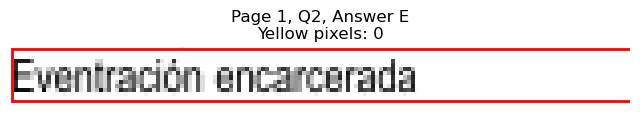


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=278.6, x1=185.3, y1=291.2
Page 1, Q3, A: Yellow pixels: 1756
Page 1, Q3, A: Total non-white pixels: 2156
Page 1, Q3, A: Yellow percentage: 81.4%


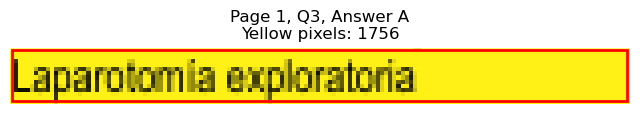

Page 1, Q3 - B: Detected box: x0=82.5, y0=292.1, x1=224.0, y1=304.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 681
Page 1, Q3, B: Yellow percentage: 0.0%


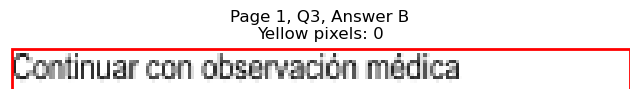

Page 1, Q3 - C: Detected box: x0=82.9, y0=305.8, x1=199.4, y1=318.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 616
Page 1, Q3, C: Yellow percentage: 0.0%


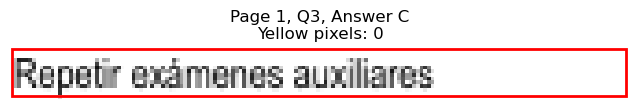

Page 1, Q3 - D: Detected box: x0=334.6, y0=278.6, x1=461.6, y1=291.2
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 679
Page 1, Q3, D: Yellow percentage: 0.0%


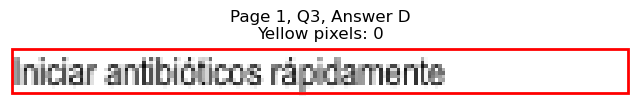

Page 1, Q3 - E: Detected box: x0=334.1, y0=292.0, x1=473.0, y1=304.7
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 718
Page 1, Q3, E: Yellow percentage: 0.0%


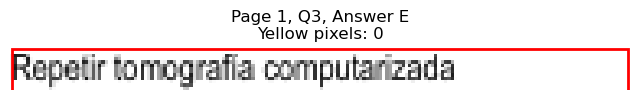


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=369.8, x1=117.6, y1=382.4
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 177
Page 1, Q4, A: Yellow percentage: 0.0%


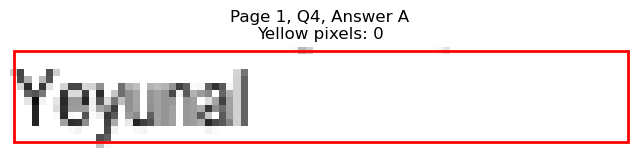

Page 1, Q4 - B: Detected box: x0=82.5, y0=382.5, x1=132.6, y1=395.1
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 243
Page 1, Q4, B: Yellow percentage: 0.0%


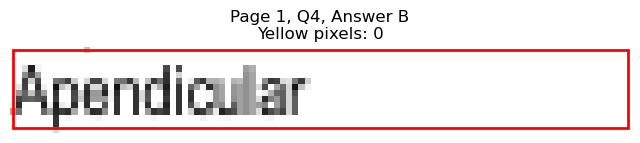

Page 1, Q4 - C: Detected box: x0=82.9, y0=396.2, x1=114.5, y1=408.8
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 155
Page 1, Q4, C: Yellow percentage: 0.0%


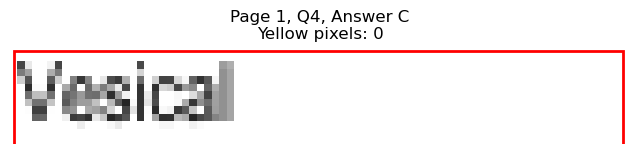

Page 1, Q4 - D: Detected box: x0=334.6, y0=369.9, x1=360.7, y1=382.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 130
Page 1, Q4, D: Yellow percentage: 0.0%


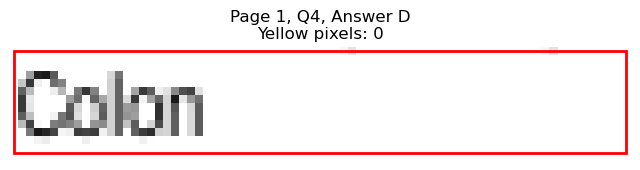

Page 1, Q4 - E: Detected box: x0=334.1, y0=383.4, x1=370.3, y1=396.1
Page 1, Q4, E: Yellow pixels: 982
Page 1, Q4, E: Total non-white pixels: 1218
Page 1, Q4, E: Yellow percentage: 80.6%


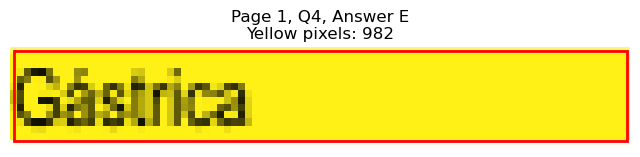


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=192.6, y0=434.9, x1=247.1, y1=447.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 380
Page 1, Q5, A: Yellow percentage: 0.0%


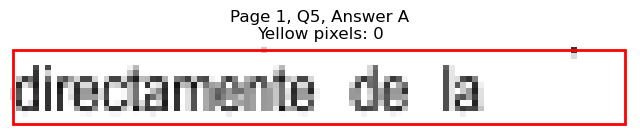

Page 1, Q5 - B: Detected box: x0=102.9, y0=460.3, x1=154.5, y1=472.9
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 441
Page 1, Q5, B: Yellow percentage: 0.0%


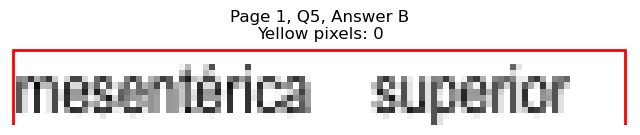

Page 1, Q5 - C: Detected box: x0=82.9, y0=487.5, x1=275.3, y1=500.2
Page 1, Q5, C: Yellow pixels: 1944
Page 1, Q5, C: Total non-white pixels: 2702
Page 1, Q5, C: Yellow percentage: 71.9%


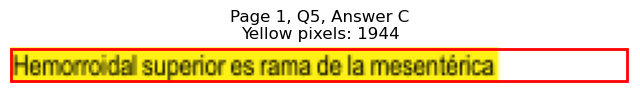

Page 1, Q5 - D: Detected box: x0=334.6, y0=435.0, x1=386.3, y1=447.7
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 473
Page 1, Q5, D: Yellow percentage: 0.0%


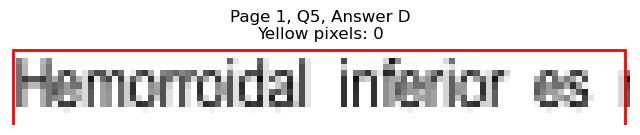

Page 1, Q5 - E: Detected box: x0=334.1, y0=462.2, x1=517.7, y1=474.8
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 885
Page 1, Q5, E: Yellow percentage: 0.0%


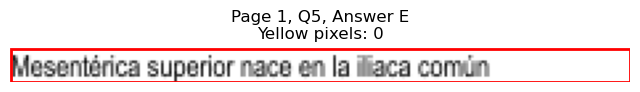


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=565.1, x1=192.3, y1=577.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 716
Page 1, Q6, A: Yellow percentage: 0.0%


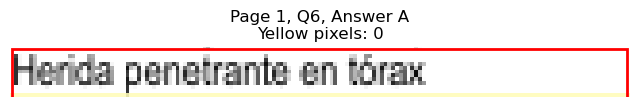

Page 1, Q6 - B: Detected box: x0=82.5, y0=577.9, x1=179.4, y1=590.5
Page 1, Q6, B: Yellow pixels: 1539
Page 1, Q6, B: Total non-white pixels: 2072
Page 1, Q6, B: Yellow percentage: 74.3%


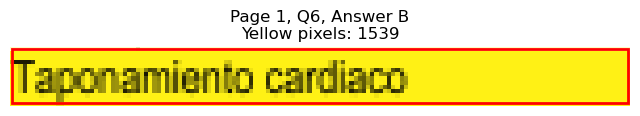

Page 1, Q6 - C: Detected box: x0=82.9, y0=591.5, x1=166.2, y1=604.2
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 406
Page 1, Q6, C: Yellow percentage: 0.0%


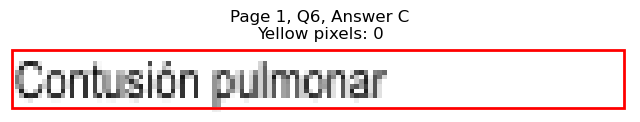

Page 1, Q6 - D: Detected box: x0=334.6, y0=565.3, x1=388.7, y1=577.9
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 258
Page 1, Q6, D: Yellow percentage: 0.0%


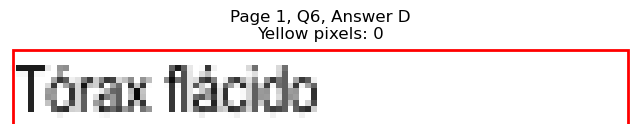

Page 1, Q6 - E: Detected box: x0=334.1, y0=578.7, x1=414.4, y1=591.4
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 404
Page 1, Q6, E: Yellow percentage: 0.0%


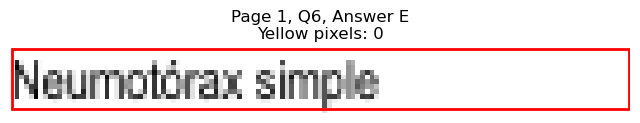


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=642.9, x1=156.7, y1=655.6
Page 1, Q7, A: Yellow pixels: 125
Page 1, Q7, A: Total non-white pixels: 500
Page 1, Q7, A: Yellow percentage: 25.0%


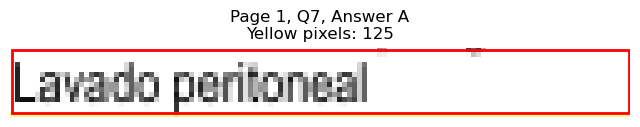

Page 1, Q7 - B: Detected box: x0=82.5, y0=655.7, x1=212.9, y1=668.3
Page 1, Q7, B: Yellow pixels: 2001
Page 1, Q7, B: Total non-white pixels: 2534
Page 1, Q7, B: Yellow percentage: 79.0%


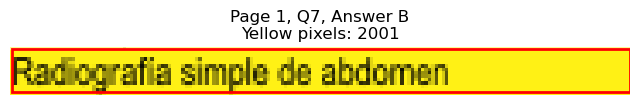

Page 1, Q7 - C: Detected box: x0=82.9, y0=669.2, x1=177.3, y1=681.9
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 496
Page 1, Q7, C: Yellow percentage: 0.0%


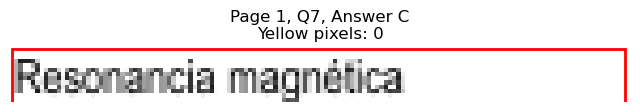

Page 1, Q7 - D: Detected box: x0=334.6, y0=643.0, x1=477.1, y1=655.7
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 724
Page 1, Q7, D: Yellow percentage: 0.0%


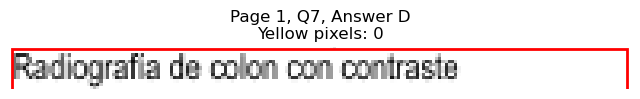

Page 1, Q7 - E: Detected box: x0=334.1, y0=656.5, x1=380.3, y1=669.2
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 242
Page 1, Q7, E: Yellow percentage: 0.0%


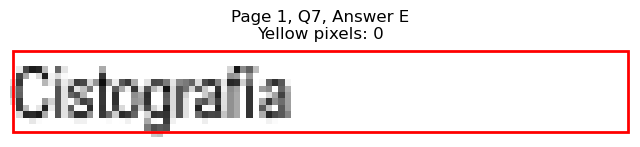


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=720.6, x1=135.1, y1=733.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 260
Page 1, Q8, A: Yellow percentage: 0.0%


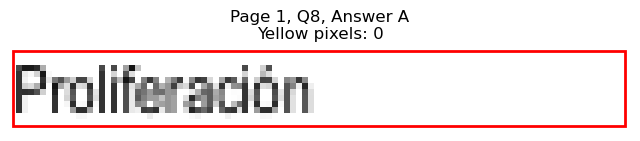

Page 1, Q8 - B: Detected box: x0=82.5, y0=733.4, x1=136.1, y1=746.1
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 269
Page 1, Q8, B: Yellow percentage: 0.0%


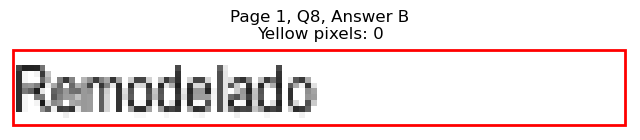

Page 1, Q8 - C: Detected box: x0=82.9, y0=747.0, x1=132.6, y1=759.6
Page 1, Q8, C: Yellow pixels: 1109
Page 1, Q8, C: Total non-white pixels: 1414
Page 1, Q8, C: Yellow percentage: 78.4%


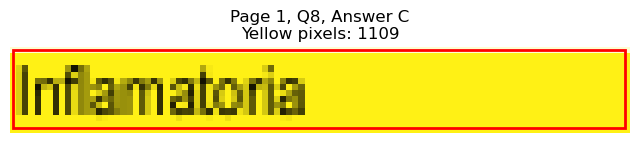

Page 1, Q8 - D: Detected box: x0=334.6, y0=720.7, x1=384.3, y1=733.4
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 267
Page 1, Q8, D: Yellow percentage: 0.0%


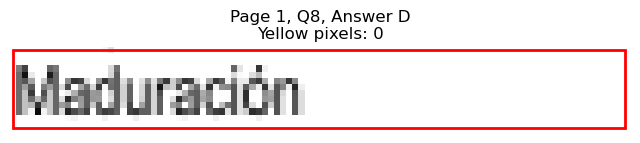

Page 1, Q8 - E: Detected box: x0=334.1, y0=734.2, x1=390.4, y1=746.9
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 302
Page 1, Q8, E: Yellow percentage: 0.0%


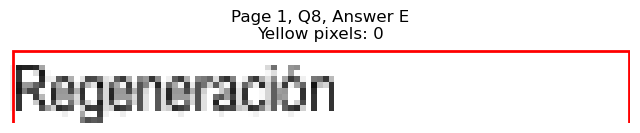


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=97.8, x1=171.7, y1=110.5
Page 2, Q1, A: Yellow pixels: 1481
Page 2, Q1, A: Total non-white pixels: 1960
Page 2, Q1, A: Yellow percentage: 75.6%


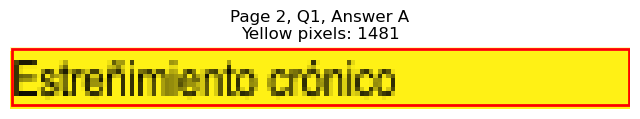

Page 2, Q1 - B: Detected box: x0=82.5, y0=111.4, x1=166.7, y1=124.0
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 432
Page 2, Q1, B: Yellow percentage: 0.0%


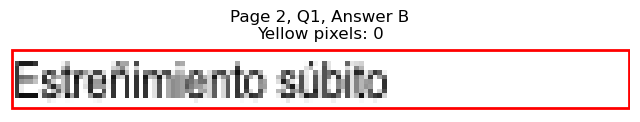

Page 2, Q1 - C: Detected box: x0=82.9, y0=125.1, x1=176.8, y1=137.7
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 452
Page 2, Q1, C: Yellow percentage: 0.0%


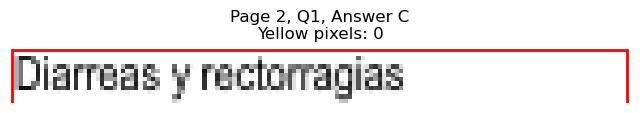

Page 2, Q1 - D: Detected box: x0=334.6, y0=97.8, x1=424.9, y1=110.5
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 451
Page 2, Q1, D: Yellow percentage: 0.0%


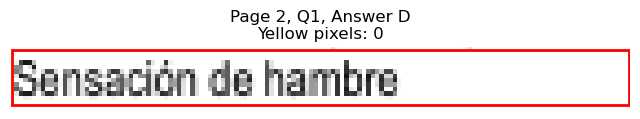

Page 2, Q1 - E: Detected box: x0=334.1, y0=111.3, x1=419.9, y1=123.9
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 412
Page 2, Q1, E: Yellow percentage: 0.0%


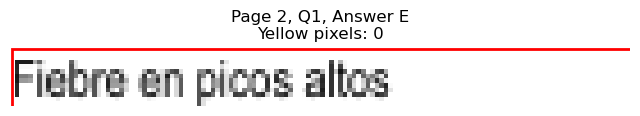


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=176.4, x1=196.3, y1=189.1
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 537
Page 2, Q2, A: Yellow percentage: 0.0%


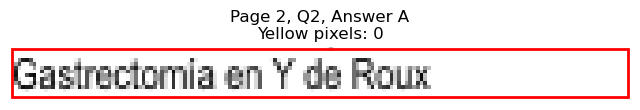

Page 2, Q2 - B: Detected box: x0=82.5, y0=189.1, x1=160.2, y1=201.8
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 387
Page 2, Q2, B: Yellow percentage: 0.0%


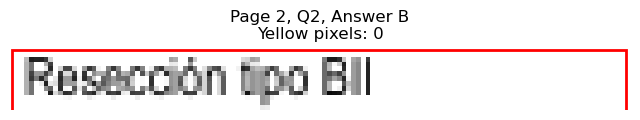

Page 2, Q2 - C: Detected box: x0=82.9, y0=202.8, x1=198.7, y1=215.5
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 626
Page 2, Q2, C: Yellow percentage: 0.0%


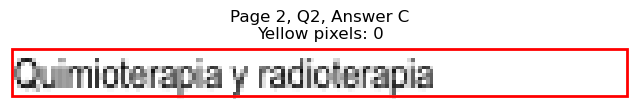

Page 2, Q2 - D: Detected box: x0=334.6, y0=176.5, x1=410.8, y1=189.2
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 372
Page 2, Q2, D: Yellow percentage: 0.0%


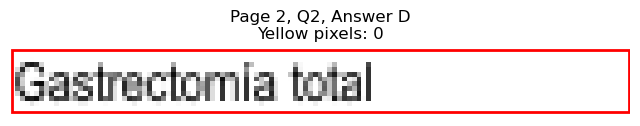

Page 2, Q2 - E: Detected box: x0=334.1, y0=190.1, x1=481.2, y1=202.8
Page 2, Q2, E: Yellow pixels: 1931
Page 2, Q2, E: Total non-white pixels: 2496
Page 2, Q2, E: Yellow percentage: 77.4%


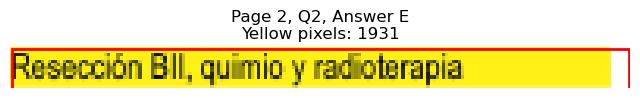


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=266.8, x1=146.7, y1=279.5
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 332
Page 2, Q3, A: Yellow percentage: 0.0%


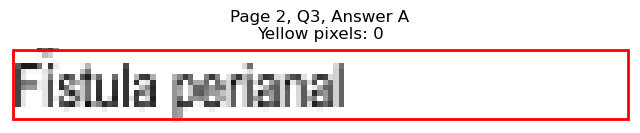

Page 2, Q3 - B: Detected box: x0=82.5, y0=279.5, x1=141.6, y1=292.2
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 291
Page 2, Q3, B: Yellow percentage: 0.0%


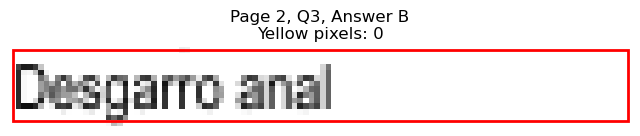

Page 2, Q3 - C: Detected box: x0=82.9, y0=293.2, x1=154.7, y1=305.9
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 376
Page 2, Q3, C: Yellow percentage: 0.0%


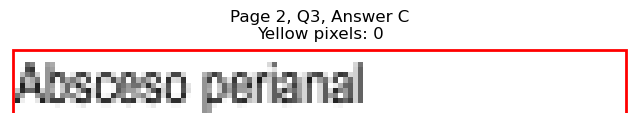

Page 2, Q3 - D: Detected box: x0=334.6, y0=266.9, x1=418.9, y1=279.6
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 442
Page 2, Q3, D: Yellow percentage: 0.0%


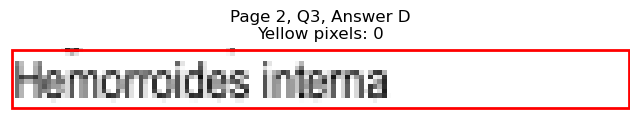

Page 2, Q3 - E: Detected box: x0=334.1, y0=280.4, x1=381.3, y1=293.0
Page 2, Q3, E: Yellow pixels: 1111
Page 2, Q3, E: Total non-white pixels: 1372
Page 2, Q3, E: Yellow percentage: 81.0%


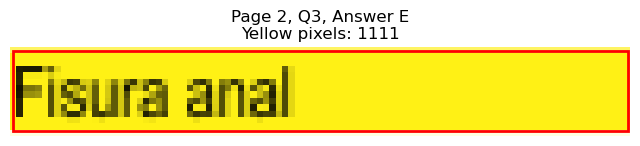


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=357.2, x1=208.8, y1=369.8
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 650
Page 2, Q4, A: Yellow percentage: 0.0%


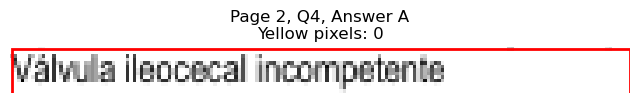

Page 2, Q4 - B: Detected box: x0=82.5, y0=369.9, x1=247.0, y1=382.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 822
Page 2, Q4, B: Yellow percentage: 0.0%


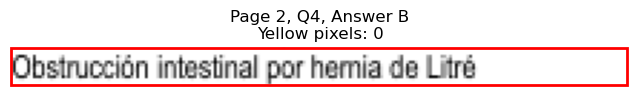

Page 2, Q4 - C: Detected box: x0=82.9, y0=383.6, x1=209.9, y1=396.2
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 665
Page 2, Q4, C: Yellow percentage: 0.0%


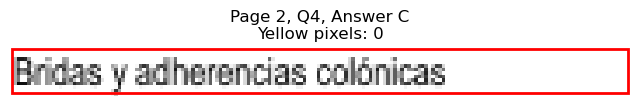

Page 2, Q4 - D: Detected box: x0=334.6, y0=357.3, x1=481.1, y1=369.9
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 697
Page 2, Q4, D: Yellow percentage: 0.0%


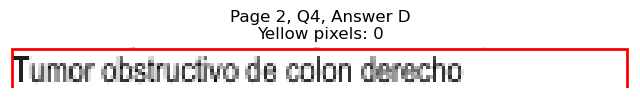

Page 2, Q4 - E: Detected box: x0=334.1, y0=370.7, x1=496.2, y1=383.4
Page 2, Q4, E: Yellow pixels: 1817
Page 2, Q4, E: Total non-white pixels: 2688
Page 2, Q4, E: Yellow percentage: 67.6%


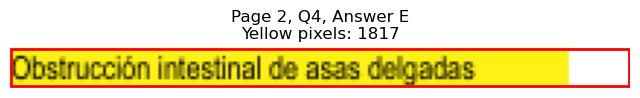


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=447.5, x1=182.8, y1=460.2
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 489
Page 2, Q5, A: Yellow percentage: 0.0%


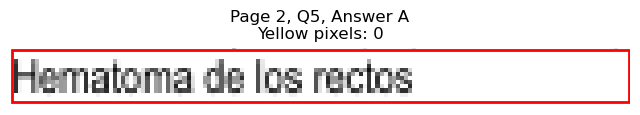

Page 2, Q5 - B: Detected box: x0=82.5, y0=460.3, x1=169.2, y1=472.9
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 447
Page 2, Q5, B: Yellow percentage: 0.0%


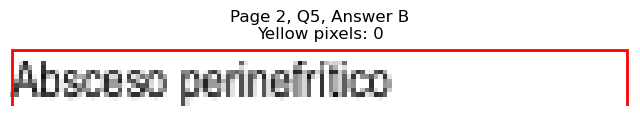

Page 2, Q5 - C: Detected box: x0=82.9, y0=473.9, x1=167.2, y1=486.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 465
Page 2, Q5, C: Yellow percentage: 0.0%


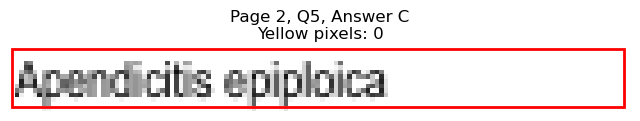

Page 2, Q5 - D: Detected box: x0=334.6, y0=447.6, x1=423.4, y1=460.3
Page 2, Q5, D: Yellow pixels: 1597
Page 2, Q5, D: Total non-white pixels: 1960
Page 2, Q5, D: Yellow percentage: 81.5%


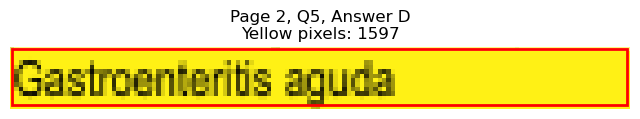

Page 2, Q5 - E: Detected box: x0=334.1, y0=461.1, x1=407.9, y1=473.8
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 394
Page 2, Q5, E: Yellow percentage: 0.0%


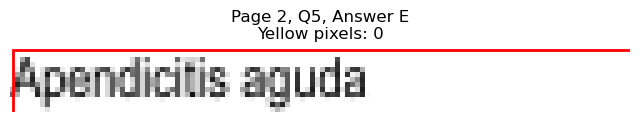


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=512.6, x1=115.6, y1=525.2
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 156
Page 2, Q6, A: Yellow percentage: 0.0%


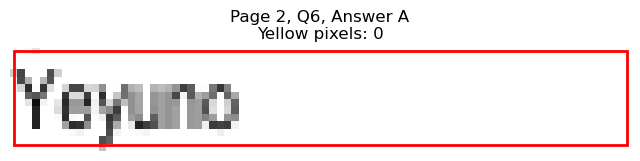

Page 2, Q6 - B: Detected box: x0=82.5, y0=525.4, x1=139.1, y1=538.1
Page 2, Q6, B: Yellow pixels: 1277
Page 2, Q6, B: Total non-white pixels: 1512
Page 2, Q6, B: Yellow percentage: 84.5%


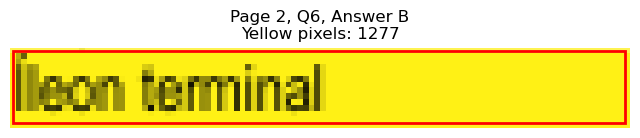

Page 2, Q6 - C: Detected box: x0=82.9, y0=539.0, x1=144.1, y1=551.6
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 290
Page 2, Q6, C: Yellow percentage: 0.0%


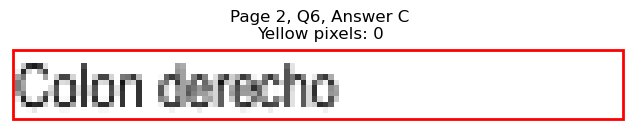

Page 2, Q6 - D: Detected box: x0=334.6, y0=512.7, x1=373.7, y1=525.4
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 197
Page 2, Q6, D: Yellow percentage: 0.0%


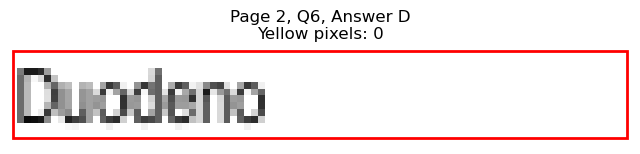

Page 2, Q6 - E: Detected box: x0=334.1, y0=526.3, x1=392.8, y1=538.9
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 287
Page 2, Q6, E: Yellow percentage: 0.0%


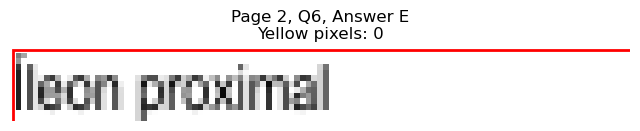


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=590.3, x1=164.7, y1=603.0
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 446
Page 2, Q7, A: Yellow percentage: 0.0%


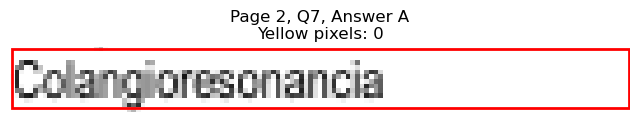

Page 2, Q7 - B: Detected box: x0=82.5, y0=603.1, x1=167.8, y1=615.7
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 460
Page 2, Q7, B: Yellow percentage: 0.0%


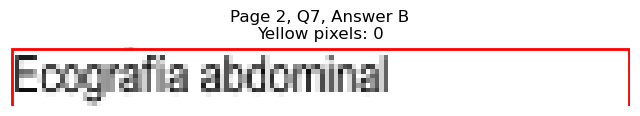

Page 2, Q7 - C: Detected box: x0=82.9, y0=616.7, x1=213.4, y1=629.4
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 663
Page 2, Q7, C: Yellow percentage: 0.0%


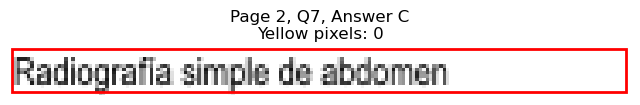

Page 2, Q7 - D: Detected box: x0=334.6, y0=590.5, x1=444.9, y1=603.1
Page 2, Q7, D: Yellow pixels: 1834
Page 2, Q7, D: Total non-white pixels: 2254
Page 2, Q7, D: Yellow percentage: 81.4%


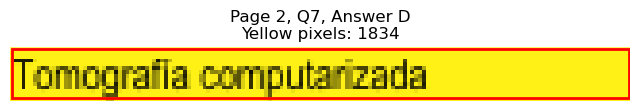

Page 2, Q7 - E: Detected box: x0=334.1, y0=604.0, x1=398.8, y1=616.7
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 449
Page 2, Q7, E: Yellow percentage: 0.0%


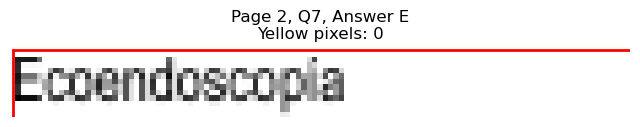


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=668.1, x1=255.5, y1=680.8
Page 2, Q8, A: Yellow pixels: 1
Page 2, Q8, A: Total non-white pixels: 1031
Page 2, Q8, A: Yellow percentage: 0.1%


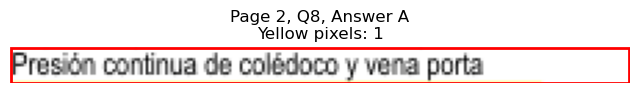

Page 2, Q8 - B: Detected box: x0=82.5, y0=680.9, x1=191.3, y1=693.5
Page 2, Q8, B: Yellow pixels: 1640
Page 2, Q8, B: Total non-white pixels: 2240
Page 2, Q8, B: Yellow percentage: 73.2%


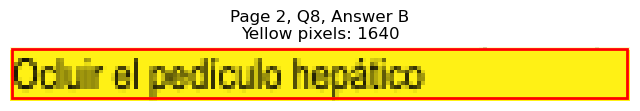

Page 2, Q8 - C: Detected box: x0=82.9, y0=694.5, x1=236.9, y1=707.2
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 728
Page 2, Q8, C: Yellow percentage: 0.0%


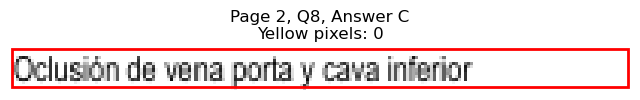

Page 2, Q8 - D: Detected box: x0=334.6, y0=668.3, x1=472.1, y1=680.9
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 693
Page 2, Q8, D: Yellow percentage: 0.0%


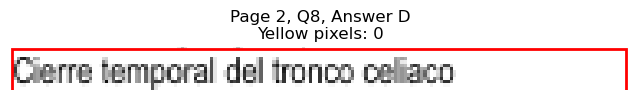

Page 2, Q8 - E: Detected box: x0=334.1, y0=681.7, x1=490.7, y1=694.4
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 770
Page 2, Q8, E: Yellow percentage: 0.0%


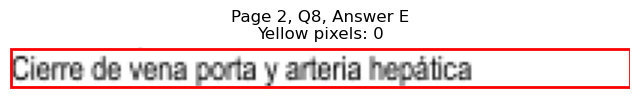


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.5, y0=745.9, x1=180.4, y1=758.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 517
Page 2, Q9, A: Yellow percentage: 0.0%


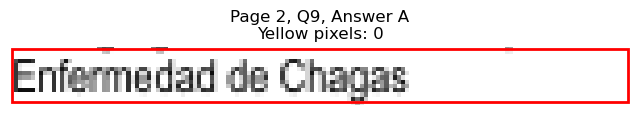

Page 2, Q9 - B: Detected box: x0=82.5, y0=758.6, x1=170.8, y1=771.3
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 451
Page 2, Q9, B: Yellow percentage: 0.0%


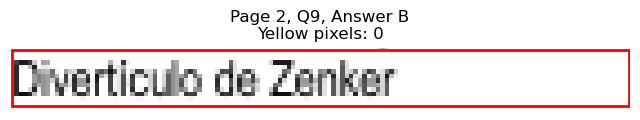

Page 2, Q9 - C: Detected box: x0=82.9, y0=772.2, x1=160.7, y1=784.8
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 417
Page 2, Q9, C: Yellow percentage: 0.0%


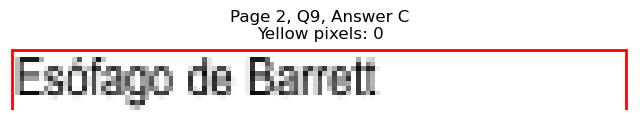

Page 2, Q9 - D: Detected box: x0=334.6, y0=746.0, x1=418.9, y1=758.7
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 445
Page 2, Q9, D: Yellow percentage: 0.0%


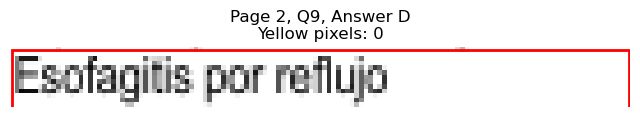

Page 2, Q9 - E: Detected box: x0=334.1, y0=759.4, x1=416.9, y1=772.1
Page 2, Q9, E: Yellow pixels: 1411
Page 2, Q9, E: Total non-white pixels: 1862
Page 2, Q9, E: Yellow percentage: 75.8%


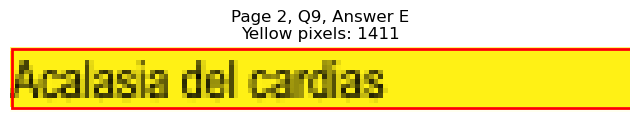


Page 2, Q9 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=123.0, x1=221.3, y1=135.7
Page 3, Q1, A: Yellow pixels: 1924
Page 3, Q1, A: Total non-white pixels: 2470
Page 3, Q1, A: Yellow percentage: 77.9%


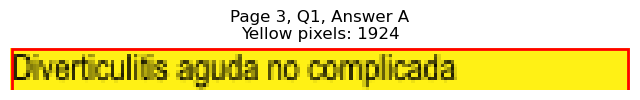

Page 3, Q1 - B: Detected box: x0=82.5, y0=136.7, x1=189.7, y1=149.4
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 597
Page 3, Q1, B: Yellow percentage: 0.0%


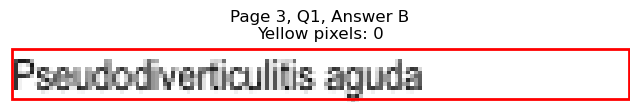

Page 3, Q1 - C: Detected box: x0=82.9, y0=150.3, x1=160.8, y1=162.9
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 396
Page 3, Q1, C: Yellow percentage: 0.0%


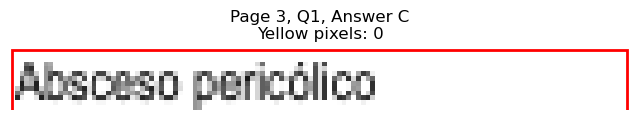

Page 3, Q1 - D: Detected box: x0=334.6, y0=123.0, x1=428.9, y1=135.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 514
Page 3, Q1, D: Yellow percentage: 0.0%


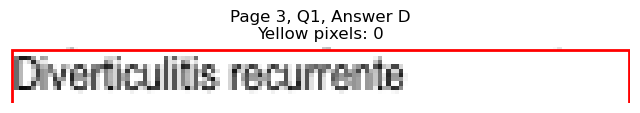

Page 3, Q1 - E: Detected box: x0=334.1, y0=136.6, x1=416.3, y1=149.2
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 420
Page 3, Q1, E: Yellow percentage: 0.0%


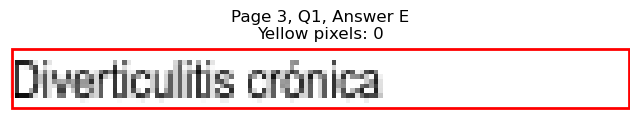


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=201.6, x1=150.6, y1=214.3
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 338
Page 3, Q2, A: Yellow percentage: 0.0%


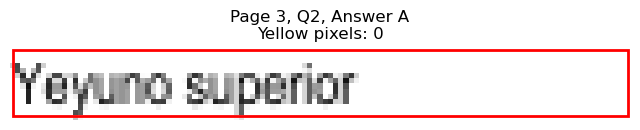

Page 3, Q2 - B: Detected box: x0=82.5, y0=214.5, x1=200.8, y1=227.1
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 580
Page 3, Q2, B: Yellow percentage: 0.0%


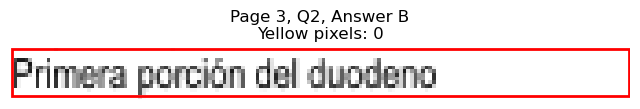

Page 3, Q2 - C: Detected box: x0=82.9, y0=228.0, x1=152.7, y1=240.7
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 345
Page 3, Q2, C: Yellow percentage: 0.0%


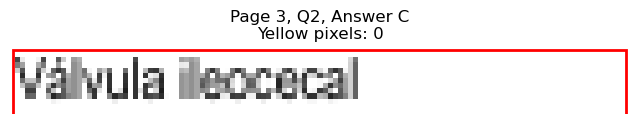

Page 3, Q2 - D: Detected box: x0=334.6, y0=201.7, x1=391.3, y1=214.4
Page 3, Q2, D: Yellow pixels: 1176
Page 3, Q2, D: Total non-white pixels: 1512
Page 3, Q2, D: Yellow percentage: 77.8%


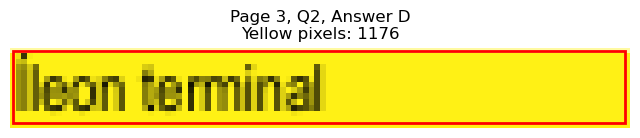

Page 3, Q2 - E: Detected box: x0=334.1, y0=215.3, x1=452.0, y1=228.0
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 719
Page 3, Q2, E: Yellow percentage: 0.0%


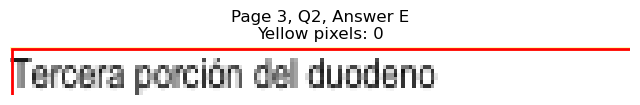


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=266.8, x1=213.4, y1=279.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 669
Page 3, Q3, A: Yellow percentage: 0.0%


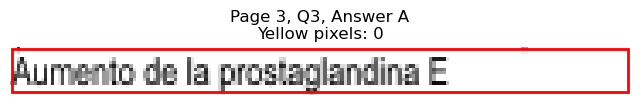

Page 3, Q3 - B: Detected box: x0=82.5, y0=279.5, x1=210.4, y1=292.2
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 651
Page 3, Q3, B: Yellow percentage: 0.0%


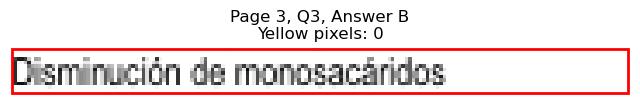

Page 3, Q3 - C: Detected box: x0=82.9, y0=293.2, x1=226.5, y1=305.9
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 734
Page 3, Q3, C: Yellow percentage: 0.0%


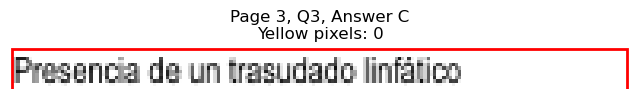

Page 3, Q3 - D: Detected box: x0=334.6, y0=266.9, x1=460.5, y1=279.6
Page 3, Q3, D: Yellow pixels: 1778
Page 3, Q3, D: Total non-white pixels: 2478
Page 3, Q3, D: Yellow percentage: 71.8%


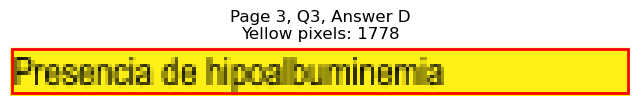

Page 3, Q3 - E: Detected box: x0=334.1, y0=280.4, x1=463.0, y1=293.0
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 817
Page 3, Q3, E: Yellow percentage: 0.0%


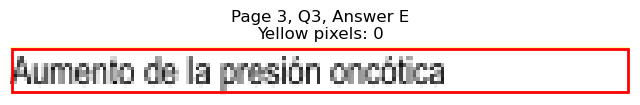


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=332.0, x1=145.1, y1=344.6
Page 3, Q4, A: Yellow pixels: 114
Page 3, Q4, A: Total non-white pixels: 444
Page 3, Q4, A: Yellow percentage: 25.7%


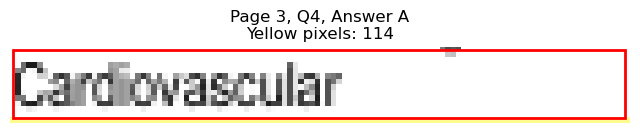

Page 3, Q4 - B: Detected box: x0=82.5, y0=344.7, x1=133.7, y1=357.3
Page 3, Q4, B: Yellow pixels: 1221
Page 3, Q4, B: Total non-white pixels: 1428
Page 3, Q4, B: Yellow percentage: 85.5%


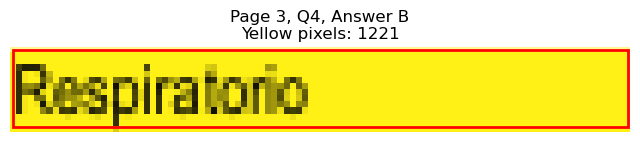

Page 3, Q4 - C: Detected box: x0=82.9, y0=358.2, x1=151.6, y1=370.9
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 347
Page 3, Q4, C: Yellow percentage: 0.0%


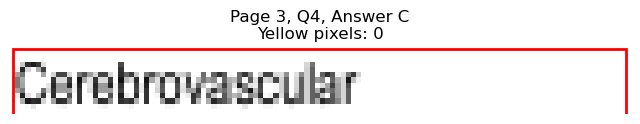

Page 3, Q4 - D: Detected box: x0=334.6, y0=332.1, x1=381.8, y1=344.7
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 251
Page 3, Q4, D: Yellow percentage: 0.0%


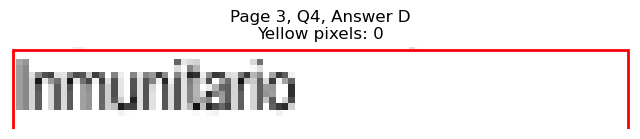

Page 3, Q4 - E: Detected box: x0=334.1, y0=345.5, x1=360.2, y1=358.2
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 136
Page 3, Q4, E: Yellow percentage: 0.0%


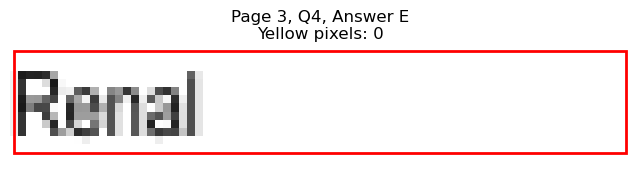


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=409.6, x1=176.8, y1=422.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 487
Page 3, Q5, A: Yellow percentage: 0.0%


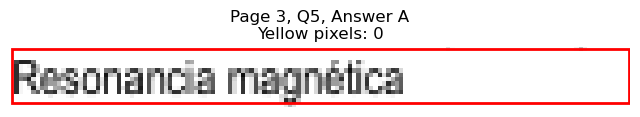

Page 3, Q5 - B: Detected box: x0=82.5, y0=422.3, x1=212.9, y1=435.0
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 691
Page 3, Q5, B: Yellow percentage: 0.0%


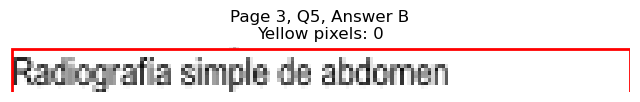

Page 3, Q5 - C: Detected box: x0=82.9, y0=436.0, x1=175.7, y1=448.7
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 481
Page 3, Q5, C: Yellow percentage: 0.0%


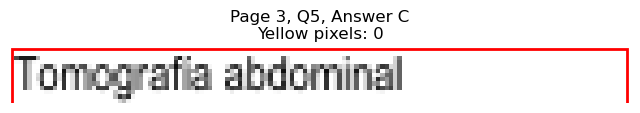

Page 3, Q5 - D: Detected box: x0=334.6, y0=409.7, x1=428.9, y1=422.4
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 503
Page 3, Q5, D: Yellow percentage: 0.0%


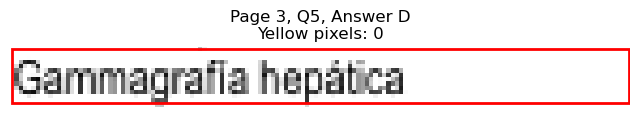

Page 3, Q5 - E: Detected box: x0=334.1, y0=423.3, x1=419.5, y1=435.9
Page 3, Q5, E: Yellow pixels: 1423
Page 3, Q5, E: Total non-white pixels: 1768
Page 3, Q5, E: Yellow percentage: 80.5%


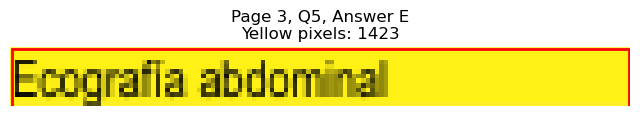


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=500.0, x1=161.2, y1=512.6
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 406
Page 3, Q6, A: Yellow percentage: 0.0%


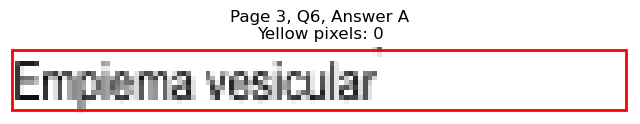

Page 3, Q6 - B: Detected box: x0=82.5, y0=512.7, x1=159.7, y1=525.4
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 399
Page 3, Q6, B: Yellow percentage: 0.0%


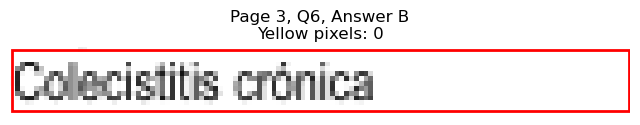

Page 3, Q6 - C: Detected box: x0=82.9, y0=526.4, x1=154.7, y1=539.0
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 355
Page 3, Q6, C: Yellow percentage: 0.0%


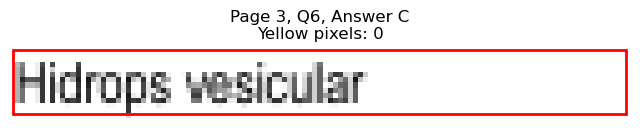

Page 3, Q6 - D: Detected box: x0=334.6, y0=500.1, x1=456.1, y1=512.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 617
Page 3, Q6, D: Yellow percentage: 0.0%


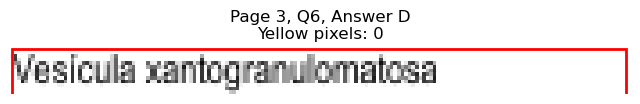

Page 3, Q6 - E: Detected box: x0=334.1, y0=513.7, x1=425.9, y1=526.3
Page 3, Q6, E: Yellow pixels: 1364
Page 3, Q6, E: Total non-white pixels: 1988
Page 3, Q6, E: Yellow percentage: 68.6%


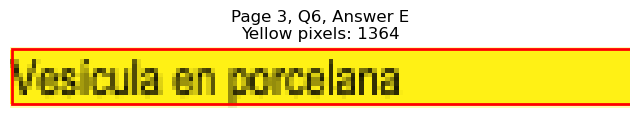


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=590.5, x1=160.7, y1=603.1
Page 3, Q7, A: Yellow pixels: 1467
Page 3, Q7, A: Total non-white pixels: 1806
Page 3, Q7, A: Yellow percentage: 81.2%


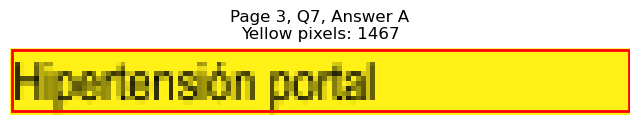

Page 3, Q7 - B: Detected box: x0=82.5, y0=604.1, x1=167.7, y1=616.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 444
Page 3, Q7, B: Yellow percentage: 0.0%


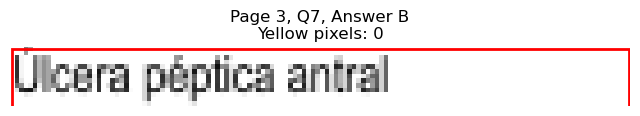

Page 3, Q7 - C: Detected box: x0=82.9, y0=617.7, x1=160.2, y1=630.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 348
Page 3, Q7, C: Yellow percentage: 0.0%


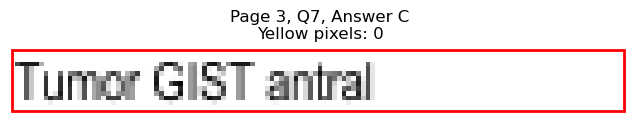

Page 3, Q7 - D: Detected box: x0=334.6, y0=590.5, x1=402.8, y1=603.1
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 351
Page 3, Q7, D: Yellow percentage: 0.0%


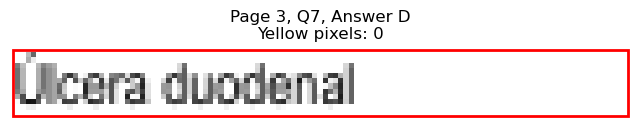

Page 3, Q7 - E: Detected box: x0=334.1, y0=604.0, x1=446.9, y1=616.7
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 572
Page 3, Q7, E: Yellow percentage: 0.0%


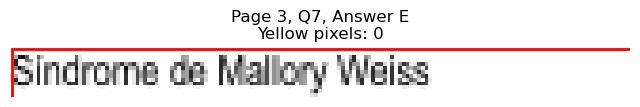


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.5, y0=656.5, x1=124.6, y1=669.2
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 206
Page 3, Q8, A: Yellow percentage: 0.0%


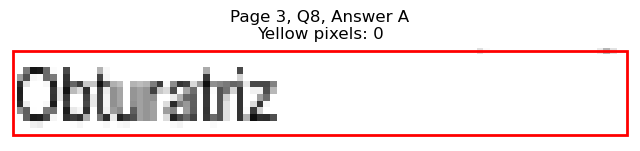

Page 3, Q8 - B: Detected box: x0=82.5, y0=669.2, x1=106.6, y1=681.9
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 128
Page 3, Q8, B: Yellow percentage: 0.0%


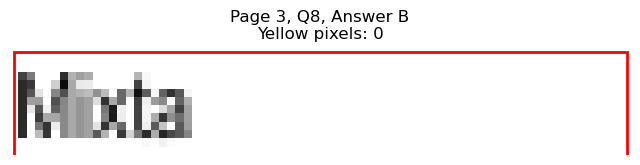

Page 3, Q8 - C: Detected box: x0=82.9, y0=682.9, x1=120.0, y1=695.6
Page 3, Q8, C: Yellow pixels: 1034
Page 3, Q8, C: Total non-white pixels: 1246
Page 3, Q8, C: Yellow percentage: 83.0%


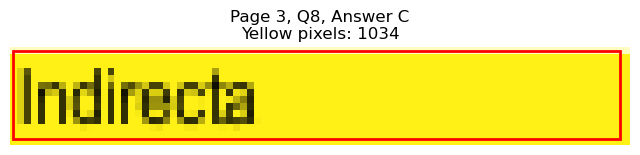

Page 3, Q8 - D: Detected box: x0=334.6, y0=656.6, x1=370.3, y1=669.3
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 178
Page 3, Q8, D: Yellow percentage: 0.0%


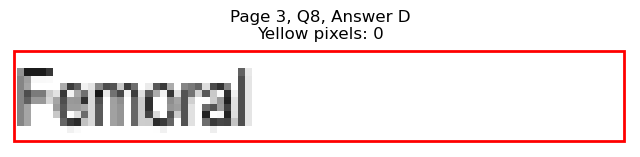

Page 3, Q8 - E: Detected box: x0=334.1, y0=670.2, x1=354.7, y1=682.8
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 110
Page 3, Q8, E: Yellow percentage: 0.0%


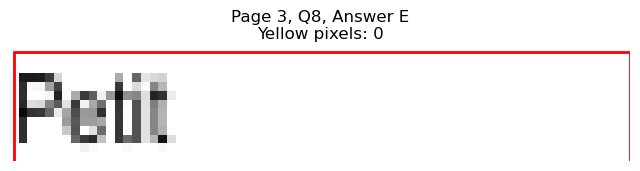


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=135.6, x1=159.7, y1=148.3
Page 4, Q1, A: Yellow pixels: 1482
Page 4, Q1, A: Total non-white pixels: 1792
Page 4, Q1, A: Yellow percentage: 82.7%


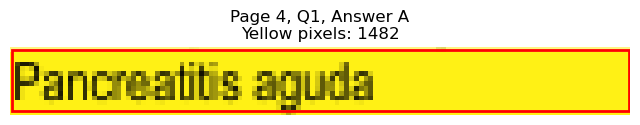

Page 4, Q1 - B: Detected box: x0=82.5, y0=149.3, x1=164.7, y1=162.0
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 408
Page 4, Q1, B: Yellow percentage: 0.0%


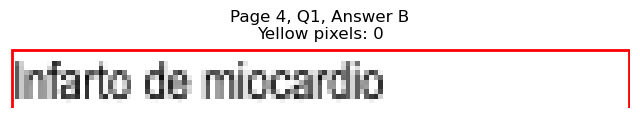

Page 4, Q1 - C: Detected box: x0=82.9, y0=163.0, x1=171.7, y1=175.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 486
Page 4, Q1, C: Yellow percentage: 0.0%


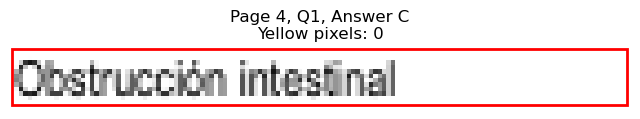

Page 4, Q1 - D: Detected box: x0=334.6, y0=135.6, x1=394.9, y1=148.3
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 316
Page 4, Q1, D: Yellow percentage: 0.0%


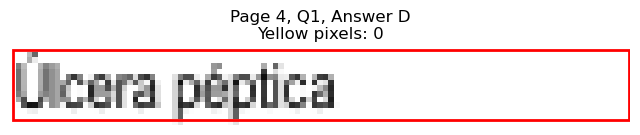

Page 4, Q1 - E: Detected box: x0=334.1, y0=149.2, x1=384.8, y1=161.8
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 274
Page 4, Q1, E: Yellow percentage: 0.0%


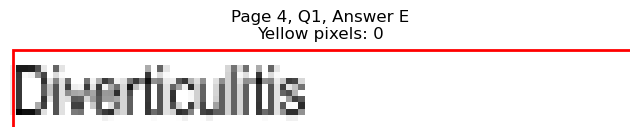


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=239.5, x1=165.3, y1=252.2
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 433
Page 4, Q2, A: Yellow percentage: 0.0%


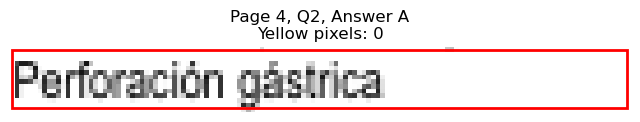

Page 4, Q2 - B: Detected box: x0=82.5, y0=252.3, x1=164.2, y1=264.9
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 420
Page 4, Q2, B: Yellow percentage: 0.0%


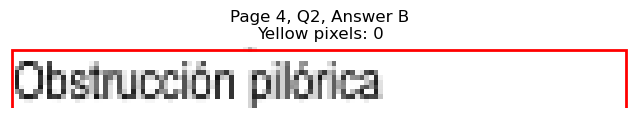

Page 4, Q2 - C: Detected box: x0=82.9, y0=265.9, x1=151.7, y1=278.6
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 327
Page 4, Q2, C: Yellow percentage: 0.0%


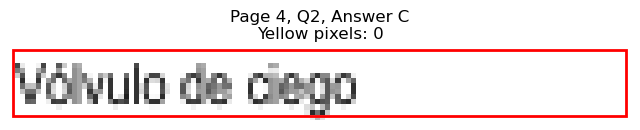

Page 4, Q2 - D: Detected box: x0=334.6, y0=239.7, x1=425.3, y1=252.3
Page 4, Q2, D: Yellow pixels: 1630
Page 4, Q2, D: Total non-white pixels: 1988
Page 4, Q2, D: Yellow percentage: 82.0%


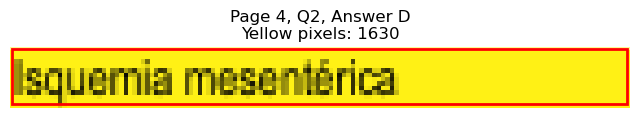

Page 4, Q2 - E: Detected box: x0=334.1, y0=253.1, x1=417.4, y1=265.8
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 560
Page 4, Q2, E: Yellow percentage: 0.0%


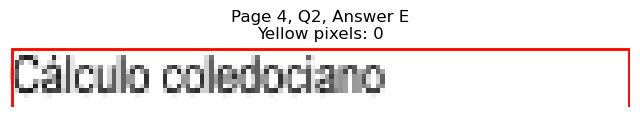


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=317.3, x1=118.6, y1=330.0
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 171
Page 4, Q3, A: Yellow percentage: 0.0%


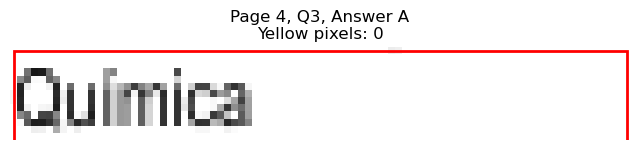

Page 4, Q3 - B: Detected box: x0=82.5, y0=330.0, x1=127.1, y1=342.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 226
Page 4, Q3, B: Yellow percentage: 0.0%


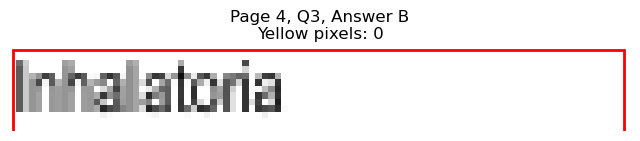

Page 4, Q3 - C: Detected box: x0=82.9, y0=343.6, x1=118.0, y1=356.3
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 165
Page 4, Q3, C: Yellow percentage: 0.0%


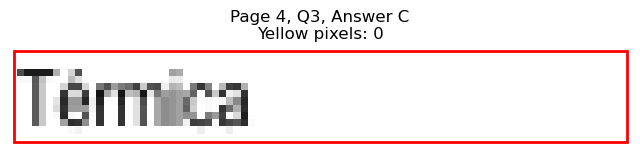

Page 4, Q3 - D: Detected box: x0=334.6, y0=317.4, x1=358.1, y1=330.1
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 120
Page 4, Q3, D: Yellow percentage: 0.0%


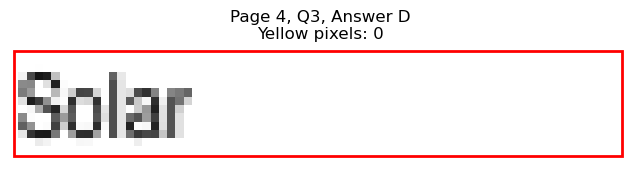

Page 4, Q3 - E: Detected box: x0=334.1, y0=330.9, x1=371.2, y1=343.5
Page 4, Q3, E: Yellow pixels: 984
Page 4, Q3, E: Total non-white pixels: 1232
Page 4, Q3, E: Yellow percentage: 79.9%


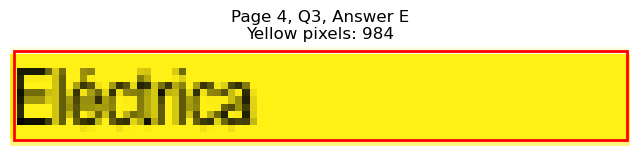


Page 4, Q3 - Selected Answer: E (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=407.7, x1=169.7, y1=420.3
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 441
Page 4, Q4, A: Yellow percentage: 0.0%


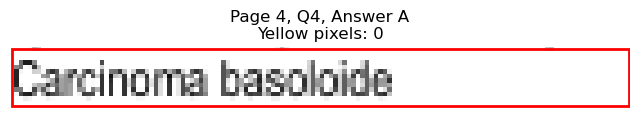

Page 4, Q4 - B: Detected box: x0=82.5, y0=420.4, x1=127.1, y1=433.1
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 228
Page 4, Q4, B: Yellow percentage: 0.0%


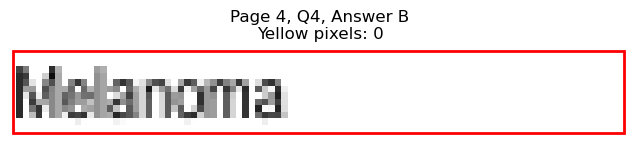

Page 4, Q4 - C: Detected box: x0=82.9, y0=434.0, x1=172.7, y1=446.6
Page 4, Q4, C: Yellow pixels: 1493
Page 4, Q4, C: Total non-white pixels: 1974
Page 4, Q4, C: Yellow percentage: 75.6%


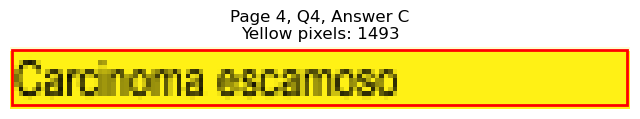

Page 4, Q4 - D: Detected box: x0=334.6, y0=407.8, x1=432.9, y1=420.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 498
Page 4, Q4, D: Yellow percentage: 0.0%


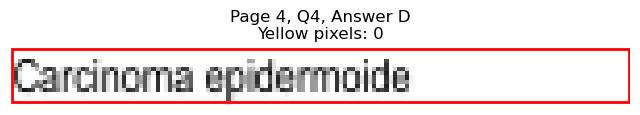

Page 4, Q4 - E: Detected box: x0=334.1, y0=421.2, x1=404.3, y1=433.9
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 359
Page 4, Q4, E: Yellow percentage: 0.0%


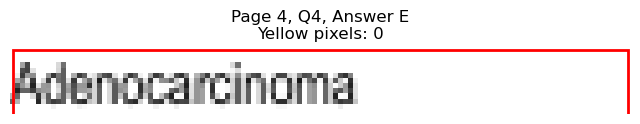


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=498.1, x1=161.7, y1=510.7
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 392
Page 4, Q5, A: Yellow percentage: 0.0%


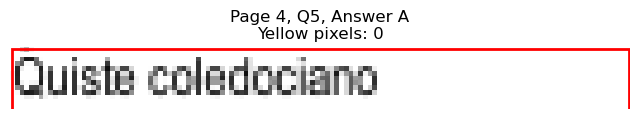

Page 4, Q5 - B: Detected box: x0=82.5, y0=510.8, x1=128.1, y1=523.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 228
Page 4, Q5, B: Yellow percentage: 0.0%


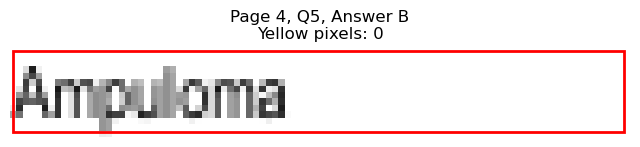

Page 4, Q5 - C: Detected box: x0=82.9, y0=524.3, x1=175.2, y1=537.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 485
Page 4, Q5, C: Yellow percentage: 0.0%


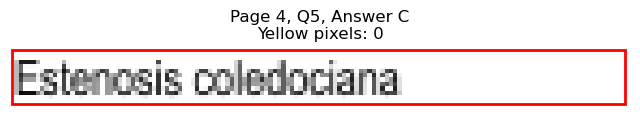

Page 4, Q5 - D: Detected box: x0=334.6, y0=498.2, x1=415.9, y1=510.8
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 406
Page 4, Q5, D: Yellow percentage: 0.0%


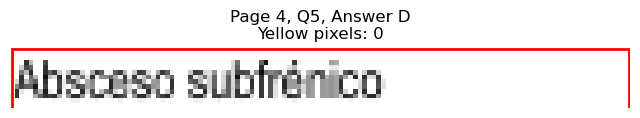

Page 4, Q5 - E: Detected box: x0=334.1, y0=511.6, x1=433.4, y1=524.3
Page 4, Q5, E: Yellow pixels: 1385
Page 4, Q5, E: Total non-white pixels: 2100
Page 4, Q5, E: Yellow percentage: 66.0%


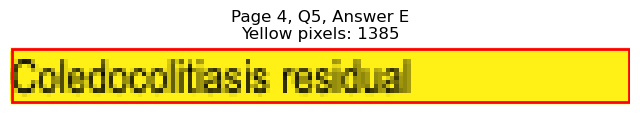


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=588.4, x1=187.8, y1=601.1
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 552
Page 4, Q6, A: Yellow percentage: 0.0%


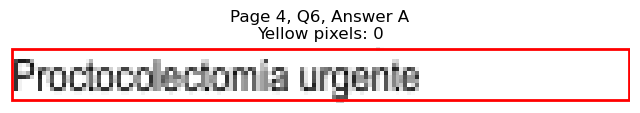

Page 4, Q6 - B: Detected box: x0=82.5, y0=601.1, x1=258.0, y1=613.8
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 900
Page 4, Q6, B: Yellow percentage: 0.0%


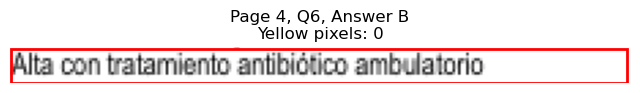

Page 4, Q6 - C: Detected box: x0=82.9, y0=614.7, x1=212.9, y1=627.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 676
Page 4, Q6, C: Yellow percentage: 0.0%


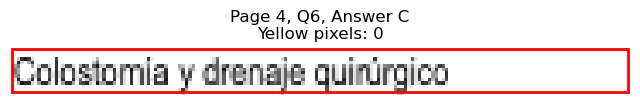

Page 4, Q6 - D: Detected box: x0=334.6, y0=588.5, x1=475.1, y1=601.2
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 717
Page 4, Q6, D: Yellow percentage: 0.0%


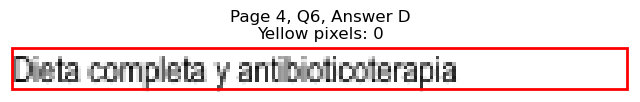

Page 4, Q6 - E: Detected box: x0=334.1, y0=602.0, x1=503.7, y1=614.6
Page 4, Q6, E: Yellow pixels: 1824
Page 4, Q6, E: Total non-white pixels: 2688
Page 4, Q6, E: Yellow percentage: 67.9%


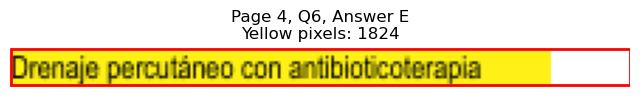


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=666.1, x1=157.8, y1=678.8
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 540
Page 4, Q7, A: Yellow percentage: 0.0%


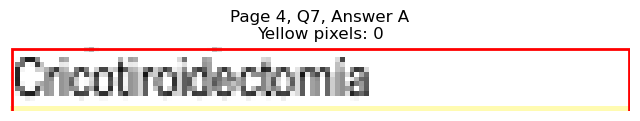

Page 4, Q7 - B: Detected box: x0=82.5, y0=678.8, x1=145.7, y1=691.5
Page 4, Q7, B: Yellow pixels: 1222
Page 4, Q7, B: Total non-white pixels: 1596
Page 4, Q7, B: Yellow percentage: 76.6%


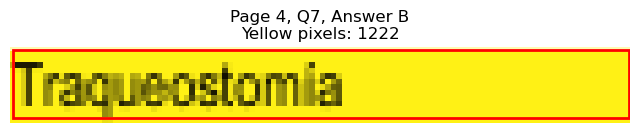

Page 4, Q7 - C: Detected box: x0=82.9, y0=692.5, x1=175.2, y1=705.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 454
Page 4, Q7, C: Yellow percentage: 0.0%


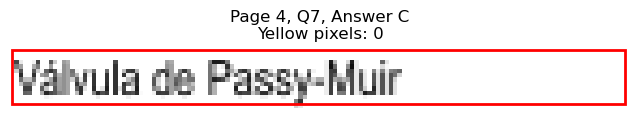

Page 4, Q7 - D: Detected box: x0=334.6, y0=666.2, x1=434.0, y1=678.9
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 511
Page 4, Q7, D: Yellow percentage: 0.0%


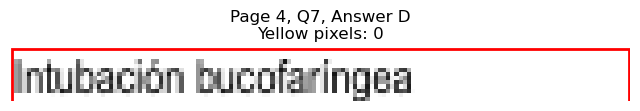

Page 4, Q7 - E: Detected box: x0=334.1, y0=679.8, x1=412.5, y1=692.4
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 399
Page 4, Q7, E: Yellow percentage: 0.0%


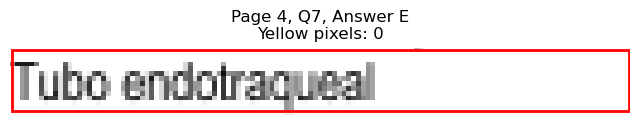


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.5, y0=743.8, x1=138.6, y1=756.5
Page 4, Q8, A: Yellow pixels: 107
Page 4, Q8, A: Total non-white pixels: 380
Page 4, Q8, A: Yellow percentage: 28.2%


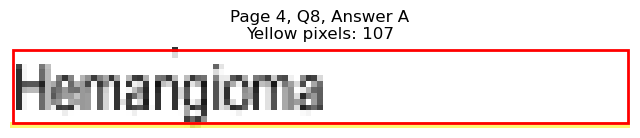

Page 4, Q8 - B: Detected box: x0=82.5, y0=756.6, x1=123.6, y1=769.2
Page 4, Q8, B: Yellow pixels: 1143
Page 4, Q8, B: Total non-white pixels: 1288
Page 4, Q8, B: Yellow percentage: 88.7%


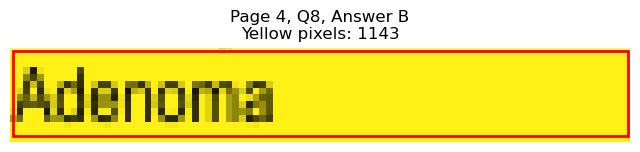

Page 4, Q8 - C: Detected box: x0=82.9, y0=770.2, x1=153.1, y1=782.9
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 355
Page 4, Q8, C: Yellow percentage: 0.0%


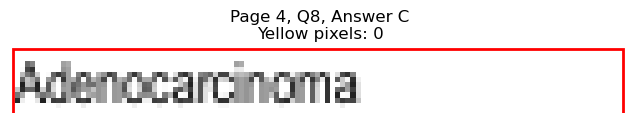

Page 4, Q8 - D: Detected box: x0=334.6, y0=407.8, x1=380.8, y1=420.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 498
Page 4, Q8, D: Yellow percentage: 0.0%


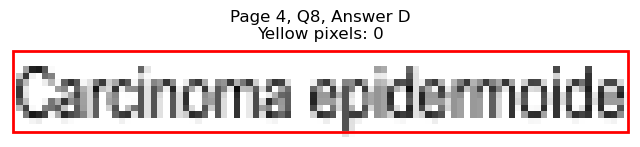

Page 4, Q8 - E: Detected box: x0=334.1, y0=757.5, x1=411.4, y1=770.2
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 413
Page 4, Q8, E: Yellow percentage: 0.0%


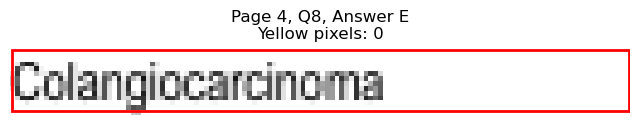


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=153.6, y1=123.0
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 384
Page 5, Q1, A: Yellow percentage: 0.0%


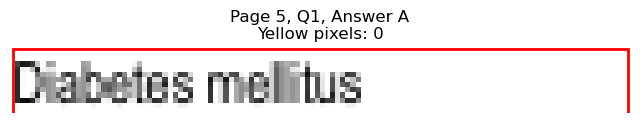

Page 5, Q1 - B: Detected box: x0=82.5, y0=123.0, x1=165.7, y1=135.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 448
Page 5, Q1, B: Yellow percentage: 0.0%


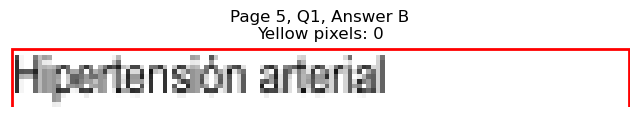

Page 5, Q1 - C: Detected box: x0=82.9, y0=136.7, x1=172.2, y1=149.4
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 450
Page 5, Q1, C: Yellow percentage: 0.0%


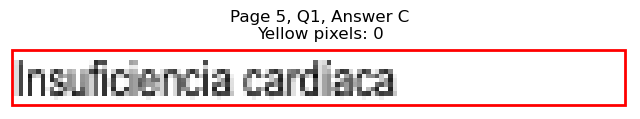

Page 5, Q1 - D: Detected box: x0=334.6, y0=110.4, x1=403.9, y1=123.1
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 358
Page 5, Q1, D: Yellow percentage: 0.0%


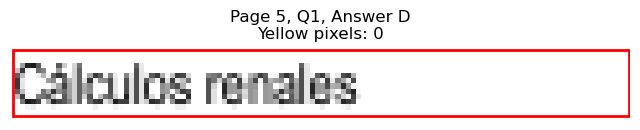

Page 5, Q1 - E: Detected box: x0=334.1, y0=124.0, x1=383.3, y1=136.6
Page 5, Q1, E: Yellow pixels: 1122
Page 5, Q1, E: Total non-white pixels: 1400
Page 5, Q1, E: Yellow percentage: 80.1%


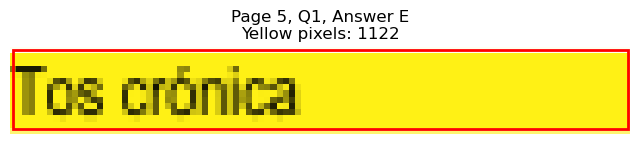


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=200.7, x1=192.3, y1=213.3
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 523
Page 5, Q2, A: Yellow percentage: 0.0%


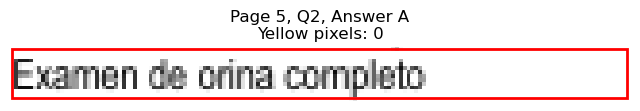

Page 5, Q2 - B: Detected box: x0=82.5, y0=213.4, x1=192.7, y1=226.0
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 551
Page 5, Q2, B: Yellow percentage: 0.0%


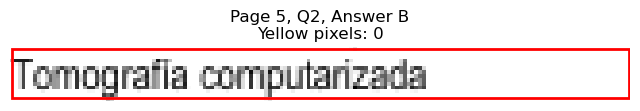

Page 5, Q2 - C: Detected box: x0=82.9, y0=227.1, x1=185.8, y1=239.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 526
Page 5, Q2, C: Yellow percentage: 0.0%


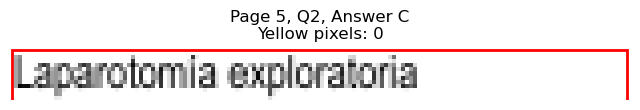

Page 5, Q2 - D: Detected box: x0=334.6, y0=200.8, x1=431.9, y1=213.4
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 523
Page 5, Q2, D: Yellow percentage: 0.0%


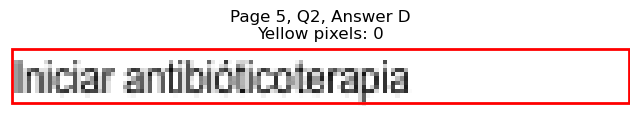

Page 5, Q2 - E: Detected box: x0=334.1, y0=214.3, x1=425.5, y1=227.0
Page 5, Q2, E: Yellow pixels: 1492
Page 5, Q2, E: Total non-white pixels: 1846
Page 5, Q2, E: Yellow percentage: 80.8%


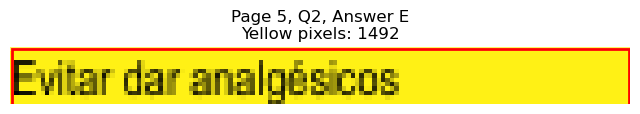


Page 5, Q2 - Selected Answer: E (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=278.4, x1=136.1, y1=291.1
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 269
Page 5, Q3, A: Yellow percentage: 0.0%


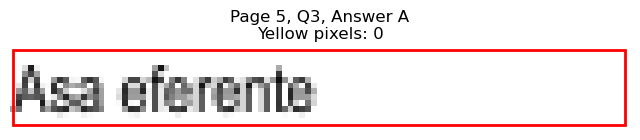

Page 5, Q3 - B: Detected box: x0=82.5, y0=291.2, x1=203.3, y1=303.8
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 621
Page 5, Q3, B: Yellow percentage: 0.0%


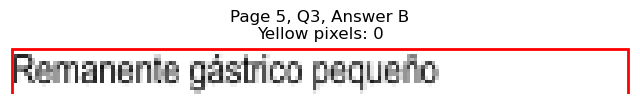

Page 5, Q3 - C: Detected box: x0=82.9, y0=304.8, x1=142.1, y1=317.5
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 288
Page 5, Q3, C: Yellow percentage: 0.0%


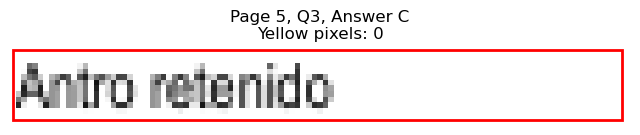

Page 5, Q3 - D: Detected box: x0=334.6, y0=278.6, x1=445.5, y1=291.2
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 584
Page 5, Q3, D: Yellow percentage: 0.0%


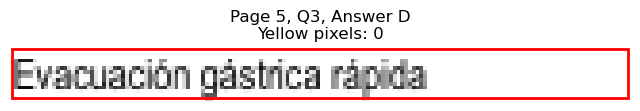

Page 5, Q3 - E: Detected box: x0=334.1, y0=292.0, x1=387.8, y1=304.7
Page 5, Q3, E: Yellow pixels: 1135
Page 5, Q3, E: Total non-white pixels: 1352
Page 5, Q3, E: Yellow percentage: 83.9%


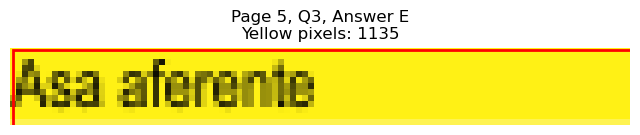


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=356.2, x1=117.6, y1=368.9
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 184
Page 5, Q4, A: Yellow percentage: 0.0%


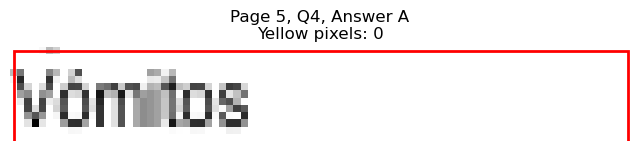

Page 5, Q4 - B: Detected box: x0=82.5, y0=368.9, x1=131.7, y1=381.6
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 268
Page 5, Q4, B: Yellow percentage: 0.0%


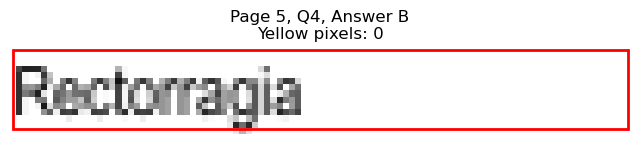

Page 5, Q4 - C: Detected box: x0=82.9, y0=382.5, x1=119.5, y1=395.1
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 172
Page 5, Q4, C: Yellow percentage: 0.0%


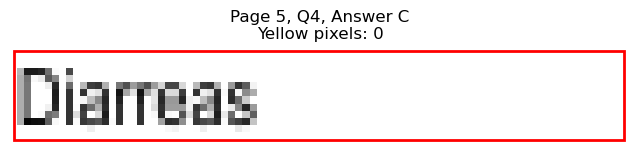

Page 5, Q4 - D: Detected box: x0=334.6, y0=356.3, x1=363.2, y1=369.0
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 153
Page 5, Q4, D: Yellow percentage: 0.0%


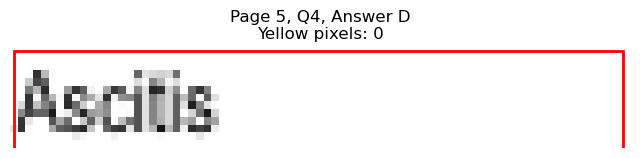

Page 5, Q4 - E: Detected box: x0=334.1, y0=369.8, x1=382.7, y1=382.4
Page 5, Q4, E: Yellow pixels: 1002
Page 5, Q4, E: Total non-white pixels: 1386
Page 5, Q4, E: Yellow percentage: 72.3%


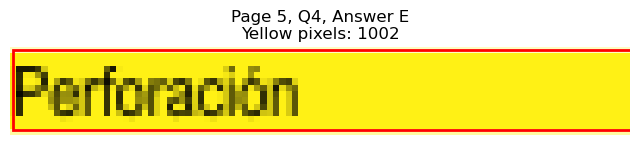


Page 5, Q4 - Selected Answer: E (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=446.6, x1=162.7, y1=459.2
Page 5, Q5, A: Yellow pixels: 131
Page 5, Q5, A: Total non-white pixels: 556
Page 5, Q5, A: Yellow percentage: 23.6%


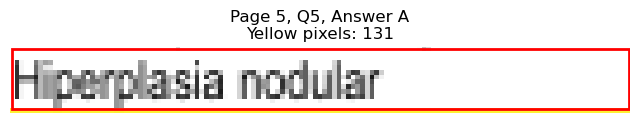

Page 5, Q5 - B: Detected box: x0=82.5, y0=459.3, x1=180.3, y1=472.0
Page 5, Q5, B: Yellow pixels: 1572
Page 5, Q5, B: Total non-white pixels: 1937
Page 5, Q5, B: Yellow percentage: 81.2%


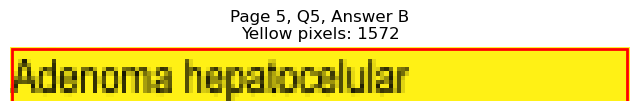

Page 5, Q5 - C: Detected box: x0=82.9, y0=472.9, x1=175.2, y1=485.5
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 474
Page 5, Q5, C: Yellow percentage: 0.0%


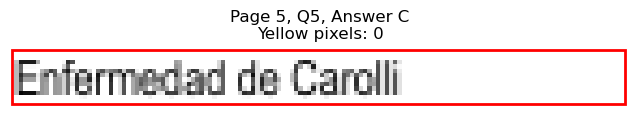

Page 5, Q5 - D: Detected box: x0=334.6, y0=446.7, x1=414.3, y1=459.3
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 393
Page 5, Q5, D: Yellow percentage: 0.0%


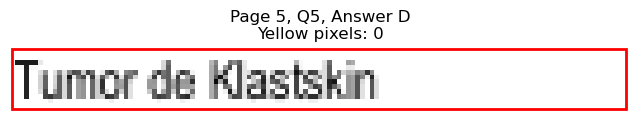

Page 5, Q5 - E: Detected box: x0=334.1, y0=460.1, x1=413.8, y1=472.8
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 413
Page 5, Q5, E: Yellow percentage: 0.0%


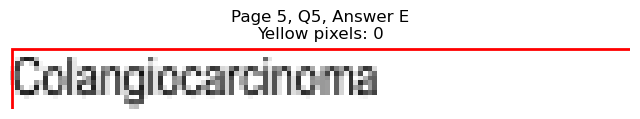


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=524.3, x1=129.1, y1=537.0
Page 5, Q6, A: Yellow pixels: 1203
Page 5, Q6, A: Total non-white pixels: 1372
Page 5, Q6, A: Yellow percentage: 87.7%


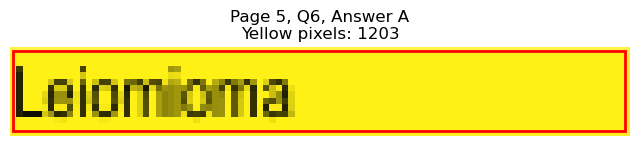

Page 5, Q6 - B: Detected box: x0=82.5, y0=538.0, x1=145.7, y1=550.7
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 305
Page 5, Q6, B: Yellow percentage: 0.0%


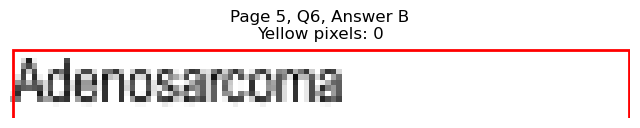

Page 5, Q6 - C: Detected box: x0=82.9, y0=551.6, x1=153.1, y1=564.2
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 355
Page 5, Q6, C: Yellow percentage: 0.0%


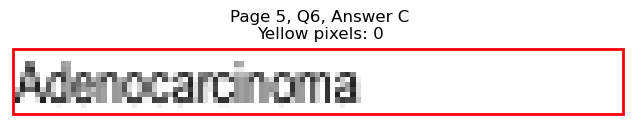

Page 5, Q6 - D: Detected box: x0=334.6, y0=524.3, x1=412.9, y1=537.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 367
Page 5, Q6, D: Yellow percentage: 0.0%


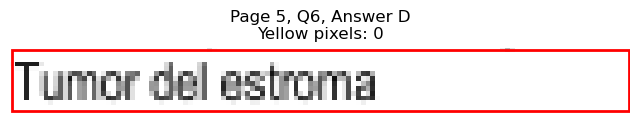

Page 5, Q6 - E: Detected box: x0=334.1, y0=537.9, x1=394.9, y1=550.6
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 300
Page 5, Q6, E: Yellow percentage: 0.0%


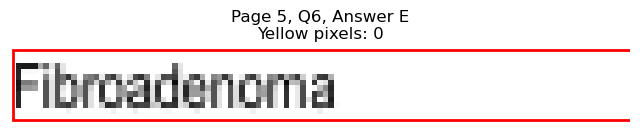


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=628.3, x1=219.4, y1=640.9
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 714
Page 5, Q7, A: Yellow percentage: 0.0%


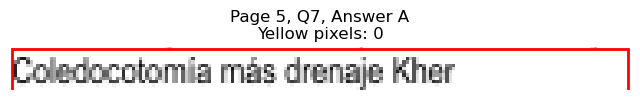

Page 5, Q7 - B: Detected box: x0=82.5, y0=641.0, x1=164.7, y1=653.6
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 448
Page 5, Q7, B: Yellow percentage: 0.0%


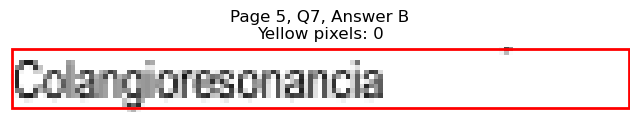

Page 5, Q7 - C: Detected box: x0=82.9, y0=654.6, x1=266.6, y1=667.2
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 938
Page 5, Q7, C: Yellow percentage: 0.0%


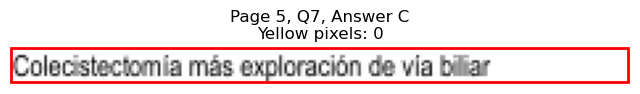

Page 5, Q7 - D: Detected box: x0=334.6, y0=628.4, x1=480.1, y1=641.0
Page 5, Q7, D: Yellow pixels: 2084
Page 5, Q7, D: Total non-white pixels: 2688
Page 5, Q7, D: Yellow percentage: 77.5%


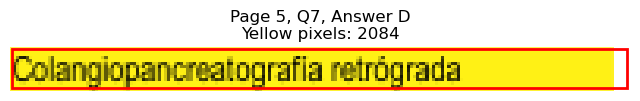

Page 5, Q7 - E: Detected box: x0=334.1, y0=655.5, x1=479.7, y1=668.2
Page 5, Q7, E: Yellow pixels: 192
Page 5, Q7, E: Total non-white pixels: 978
Page 5, Q7, E: Yellow percentage: 19.6%


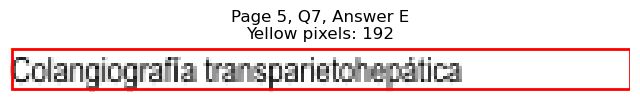


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=693.3, x1=113.5, y1=706.0
Page 5, Q8, A: Yellow pixels: 940
Page 5, Q8, A: Total non-white pixels: 1066
Page 5, Q8, A: Yellow percentage: 88.2%


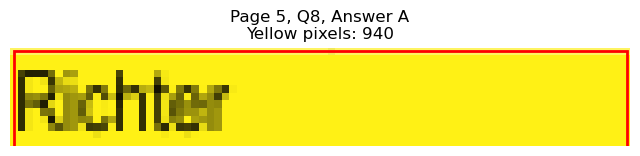

Page 5, Q8 - B: Detected box: x0=82.5, y0=706.1, x1=115.1, y1=718.7
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 176
Page 5, Q8, B: Yellow percentage: 0.0%


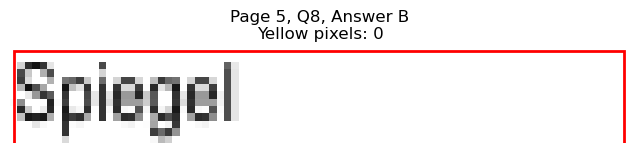

Page 5, Q8 - C: Detected box: x0=82.9, y0=719.7, x1=103.0, y1=732.4
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 97
Page 5, Q8, C: Yellow percentage: 0.0%


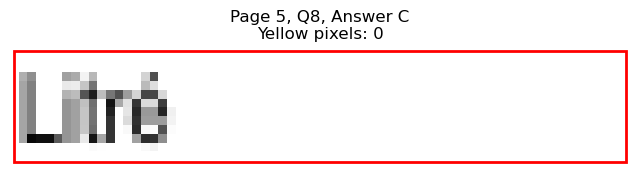

Page 5, Q8 - D: Detected box: x0=334.6, y0=693.5, x1=368.7, y1=706.1
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 181
Page 5, Q8, D: Yellow percentage: 0.0%


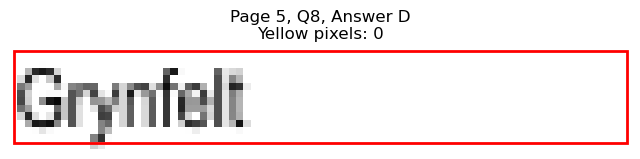

Page 5, Q8 - E: Detected box: x0=334.1, y0=707.0, x1=434.1, y1=719.7
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 511
Page 5, Q8, E: Yellow percentage: 0.0%


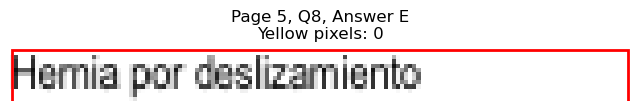


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=165.7, y1=110.4
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 415
Page 6, Q1, A: Yellow percentage: 0.0%


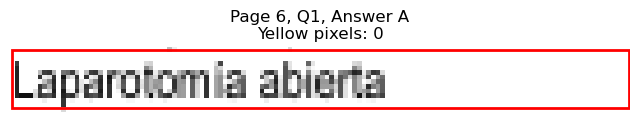

Page 6, Q1 - B: Detected box: x0=82.5, y0=110.4, x1=154.2, y1=123.1
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 380
Page 6, Q1, B: Yellow percentage: 0.0%


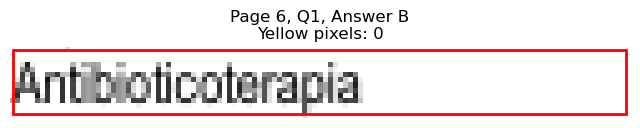

Page 6, Q1 - C: Detected box: x0=82.9, y0=124.1, x1=165.3, y1=136.8
Page 6, Q1, C: Yellow pixels: 1390
Page 6, Q1, C: Total non-white pixels: 1742
Page 6, Q1, C: Yellow percentage: 79.8%


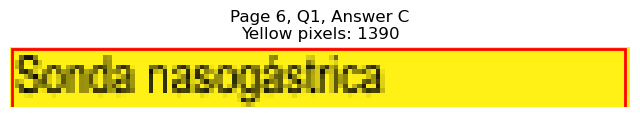

Page 6, Q1 - D: Detected box: x0=334.6, y0=97.8, x1=378.8, y1=110.5
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 235
Page 6, Q1, D: Yellow percentage: 0.0%


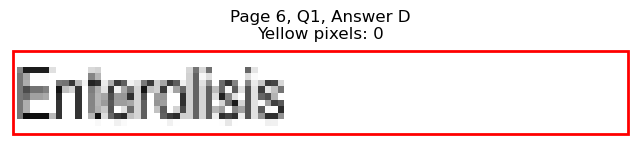

Page 6, Q1 - E: Detected box: x0=334.1, y0=111.3, x1=439.5, y1=123.9
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 523
Page 6, Q1, E: Yellow percentage: 0.0%


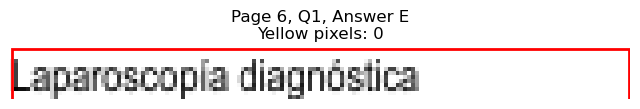


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=162.9, x1=119.1, y1=175.5
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 171
Page 6, Q2, A: Yellow percentage: 0.0%


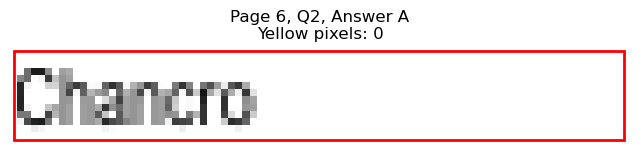

Page 6, Q2 - B: Detected box: x0=82.5, y0=175.6, x1=129.6, y1=188.2
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 225
Page 6, Q2, B: Yellow percentage: 0.0%


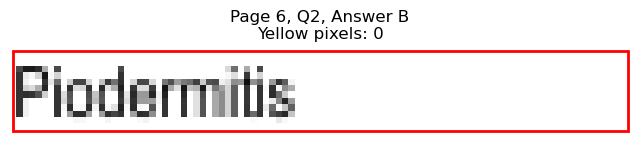

Page 6, Q2 - C: Detected box: x0=82.9, y0=189.1, x1=117.0, y1=201.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 163
Page 6, Q2, C: Yellow percentage: 0.0%


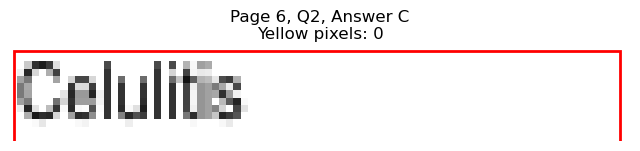

Page 6, Q2 - D: Detected box: x0=334.6, y0=163.0, x1=371.7, y1=175.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 178
Page 6, Q2, D: Yellow percentage: 0.0%


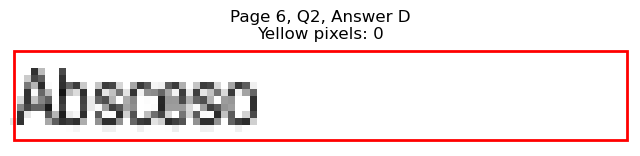

Page 6, Q2 - E: Detected box: x0=334.1, y0=176.4, x1=366.8, y1=189.1
Page 6, Q2, E: Yellow pixels: 962
Page 6, Q2, E: Total non-white pixels: 1162
Page 6, Q2, E: Yellow percentage: 82.8%


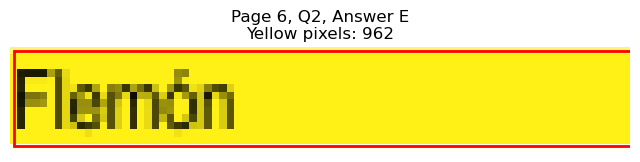


Page 6, Q2 - Selected Answer: E (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=253.2, x1=164.7, y1=265.9
Page 6, Q3, A: Yellow pixels: 1386
Page 6, Q3, A: Total non-white pixels: 1729
Page 6, Q3, A: Yellow percentage: 80.2%


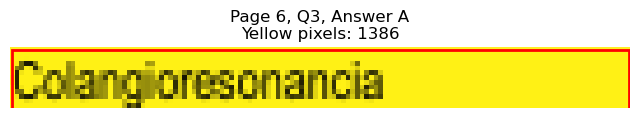

Page 6, Q3 - B: Detected box: x0=82.5, y0=266.9, x1=149.2, y1=279.6
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 327
Page 6, Q3, B: Yellow percentage: 0.0%


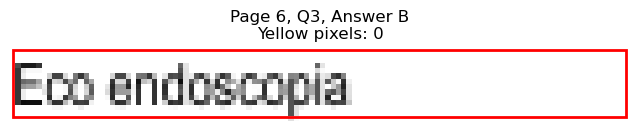

Page 6, Q3 - C: Detected box: x0=82.9, y0=280.5, x1=193.2, y1=293.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 573
Page 6, Q3, C: Yellow percentage: 0.0%


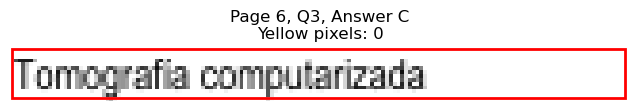

Page 6, Q3 - D: Detected box: x0=334.6, y0=253.2, x1=419.9, y1=265.9
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 420
Page 6, Q3, D: Yellow percentage: 0.0%


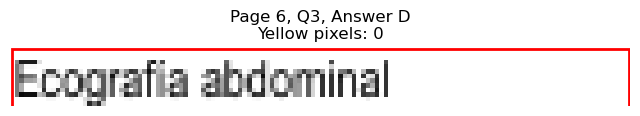

Page 6, Q3 - E: Detected box: x0=334.1, y0=266.8, x1=412.9, y1=279.5
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 416
Page 6, Q3, E: Yellow percentage: 0.0%


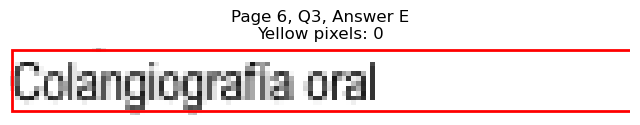


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=344.6, x1=151.7, y1=357.2
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 354
Page 6, Q4, A: Yellow percentage: 0.0%


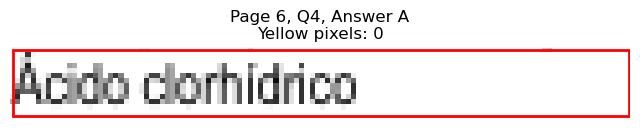

Page 6, Q4 - B: Detected box: x0=82.5, y0=357.3, x1=117.0, y1=369.9
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 176
Page 6, Q4, B: Yellow percentage: 0.0%


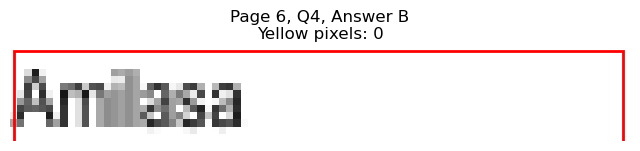

Page 6, Q4 - C: Detected box: x0=82.9, y0=370.8, x1=123.0, y1=383.5
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 199
Page 6, Q4, C: Yellow percentage: 0.0%


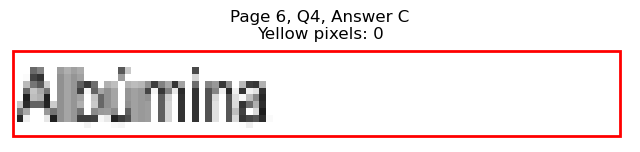

Page 6, Q4 - D: Detected box: x0=334.6, y0=344.7, x1=363.8, y1=357.3
Page 6, Q4, D: Yellow pixels: 1012
Page 6, Q4, D: Total non-white pixels: 1120
Page 6, Q4, D: Yellow percentage: 90.4%


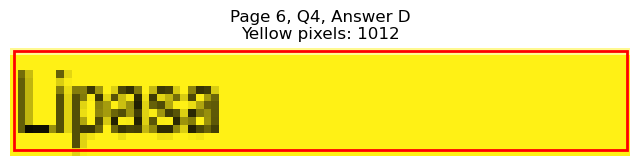

Page 6, Q4 - E: Detected box: x0=334.1, y0=358.1, x1=379.3, y1=370.8
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 341
Page 6, Q4, E: Yellow percentage: 0.0%


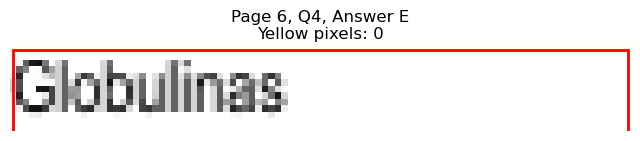


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=409.6, x1=237.5, y1=422.3
Page 6, Q5, A: Yellow pixels: 192
Page 6, Q5, A: Total non-white pixels: 939
Page 6, Q5, A: Yellow percentage: 20.4%


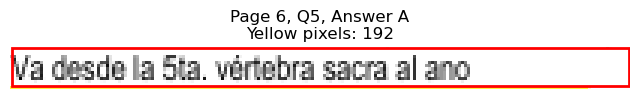

Page 6, Q5 - B: Detected box: x0=82.5, y0=422.3, x1=222.4, y1=435.0
Page 6, Q5, B: Yellow pixels: 1952
Page 6, Q5, B: Total non-white pixels: 2483
Page 6, Q5, B: Yellow percentage: 78.6%


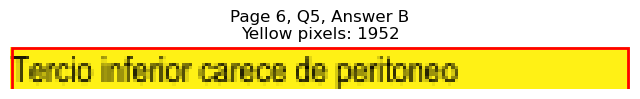

Page 6, Q5 - C: Detected box: x0=82.9, y0=436.0, x1=204.3, y1=448.7
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 588
Page 6, Q5, C: Yellow percentage: 0.0%


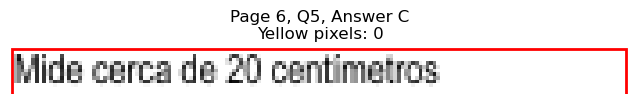

Page 6, Q5 - D: Detected box: x0=334.6, y0=409.7, x1=476.1, y1=422.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 649
Page 6, Q5, D: Yellow percentage: 0.0%


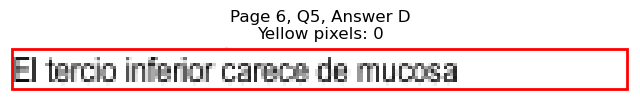

Page 6, Q5 - E: Detected box: x0=334.1, y0=423.3, x1=499.2, y1=435.9
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 771
Page 6, Q5, E: Yellow percentage: 0.0%


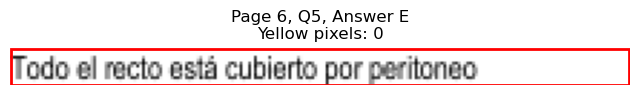


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=487.5, x1=221.3, y1=500.2
Page 6, Q6, A: Yellow pixels: 2138
Page 6, Q6, A: Total non-white pixels: 2660
Page 6, Q6, A: Yellow percentage: 80.4%


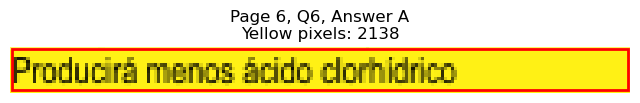

Page 6, Q6 - B: Detected box: x0=82.5, y0=501.2, x1=264.5, y1=513.8
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 926
Page 6, Q6, B: Yellow percentage: 0.0%


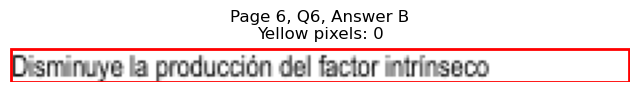

Page 6, Q6 - C: Detected box: x0=82.9, y0=514.7, x1=210.9, y1=527.4
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 635
Page 6, Q6, C: Yellow percentage: 0.0%


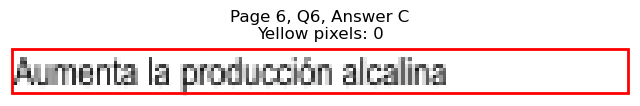

Page 6, Q6 - D: Detected box: x0=334.6, y0=487.5, x1=483.6, y1=500.2
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 736
Page 6, Q6, D: Yellow percentage: 0.0%


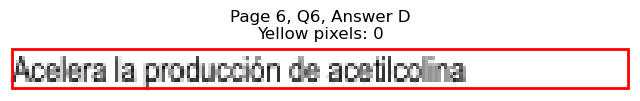

Page 6, Q6 - E: Detected box: x0=334.1, y0=501.1, x1=482.6, y1=513.7
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 717
Page 6, Q6, E: Yellow percentage: 0.0%


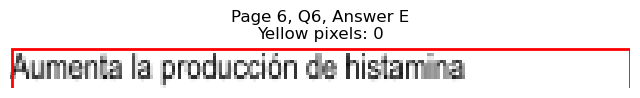


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=553.5, x1=168.3, y1=566.2
Page 6, Q7, A: Yellow pixels: 137
Page 6, Q7, A: Total non-white pixels: 570
Page 6, Q7, A: Yellow percentage: 24.0%


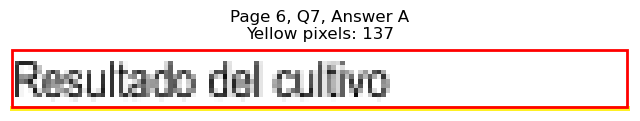

Page 6, Q7 - B: Detected box: x0=82.5, y0=566.2, x1=193.8, y1=578.9
Page 6, Q7, B: Yellow pixels: 1662
Page 6, Q7, B: Total non-white pixels: 2106
Page 6, Q7, B: Yellow percentage: 78.9%


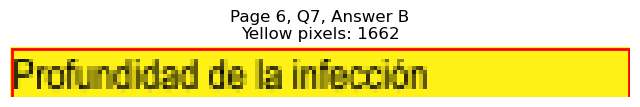

Page 6, Q7 - C: Detected box: x0=82.9, y0=579.9, x1=167.2, y1=592.6
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 425
Page 6, Q7, C: Yellow percentage: 0.0%


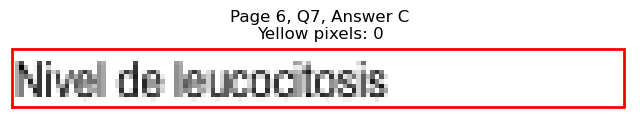

Page 6, Q7 - D: Detected box: x0=334.6, y0=553.6, x1=394.3, y1=566.3
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 304
Page 6, Q7, D: Yellow percentage: 0.0%


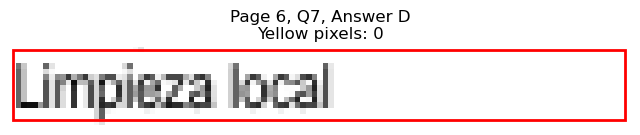

Page 6, Q7 - E: Detected box: x0=334.1, y0=567.1, x1=428.5, y1=579.7
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 459
Page 6, Q7, E: Yellow percentage: 0.0%


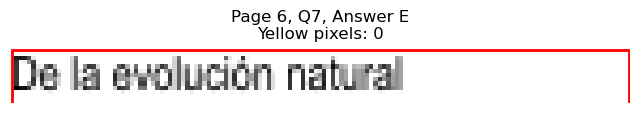


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.5, y0=631.3, x1=181.2, y1=643.9
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 656
Page 6, Q8, A: Yellow percentage: 0.0%


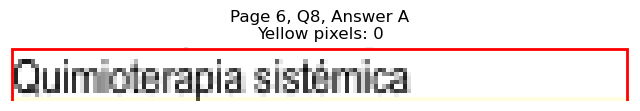

Page 6, Q8 - B: Detected box: x0=82.5, y0=644.0, x1=232.5, y1=656.7
Page 6, Q8, B: Yellow pixels: 1891
Page 6, Q8, B: Total non-white pixels: 2457
Page 6, Q8, B: Yellow percentage: 77.0%


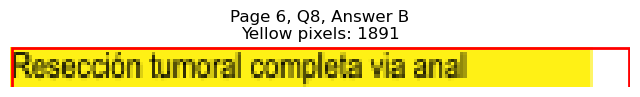

Page 6, Q8 - C: Detected box: x0=82.9, y0=657.6, x1=221.9, y1=670.2
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 712
Page 6, Q8, C: Yellow percentage: 0.0%


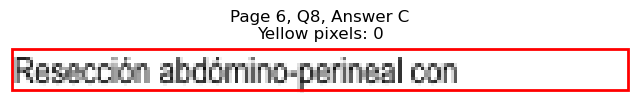

Page 6, Q8 - D: Detected box: x0=338.2, y0=631.4, x1=401.9, y1=644.0
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 326
Page 6, Q8, D: Yellow percentage: 0.0%


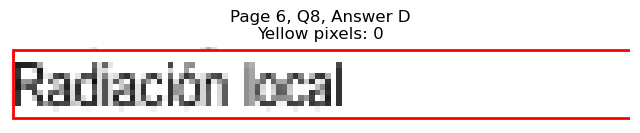

Page 6, Q8 - E: Detected box: x0=337.8, y0=644.9, x1=441.1, y1=657.5
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 468
Page 6, Q8, E: Yellow percentage: 0.0%


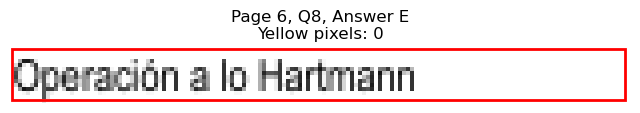


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.5, y0=722.6, x1=173.8, y1=735.3
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 450
Page 6, Q9, A: Yellow percentage: 0.0%


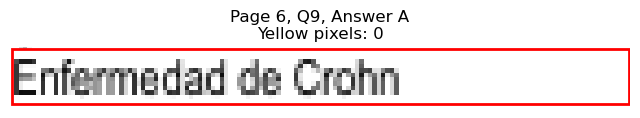

Page 6, Q9 - B: Detected box: x0=82.5, y0=735.3, x1=149.2, y1=748.0
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 341
Page 6, Q9, B: Yellow percentage: 0.0%


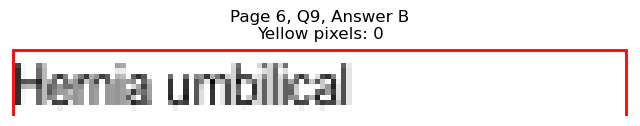

Page 6, Q9 - C: Detected box: x0=82.9, y0=749.0, x1=151.7, y1=761.7
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 315
Page 6, Q9, C: Yellow percentage: 0.0%


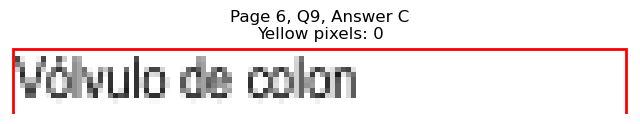

Page 6, Q9 - D: Detected box: x0=334.6, y0=722.7, x1=397.3, y1=735.4
Page 6, Q9, D: Yellow pixels: 1241
Page 6, Q9, D: Total non-white pixels: 1596
Page 6, Q9, D: Yellow percentage: 77.8%


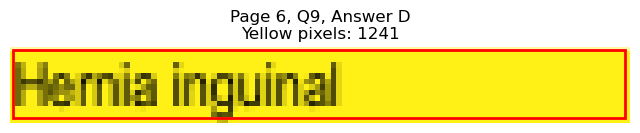

Page 6, Q9 - E: Detected box: x0=334.1, y0=736.2, x1=370.4, y1=748.8
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 286
Page 6, Q9, E: Yellow percentage: 0.0%


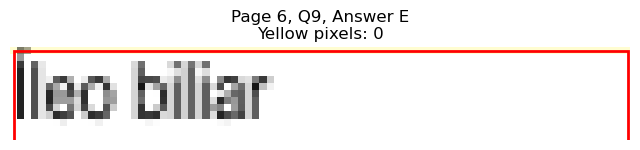


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=132.6, y1=110.4
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 255
Page 7, Q1, A: Yellow percentage: 0.0%


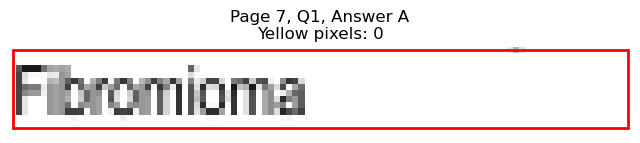

Page 7, Q1 - B: Detected box: x0=82.5, y0=110.4, x1=131.7, y1=123.1
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 241
Page 7, Q1, B: Yellow percentage: 0.0%


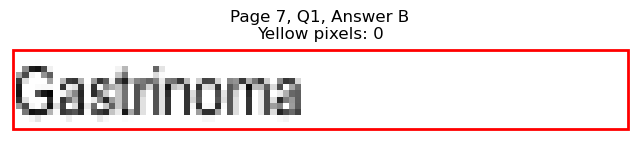

Page 7, Q1 - C: Detected box: x0=82.9, y0=124.1, x1=129.6, y1=136.8
Page 7, Q1, C: Yellow pixels: 1092
Page 7, Q1, C: Total non-white pixels: 1274
Page 7, Q1, C: Yellow percentage: 85.7%


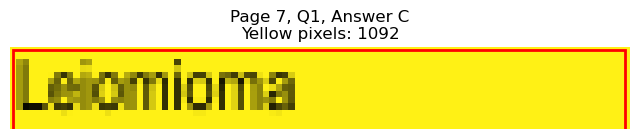

Page 7, Q1 - D: Detected box: x0=334.6, y0=97.8, x1=375.8, y1=110.5
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 195
Page 7, Q1, D: Yellow percentage: 0.0%


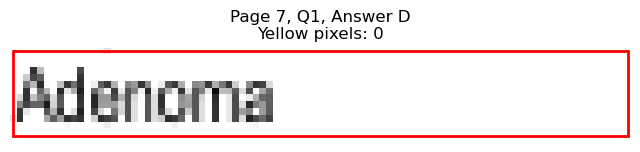

Page 7, Q1 - E: Detected box: x0=334.1, y0=111.3, x1=391.9, y1=123.9
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 281
Page 7, Q1, E: Yellow percentage: 0.0%


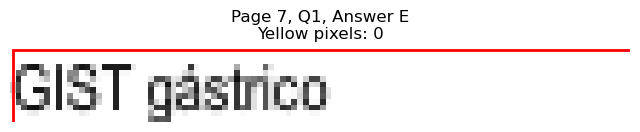


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=200.7, x1=221.4, y1=213.3
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 710
Page 7, Q2, A: Yellow percentage: 0.0%


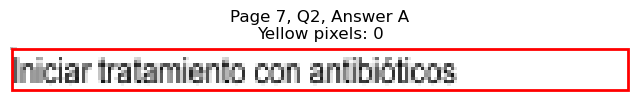

Page 7, Q2 - B: Detected box: x0=82.5, y0=213.4, x1=182.8, y1=226.0
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 517
Page 7, Q2, B: Yellow percentage: 0.0%


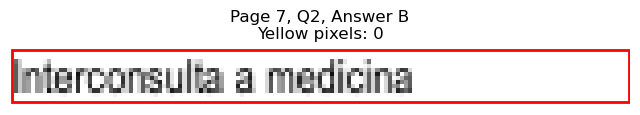

Page 7, Q2 - C: Detected box: x0=82.9, y0=227.1, x1=186.3, y1=239.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 520
Page 7, Q2, C: Yellow percentage: 0.0%


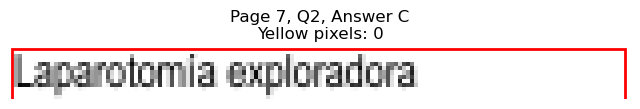

Page 7, Q2 - D: Detected box: x0=334.6, y0=200.8, x1=481.7, y1=213.4
Page 7, Q2, D: Yellow pixels: 1956
Page 7, Q2, D: Total non-white pixels: 2688
Page 7, Q2, D: Yellow percentage: 72.8%


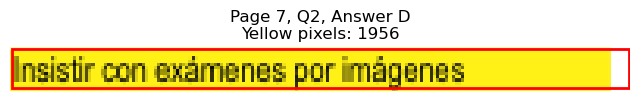

Page 7, Q2 - E: Detected box: x0=334.1, y0=214.3, x1=439.5, y1=227.0
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 679
Page 7, Q2, E: Yellow percentage: 0.0%


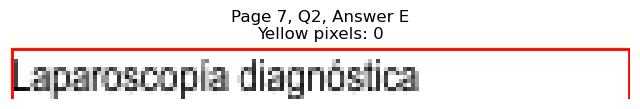


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=265.8, x1=149.7, y1=278.5
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 352
Page 7, Q3, A: Yellow percentage: 0.0%


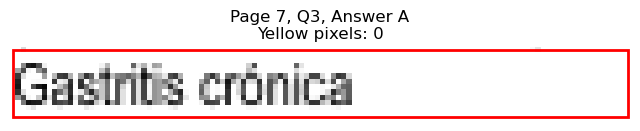

Page 7, Q3 - B: Detected box: x0=82.5, y0=278.6, x1=170.2, y1=291.2
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 468
Page 7, Q3, B: Yellow percentage: 0.0%


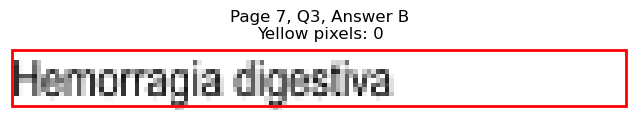

Page 7, Q3 - C: Detected box: x0=82.9, y0=292.1, x1=155.7, y1=304.8
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 378
Page 7, Q3, C: Yellow percentage: 0.0%


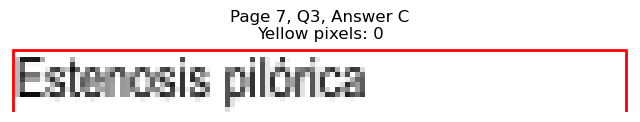

Page 7, Q3 - D: Detected box: x0=334.6, y0=265.9, x1=394.9, y1=278.6
Page 7, Q3, D: Yellow pixels: 1191
Page 7, Q3, D: Total non-white pixels: 1554
Page 7, Q3, D: Yellow percentage: 76.6%


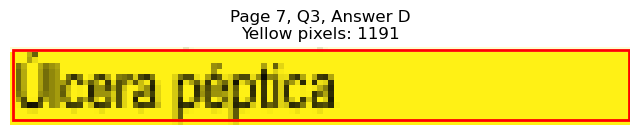

Page 7, Q3 - E: Detected box: x0=334.1, y0=279.4, x1=408.4, y1=292.1
Page 7, Q3, E: Yellow pixels: 125
Page 7, Q3, E: Total non-white pixels: 520
Page 7, Q3, E: Yellow percentage: 24.0%


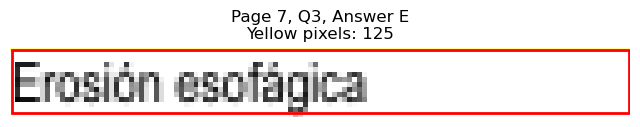


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=330.9, x1=187.2, y1=343.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 539
Page 7, Q4, A: Yellow percentage: 0.0%


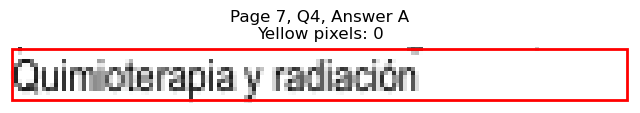

Page 7, Q4 - B: Detected box: x0=82.5, y0=343.6, x1=169.2, y1=356.3
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 431
Page 7, Q4, B: Yellow percentage: 0.0%


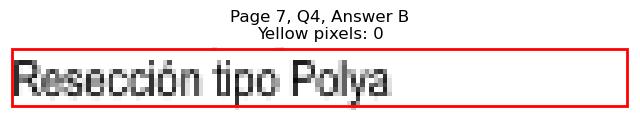

Page 7, Q4 - C: Detected box: x0=82.9, y0=357.3, x1=195.7, y1=369.9
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 595
Page 7, Q4, C: Yellow percentage: 0.0%


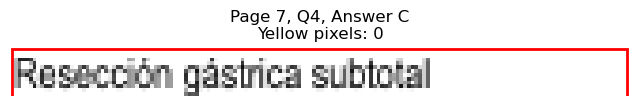

Page 7, Q4 - D: Detected box: x0=334.6, y0=331.0, x1=437.9, y1=343.7
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 517
Page 7, Q4, D: Yellow percentage: 0.0%


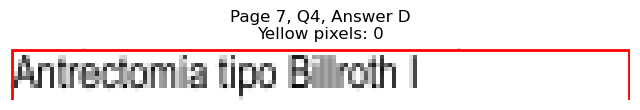

Page 7, Q4 - E: Detected box: x0=334.1, y0=344.6, x1=418.9, y1=357.2
Page 7, Q4, E: Yellow pixels: 1429
Page 7, Q4, E: Total non-white pixels: 1890
Page 7, Q4, E: Yellow percentage: 75.6%


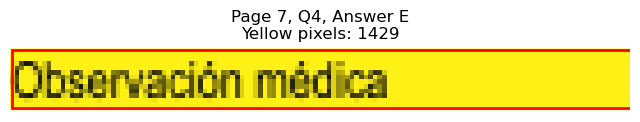


Page 7, Q4 - Selected Answer: E (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=421.2, x1=165.3, y1=433.9
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 433
Page 7, Q5, A: Yellow percentage: 0.0%


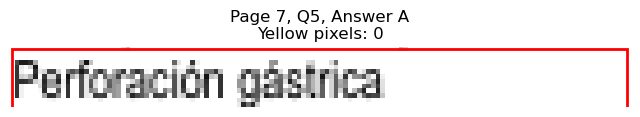

Page 7, Q5 - B: Detected box: x0=82.5, y0=434.0, x1=192.7, y1=446.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 589
Page 7, Q5, B: Yellow percentage: 0.0%


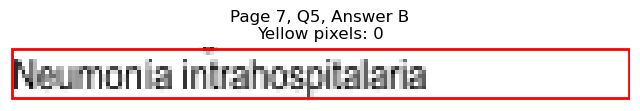

Page 7, Q5 - C: Detected box: x0=82.9, y0=447.6, x1=164.2, y1=460.3
Page 7, Q5, C: Yellow pixels: 1535
Page 7, Q5, C: Total non-white pixels: 1862
Page 7, Q5, C: Yellow percentage: 82.4%


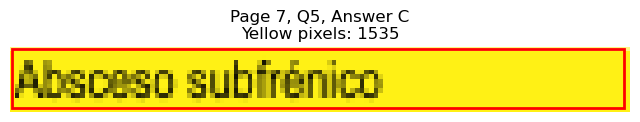

Page 7, Q5 - D: Detected box: x0=334.6, y0=421.4, x1=436.4, y1=434.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 522
Page 7, Q5, D: Yellow percentage: 0.0%


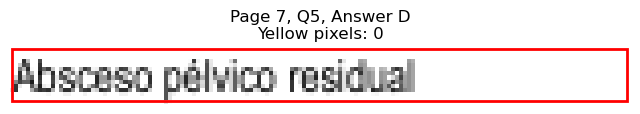

Page 7, Q5 - E: Detected box: x0=334.1, y0=434.9, x1=393.8, y1=447.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 305
Page 7, Q5, E: Yellow percentage: 0.0%


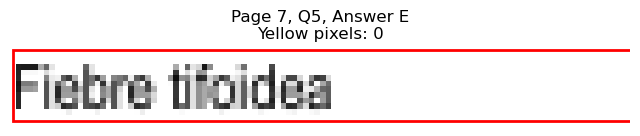


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=511.6, x1=186.7, y1=524.3
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 524
Page 7, Q6, A: Yellow percentage: 0.0%


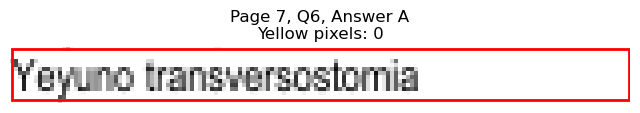

Page 7, Q6 - B: Detected box: x0=82.5, y0=524.3, x1=223.4, y1=537.0
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 666
Page 7, Q6, B: Yellow percentage: 0.0%


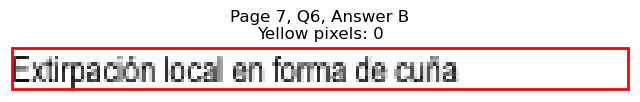

Page 7, Q6 - C: Detected box: x0=82.9, y0=538.0, x1=224.9, y1=550.7
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 736
Page 7, Q6, C: Yellow percentage: 0.0%


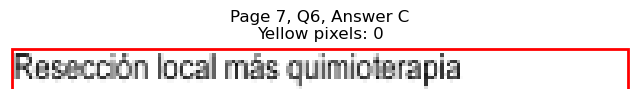

Page 7, Q6 - D: Detected box: x0=334.6, y0=511.7, x1=487.1, y1=524.4
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 739
Page 7, Q6, D: Yellow percentage: 0.0%


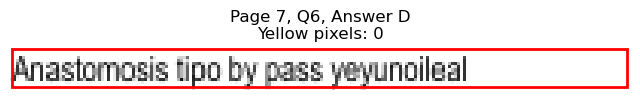

Page 7, Q6 - E: Detected box: x0=334.1, y0=525.3, x1=495.7, y1=538.0
Page 7, Q6, E: Yellow pixels: 1861
Page 7, Q6, E: Total non-white pixels: 2496
Page 7, Q6, E: Yellow percentage: 74.6%


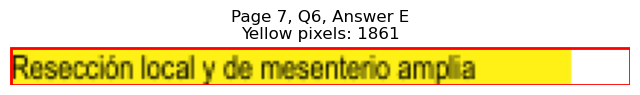


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=589.5, x1=173.2, y1=602.2
Page 7, Q7, A: Yellow pixels: 1647
Page 7, Q7, A: Total non-white pixels: 1988
Page 7, Q7, A: Yellow percentage: 82.8%


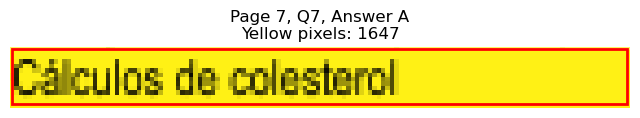

Page 7, Q7 - B: Detected box: x0=82.5, y0=603.1, x1=154.2, y1=615.7
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 359
Page 7, Q7, B: Yellow percentage: 0.0%


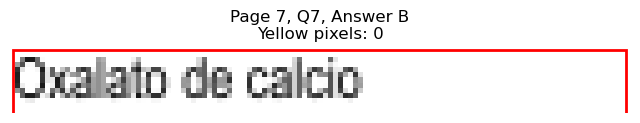

Page 7, Q7 - C: Detected box: x0=82.9, y0=616.7, x1=160.2, y1=629.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 379
Page 7, Q7, C: Yellow percentage: 0.0%


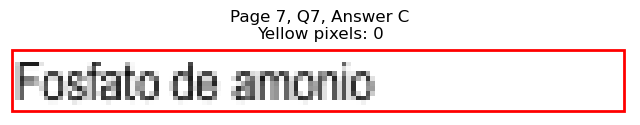

Page 7, Q7 - D: Detected box: x0=334.6, y0=589.5, x1=385.7, y1=602.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 271
Page 7, Q7, D: Yellow percentage: 0.0%


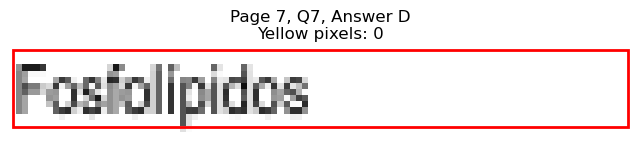

Page 7, Q7 - E: Detected box: x0=334.1, y0=602.9, x1=404.8, y1=615.6
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 332
Page 7, Q7, E: Yellow percentage: 0.0%


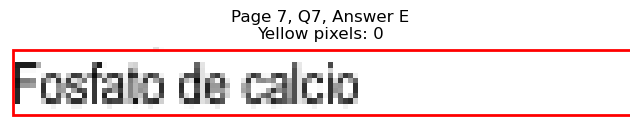


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.5, y0=668.1, x1=134.7, y1=680.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 266
Page 7, Q8, A: Yellow percentage: 0.0%


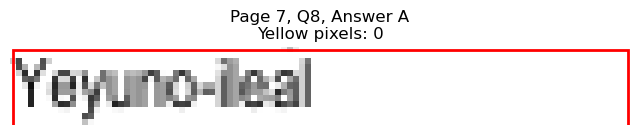

Page 7, Q8 - B: Detected box: x0=82.5, y0=680.9, x1=113.5, y1=693.5
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 160
Page 7, Q8, B: Yellow percentage: 0.0%


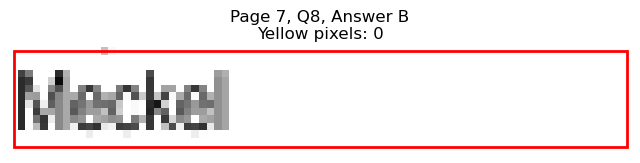

Page 7, Q8 - C: Detected box: x0=82.9, y0=694.5, x1=123.6, y1=707.2
Page 7, Q8, C: Yellow pixels: 1094
Page 7, Q8, C: Total non-white pixels: 1288
Page 7, Q8, C: Yellow percentage: 84.9%


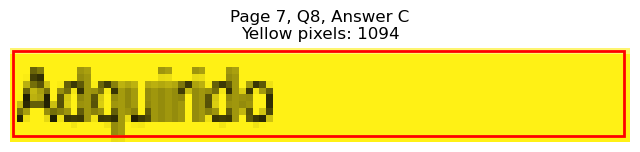

Page 7, Q8 - D: Detected box: x0=334.6, y0=668.3, x1=378.3, y1=680.9
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 230
Page 7, Q8, D: Yellow percentage: 0.0%


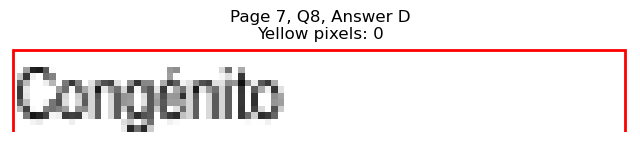

Page 7, Q8 - E: Detected box: x0=334.1, y0=681.7, x1=389.8, y1=694.4
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 299
Page 7, Q8, E: Yellow percentage: 0.0%


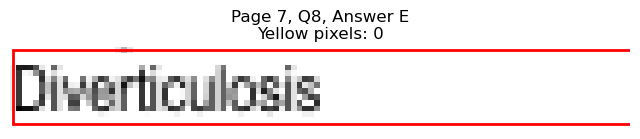


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.5, y0=745.9, x1=115.1, y1=758.6
Page 7, Q9, A: Yellow pixels: 84
Page 7, Q9, A: Total non-white pixels: 261
Page 7, Q9, A: Yellow percentage: 32.2%


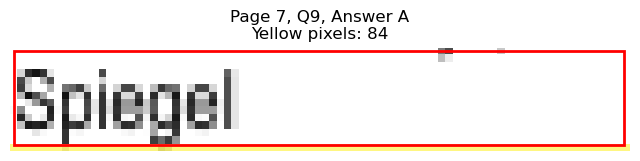

Page 7, Q9 - B: Detected box: x0=82.5, y0=758.6, x1=124.6, y1=771.3
Page 7, Q9, B: Yellow pixels: 1143
Page 7, Q9, B: Total non-white pixels: 1302
Page 7, Q9, B: Yellow percentage: 87.8%


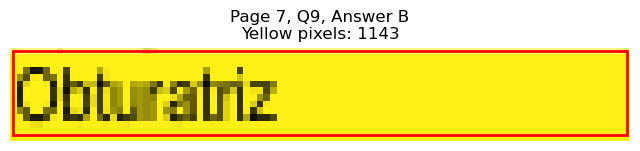

Page 7, Q9 - C: Detected box: x0=82.9, y0=772.2, x1=110.1, y1=784.8
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 104
Page 7, Q9, C: Yellow percentage: 0.0%


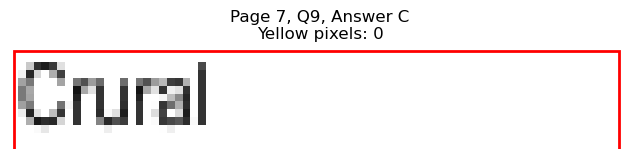

Page 7, Q9 - D: Detected box: x0=334.6, y0=746.0, x1=368.7, y1=758.7
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 181
Page 7, Q9, D: Yellow percentage: 0.0%


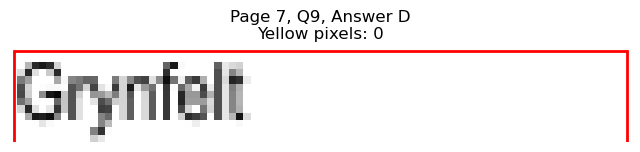

Page 7, Q9 - E: Detected box: x0=334.1, y0=759.4, x1=369.8, y1=772.1
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 192
Page 7, Q9, E: Yellow percentage: 0.0%


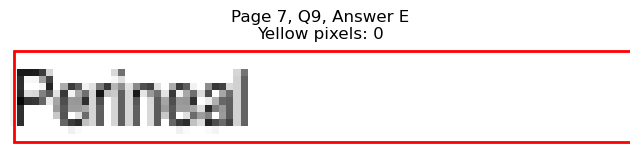


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=257.1, y1=135.6
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 952
Page 8, Q1, A: Yellow percentage: 0.0%


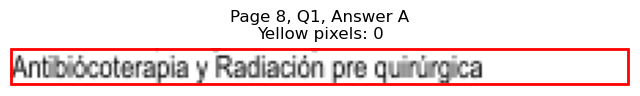

Page 8, Q1 - B: Detected box: x0=82.5, y0=135.6, x1=200.8, y1=148.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 624
Page 8, Q1, B: Yellow percentage: 0.0%


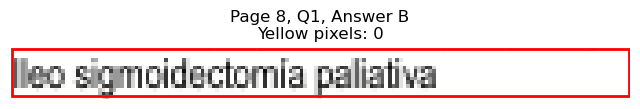

Page 8, Q1 - C: Detected box: x0=82.9, y0=149.3, x1=150.1, y1=162.0
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 543
Page 8, Q1, C: Yellow percentage: 0.0%


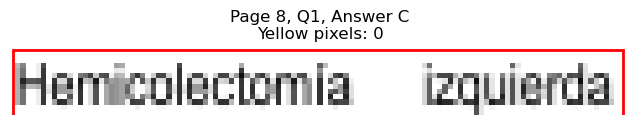

Page 8, Q1 - D: Detected box: x0=334.6, y0=123.0, x1=526.9, y1=135.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 978
Page 8, Q1, D: Yellow percentage: 0.0%


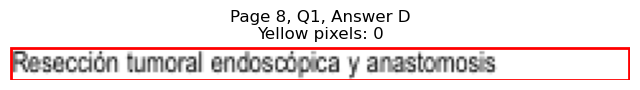

Page 8, Q1 - E: Detected box: x0=334.1, y0=150.1, x1=521.3, y1=162.8
Page 8, Q1, E: Yellow pixels: 1804
Page 8, Q1, E: Total non-white pixels: 2496
Page 8, Q1, E: Yellow percentage: 72.3%


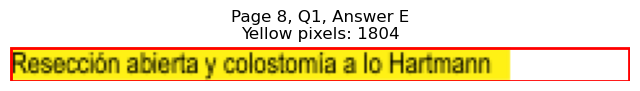


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=239.5, x1=168.7, y1=252.2
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 449
Page 8, Q2, A: Yellow percentage: 0.0%


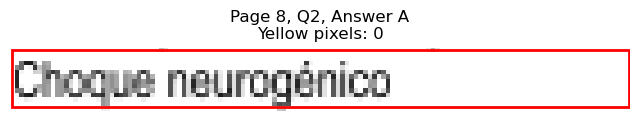

Page 8, Q2 - B: Detected box: x0=82.5, y0=252.3, x1=168.3, y1=264.9
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 445
Page 8, Q2, B: Yellow percentage: 0.0%


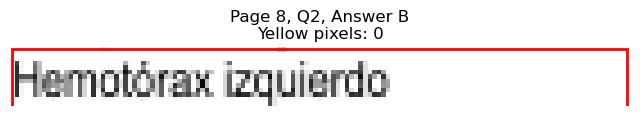

Page 8, Q2 - C: Detected box: x0=334.6, y0=239.7, x1=431.9, y1=252.3
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 484
Page 8, Q2, C: Yellow percentage: 0.0%


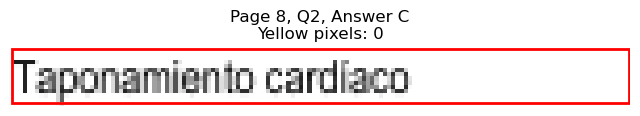

Page 8, Q2 - D: Detected box: x0=334.6, y0=253.2, x1=431.9, y1=265.9
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 463
Page 8, Q2, D: Yellow percentage: 0.0%


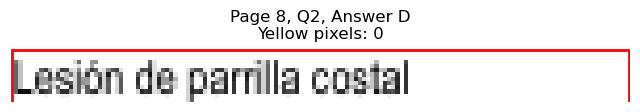

Page 8, Q2 - E: Detected box: x0=82.5, y0=266.8, x1=173.2, y1=279.5
Page 8, Q2, E: Yellow pixels: 1489
Page 8, Q2, E: Total non-white pixels: 1988
Page 8, Q2, E: Yellow percentage: 74.9%


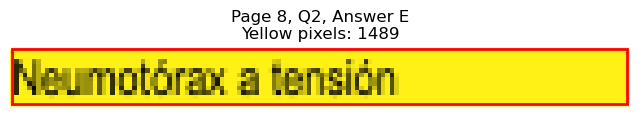


Page 8, Q2 - Selected Answer: E (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=317.3, x1=115.1, y1=330.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 149
Page 8, Q3, A: Yellow percentage: 0.0%


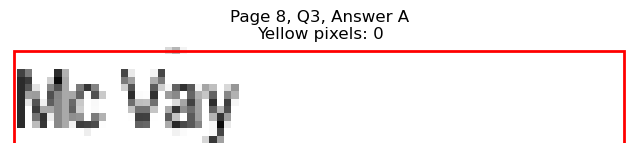

Page 8, Q3 - B: Detected box: x0=82.5, y0=330.0, x1=133.1, y1=342.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 227
Page 8, Q3, B: Yellow percentage: 0.0%


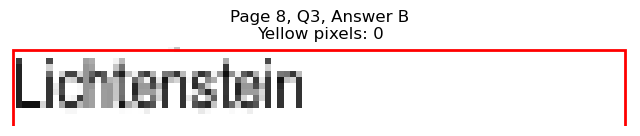

Page 8, Q3 - C: Detected box: x0=82.9, y0=343.6, x1=125.1, y1=356.3
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 233
Page 8, Q3, C: Yellow percentage: 0.0%


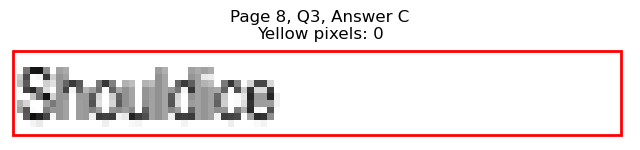

Page 8, Q3 - D: Detected box: x0=334.6, y0=317.4, x1=386.8, y1=330.1
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 274
Page 8, Q3, D: Yellow percentage: 0.0%


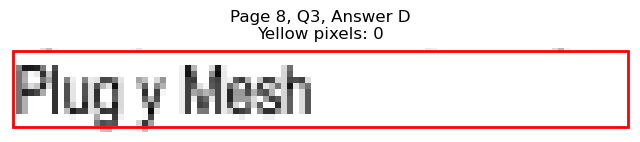

Page 8, Q3 - E: Detected box: x0=334.1, y0=330.9, x1=365.7, y1=343.5
Page 8, Q3, E: Yellow pixels: 937
Page 8, Q3, E: Total non-white pixels: 1148
Page 8, Q3, E: Yellow percentage: 81.6%


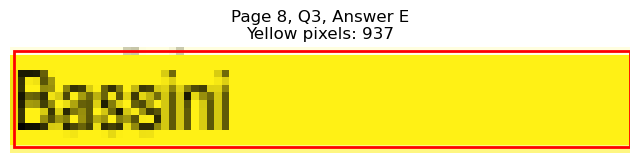


Page 8, Q3 - Selected Answer: E (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=395.0, x1=156.7, y1=407.6
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 374
Page 8, Q4, A: Yellow percentage: 0.0%


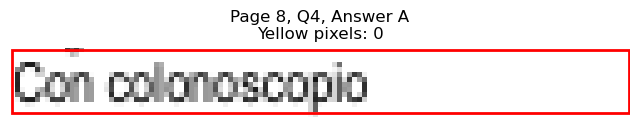

Page 8, Q4 - B: Detected box: x0=82.5, y0=407.8, x1=158.7, y1=420.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 351
Page 8, Q4, B: Yellow percentage: 0.0%


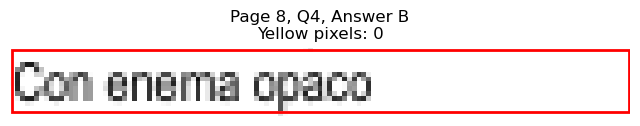

Page 8, Q4 - C: Detected box: x0=82.9, y0=421.4, x1=187.2, y1=434.0
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 520
Page 8, Q4, C: Yellow percentage: 0.0%


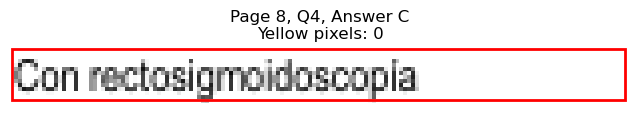

Page 8, Q4 - D: Detected box: x0=334.6, y0=395.1, x1=408.3, y1=407.7
Page 8, Q4, D: Yellow pixels: 1341
Page 8, Q4, D: Total non-white pixels: 1625
Page 8, Q4, D: Yellow percentage: 82.5%


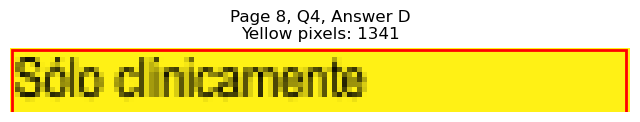

Page 8, Q4 - E: Detected box: x0=334.1, y0=408.6, x1=443.9, y1=421.3
Page 8, Q4, E: Yellow pixels: 160
Page 8, Q4, E: Total non-white pixels: 694
Page 8, Q4, E: Yellow percentage: 23.1%


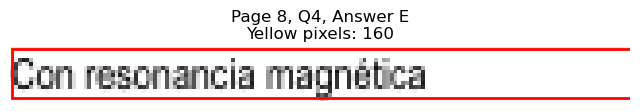


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=472.7, x1=175.8, y1=485.4
Page 8, Q5, A: Yellow pixels: 144
Page 8, Q5, A: Total non-white pixels: 633
Page 8, Q5, A: Yellow percentage: 22.7%


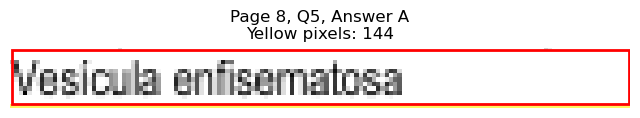

Page 8, Q5 - B: Detected box: x0=82.5, y0=485.5, x1=157.2, y1=498.1
Page 8, Q5, B: Yellow pixels: 1489
Page 8, Q5, B: Total non-white pixels: 1764
Page 8, Q5, B: Yellow percentage: 84.4%


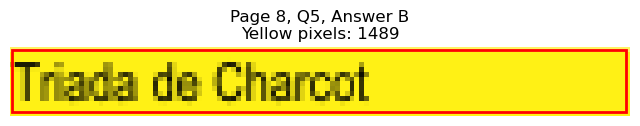

Page 8, Q5 - C: Detected box: x0=82.9, y0=499.1, x1=156.1, y1=511.8
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 386
Page 8, Q5, C: Yellow percentage: 0.0%


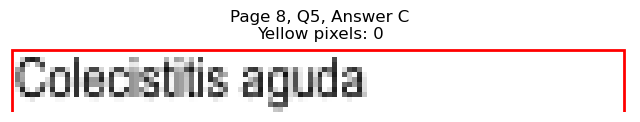

Page 8, Q5 - D: Detected box: x0=334.6, y0=472.9, x1=416.8, y1=485.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 407
Page 8, Q5, D: Yellow percentage: 0.0%


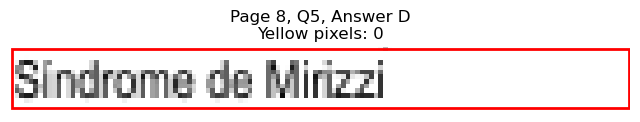

Page 8, Q5 - E: Detected box: x0=334.1, y0=486.4, x1=451.5, y1=499.1
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 591
Page 8, Q5, E: Yellow percentage: 0.0%


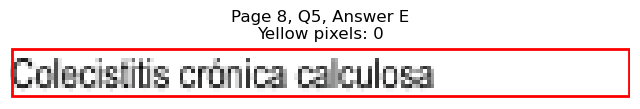


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=550.5, x1=211.4, y1=563.2
Page 8, Q6, A: Yellow pixels: 180
Page 8, Q6, A: Total non-white pixels: 817
Page 8, Q6, A: Yellow percentage: 22.0%


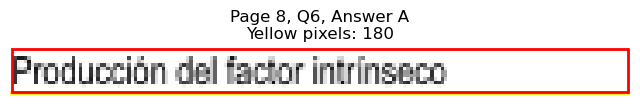

Page 8, Q6 - B: Detected box: x0=82.5, y0=563.2, x1=213.9, y1=575.9
Page 8, Q6, B: Yellow pixels: 1858
Page 8, Q6, B: Total non-white pixels: 2366
Page 8, Q6, B: Yellow percentage: 78.5%


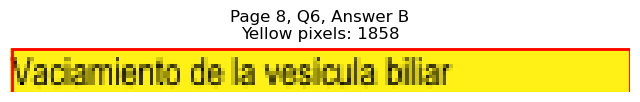

Page 8, Q6 - C: Detected box: x0=82.9, y0=576.9, x1=215.0, y1=589.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 666
Page 8, Q6, C: Yellow percentage: 0.0%


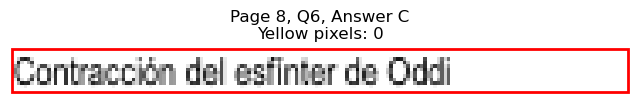

Page 8, Q6 - D: Detected box: x0=334.6, y0=550.6, x1=474.6, y1=563.3
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 704
Page 8, Q6, D: Yellow percentage: 0.0%


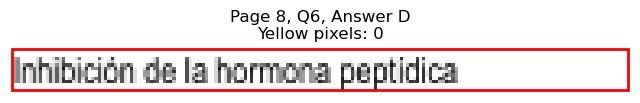

Page 8, Q6 - E: Detected box: x0=334.1, y0=564.1, x1=457.0, y1=576.7
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 668
Page 8, Q6, E: Yellow percentage: 0.0%


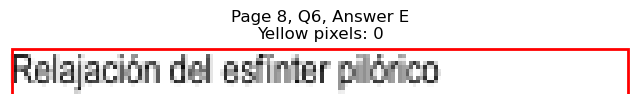


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=628.3, x1=178.2, y1=640.9
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 518
Page 8, Q7, A: Yellow percentage: 0.0%


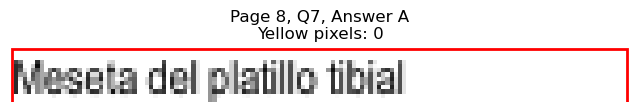

Page 8, Q7 - B: Detected box: x0=82.5, y0=641.0, x1=191.3, y1=653.6
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 524
Page 8, Q7, B: Yellow percentage: 0.0%


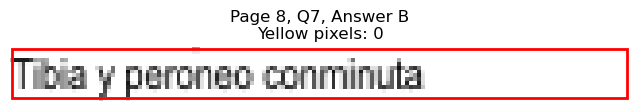

Page 8, Q7 - C: Detected box: x0=82.9, y0=654.6, x1=115.1, y1=667.2
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 145
Page 8, Q7, C: Yellow percentage: 0.0%


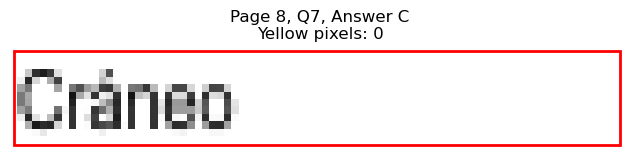

Page 8, Q7 - D: Detected box: x0=334.6, y0=628.4, x1=427.4, y1=641.0
Page 8, Q7, D: Yellow pixels: 1647
Page 8, Q7, D: Total non-white pixels: 2016
Page 8, Q7, D: Yellow percentage: 81.7%


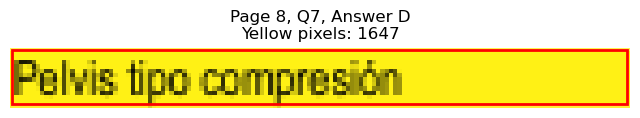

Page 8, Q7 - E: Detected box: x0=334.1, y0=641.8, x1=405.9, y1=654.5
Page 8, Q7, E: Yellow pixels: 122
Page 8, Q7, E: Total non-white pixels: 464
Page 8, Q7, E: Yellow percentage: 26.3%


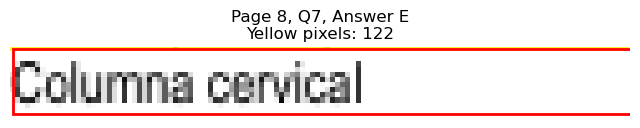


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=718.7, x1=201.4, y1=731.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 635
Page 8, Q8, A: Yellow percentage: 0.0%


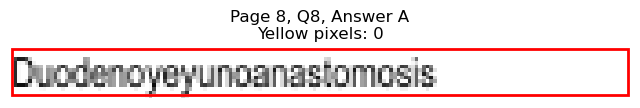

Page 8, Q8 - B: Detected box: x0=82.5, y0=731.4, x1=245.4, y1=744.0
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 798
Page 8, Q8, B: Yellow percentage: 0.0%


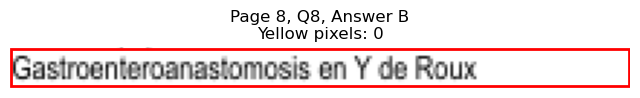

Page 8, Q8 - C: Detected box: x0=82.9, y0=744.9, x1=159.1, y1=757.6
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 407
Page 8, Q8, C: Yellow percentage: 0.0%


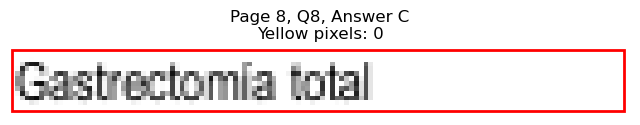

Page 8, Q8 - D: Detected box: x0=334.6, y0=718.8, x1=475.5, y1=731.4
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 717
Page 8, Q8, D: Yellow percentage: 0.0%


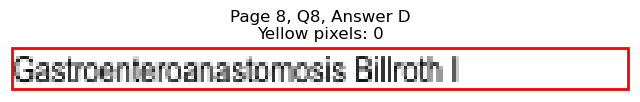

Page 8, Q8 - E: Detected box: x0=334.1, y0=732.2, x1=403.9, y1=744.9
Page 8, Q8, E: Yellow pixels: 1272
Page 8, Q8, E: Total non-white pixels: 1560
Page 8, Q8, E: Yellow percentage: 81.5%


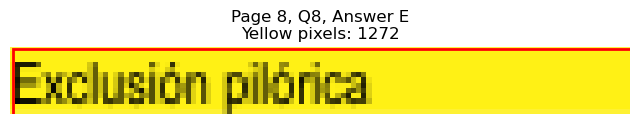


Page 8, Q8 - Selected Answer: E (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=127.1, y1=135.6
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 220
Page 9, Q1, A: Yellow percentage: 0.0%


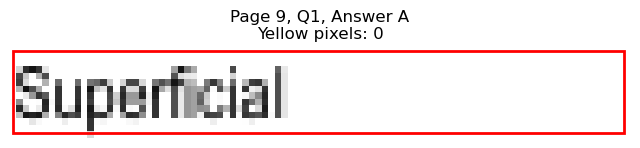

Page 9, Q1 - B: Detected box: x0=82.5, y0=135.6, x1=117.0, y1=148.3
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 165
Page 9, Q1, B: Yellow percentage: 0.0%


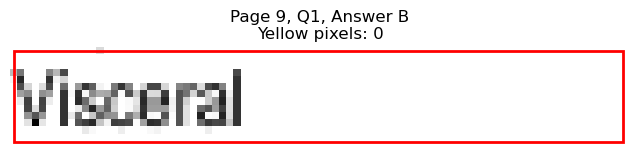

Page 9, Q1 - C: Detected box: x0=82.9, y0=149.3, x1=127.6, y1=162.0
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 220
Page 9, Q1, C: Yellow percentage: 0.0%


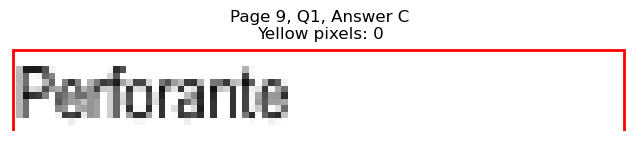

Page 9, Q1 - D: Detected box: x0=334.6, y0=123.0, x1=381.3, y1=135.7
Page 9, Q1, D: Yellow pixels: 1084
Page 9, Q1, D: Total non-white pixels: 1274
Page 9, Q1, D: Yellow percentage: 85.1%


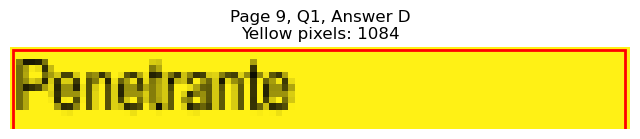

Page 9, Q1 - E: Detected box: x0=334.1, y0=136.6, x1=373.3, y1=149.2
Page 9, Q1, E: Yellow pixels: 90
Page 9, Q1, E: Total non-white pixels: 285
Page 9, Q1, E: Yellow percentage: 31.6%


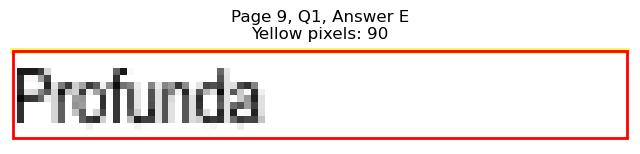


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=225.9, x1=196.3, y1=238.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 583
Page 9, Q2, A: Yellow percentage: 0.0%


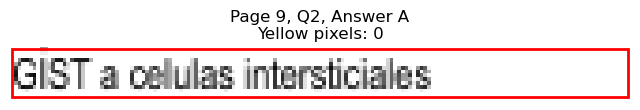

Page 9, Q2 - B: Detected box: x0=82.5, y0=238.7, x1=133.6, y1=251.4
Page 9, Q2, B: Yellow pixels: 1239
Page 9, Q2, B: Total non-white pixels: 1428
Page 9, Q2, B: Yellow percentage: 86.8%


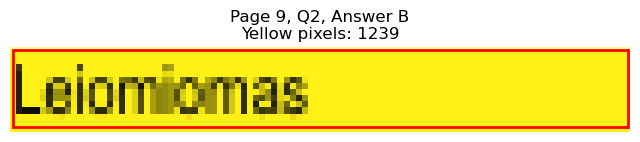

Page 9, Q2 - C: Detected box: x0=82.9, y0=252.3, x1=153.1, y1=264.9
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 361
Page 9, Q2, C: Yellow percentage: 0.0%


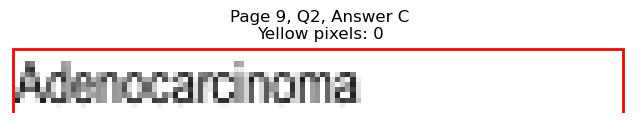

Page 9, Q2 - D: Detected box: x0=334.6, y0=226.0, x1=414.3, y1=238.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 420
Page 9, Q2, D: Yellow percentage: 0.0%


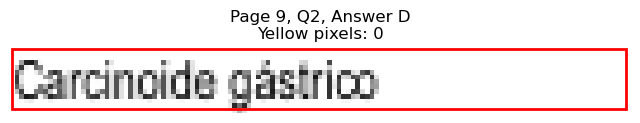

Page 9, Q2 - E: Detected box: x0=334.1, y0=239.5, x1=444.5, y1=252.2
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 565
Page 9, Q2, E: Yellow percentage: 0.0%


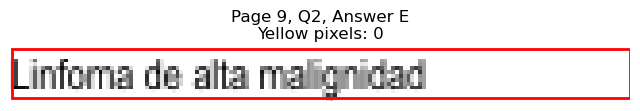


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.5, y0=303.6, x1=115.1, y1=316.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 176
Page 9, Q3, A: Yellow percentage: 0.0%


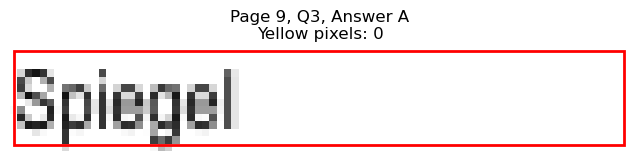

Page 9, Q3 - B: Detected box: x0=82.5, y0=316.4, x1=124.6, y1=329.0
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 206
Page 9, Q3, B: Yellow percentage: 0.0%


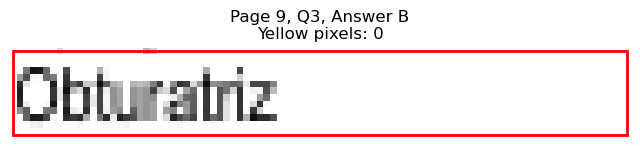

Page 9, Q3 - C: Detected box: x0=82.9, y0=330.0, x1=103.5, y1=342.7
Page 9, Q3, C: Yellow pixels: 848
Page 9, Q3, C: Total non-white pixels: 936
Page 9, Q3, C: Yellow percentage: 90.6%


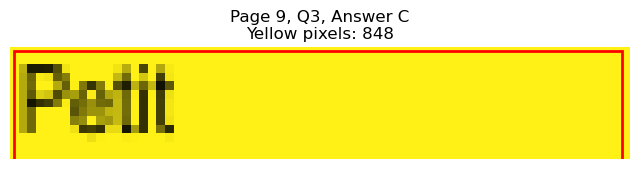

Page 9, Q3 - D: Detected box: x0=334.6, y0=303.8, x1=361.7, y1=316.4
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 134
Page 9, Q3, D: Yellow percentage: 0.0%


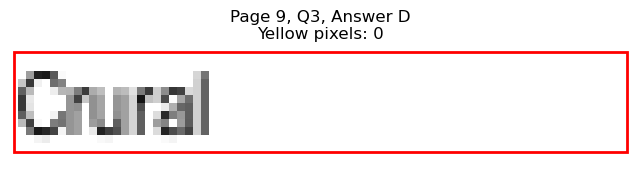

Page 9, Q3 - E: Detected box: x0=334.1, y0=317.3, x1=369.3, y1=330.0
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 194
Page 9, Q3, E: Yellow percentage: 0.0%


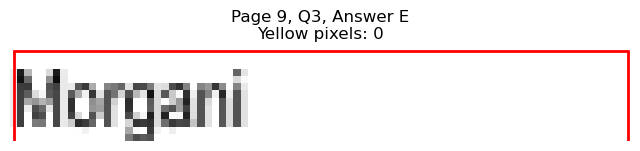


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=406.6, x1=229.0, y1=419.3
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 725
Page 9, Q4, A: Yellow percentage: 0.0%


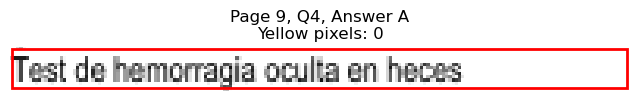

Page 9, Q4 - B: Detected box: x0=82.5, y0=419.3, x1=171.3, y1=432.0
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 467
Page 9, Q4, B: Yellow percentage: 0.0%


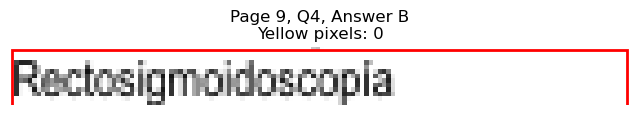

Page 9, Q4 - C: Detected box: x0=82.9, y0=433.0, x1=200.3, y1=445.7
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 607
Page 9, Q4, C: Yellow percentage: 0.0%


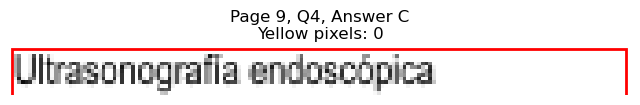

Page 9, Q4 - D: Detected box: x0=334.6, y0=406.7, x1=431.5, y1=419.4
Page 9, Q4, D: Yellow pixels: 1534
Page 9, Q4, D: Total non-white pixels: 2072
Page 9, Q4, D: Yellow percentage: 74.0%


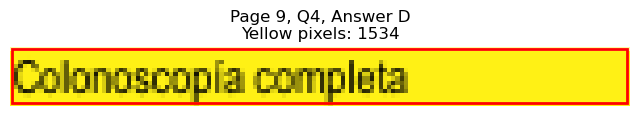

Page 9, Q4 - E: Detected box: x0=334.1, y0=420.3, x1=467.1, y1=432.9
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 817
Page 9, Q4, E: Yellow percentage: 0.0%


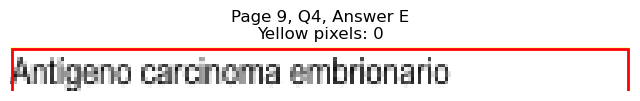


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=471.8, x1=117.6, y1=484.4
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 178
Page 9, Q5, A: Yellow percentage: 0.0%


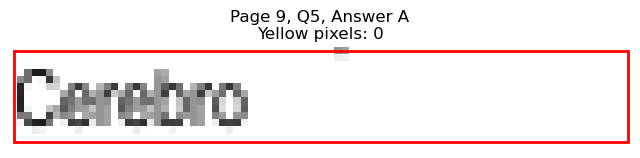

Page 9, Q5 - B: Detected box: x0=82.5, y0=484.5, x1=127.1, y1=497.2
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 228
Page 9, Q5, B: Yellow percentage: 0.0%


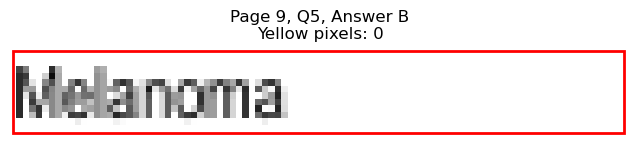

Page 9, Q5 - C: Detected box: x0=82.9, y0=498.2, x1=109.0, y1=510.8
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 119
Page 9, Q5, C: Yellow percentage: 0.0%


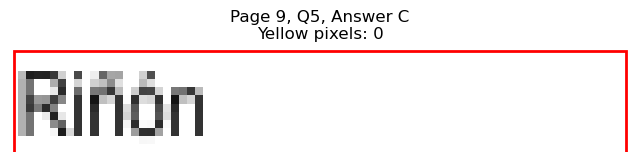

Page 9, Q5 - D: Detected box: x0=334.6, y0=471.9, x1=367.7, y1=484.6
Page 9, Q5, D: Yellow pixels: 974
Page 9, Q5, D: Total non-white pixels: 1176
Page 9, Q5, D: Yellow percentage: 82.8%


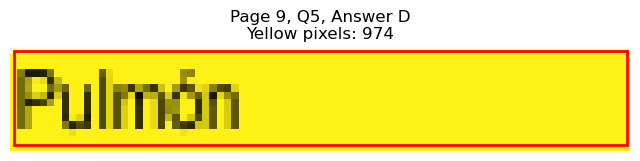

Page 9, Q5 - E: Detected box: x0=334.1, y0=485.3, x1=385.7, y1=498.0
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 371
Page 9, Q5, E: Yellow percentage: 0.0%


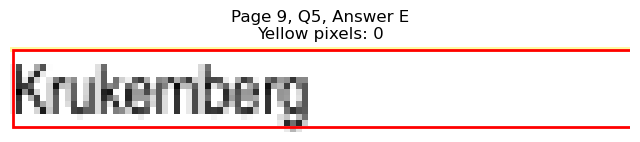


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=549.5, x1=135.1, y1=562.2
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 257
Page 9, Q6, A: Yellow percentage: 0.0%


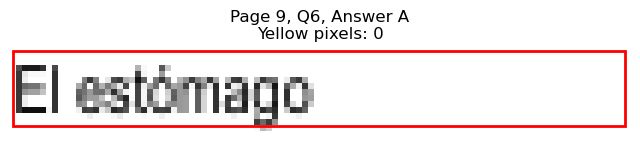

Page 9, Q6 - B: Detected box: x0=82.5, y0=562.3, x1=180.3, y1=574.9
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 464
Page 9, Q6, B: Yellow percentage: 0.0%


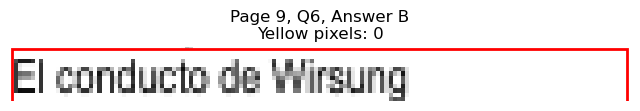

Page 9, Q6 - C: Detected box: x0=82.9, y0=575.8, x1=175.2, y1=588.5
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 461
Page 9, Q6, C: Yellow percentage: 0.0%


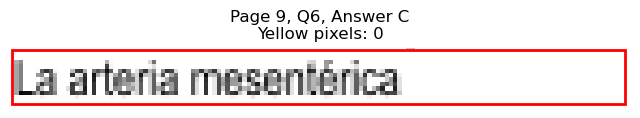

Page 9, Q6 - D: Detected box: x0=334.6, y0=549.7, x1=367.3, y1=562.3
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 145
Page 9, Q6, D: Yellow percentage: 0.0%


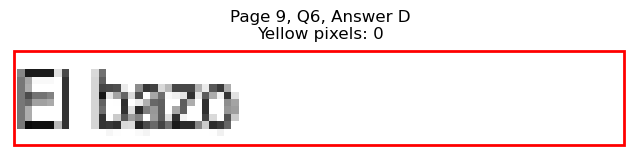

Page 9, Q6 - E: Detected box: x0=334.1, y0=563.1, x1=382.3, y1=575.8
Page 9, Q6, E: Yellow pixels: 1122
Page 9, Q6, E: Total non-white pixels: 1287
Page 9, Q6, E: Yellow percentage: 87.2%


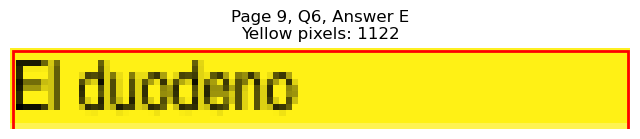


Page 9, Q6 - Selected Answer: E (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=614.6, x1=139.6, y1=627.2
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 290
Page 9, Q7, A: Yellow percentage: 0.0%


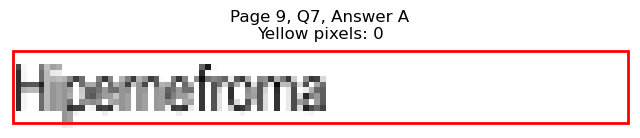

Page 9, Q7 - B: Detected box: x0=82.5, y0=627.3, x1=153.6, y1=640.0
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 386
Page 9, Q7, B: Yellow percentage: 0.0%


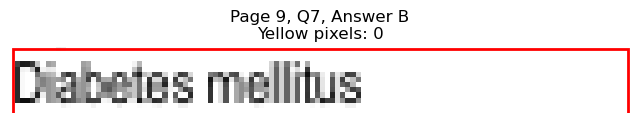

Page 9, Q7 - C: Detected box: x0=82.9, y0=641.0, x1=124.1, y1=653.6
Page 9, Q7, C: Yellow pixels: 1041
Page 9, Q7, C: Total non-white pixels: 1302
Page 9, Q7, C: Yellow percentage: 80.0%


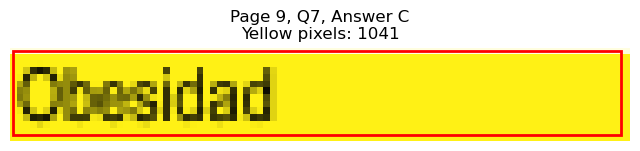

Page 9, Q7 - D: Detected box: x0=334.6, y0=614.7, x1=417.9, y1=627.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 444
Page 9, Q7, D: Yellow percentage: 0.0%


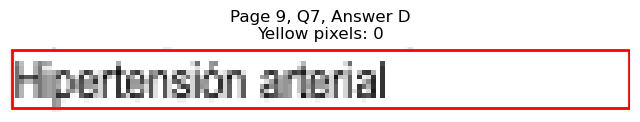

Page 9, Q7 - E: Detected box: x0=334.1, y0=628.3, x1=423.4, y1=640.9
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 455
Page 9, Q7, E: Yellow percentage: 0.0%


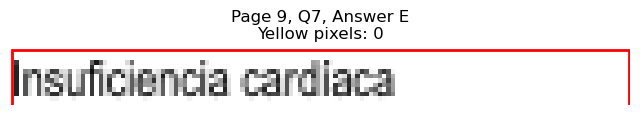


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.5, y0=717.6, x1=232.8, y1=730.2
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 773
Page 9, Q8, A: Yellow percentage: 0.0%


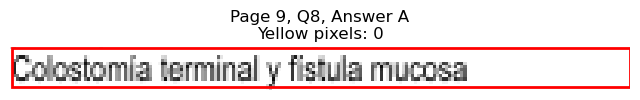

Page 9, Q8 - B: Detected box: x0=82.5, y0=730.4, x1=229.4, y1=743.1
Page 9, Q8, B: Yellow pixels: 2115
Page 9, Q8, B: Total non-white pixels: 2702
Page 9, Q8, B: Yellow percentage: 78.3%


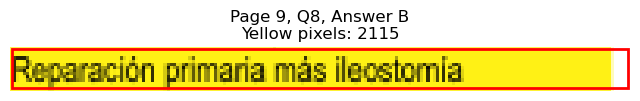

Page 9, Q8 - C: Detected box: x0=82.9, y0=744.0, x1=160.7, y1=756.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 378
Page 9, Q8, C: Yellow percentage: 0.0%


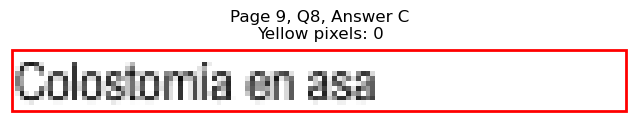

Page 9, Q8 - D: Detected box: x0=334.6, y0=717.7, x1=437.0, y1=730.4
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 525
Page 9, Q8, D: Yellow percentage: 0.0%


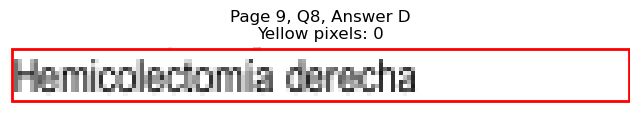

Page 9, Q8 - E: Detected box: x0=334.1, y0=731.3, x1=526.8, y1=743.9
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 964
Page 9, Q8, E: Yellow percentage: 0.0%


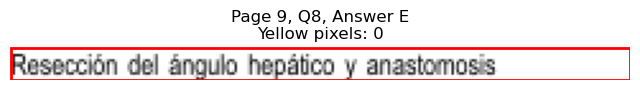


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=123.0, x1=238.4, y1=135.7
Page 10, Q1, A: Yellow pixels: 1862
Page 10, Q1, A: Total non-white pixels: 2509
Page 10, Q1, A: Yellow percentage: 74.2%


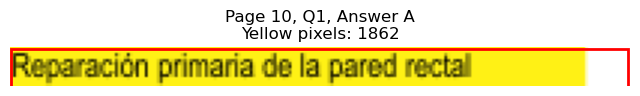

Page 10, Q1 - B: Detected box: x0=82.5, y0=136.7, x1=232.0, y1=149.4
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 767
Page 10, Q1, B: Yellow percentage: 0.0%


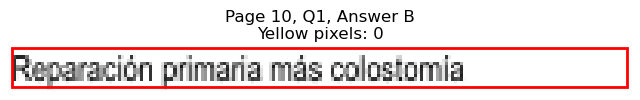

Page 10, Q1 - C: Detected box: x0=82.9, y0=267.9, x1=143.7, y1=280.5
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 297
Page 10, Q1, C: Yellow percentage: 0.0%


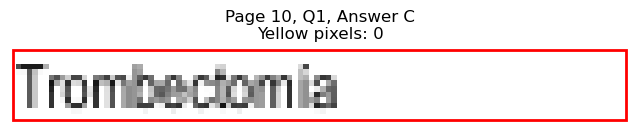

Page 10, Q1 - D: Detected box: x0=334.6, y0=123.0, x1=481.5, y1=135.7
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 765
Page 10, Q1, D: Yellow percentage: 0.0%


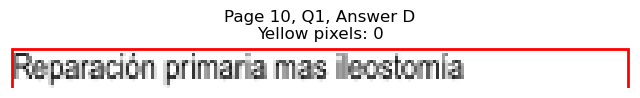

Page 10, Q1 - E: Detected box: x0=334.1, y0=136.6, x1=507.7, y1=149.2
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 865
Page 10, Q1, E: Yellow percentage: 0.0%


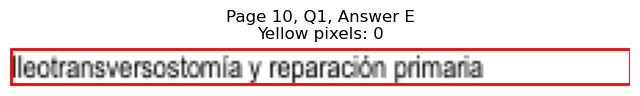


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=240.6, x1=159.1, y1=253.3
Page 10, Q2, A: Yellow pixels: 1505
Page 10, Q2, A: Total non-white pixels: 1792
Page 10, Q2, A: Yellow percentage: 84.0%


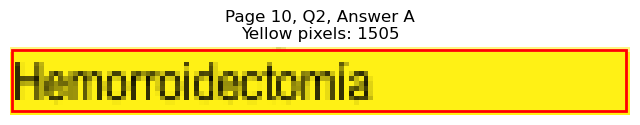

Page 10, Q2 - B: Detected box: x0=82.5, y0=254.3, x1=142.7, y1=267.0
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 314
Page 10, Q2, B: Yellow percentage: 0.0%


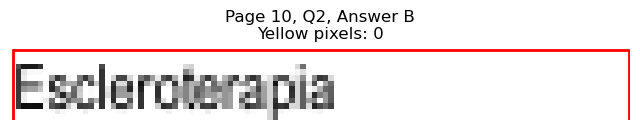

Page 10, Q2 - C: Detected box: x0=82.9, y0=370.8, x1=183.3, y1=383.5
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 533
Page 10, Q2, C: Yellow percentage: 0.0%


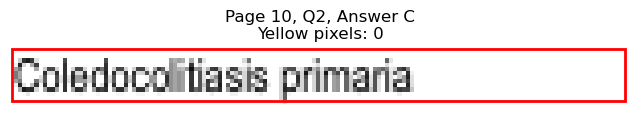

Page 10, Q2 - D: Detected box: x0=334.6, y0=240.6, x1=449.9, y1=253.3
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 574
Page 10, Q2, D: Yellow percentage: 0.0%


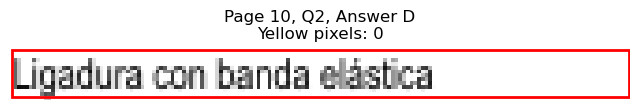

Page 10, Q2 - E: Detected box: x0=334.1, y0=254.2, x1=402.9, y1=266.8
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 345
Page 10, Q2, E: Yellow percentage: 0.0%


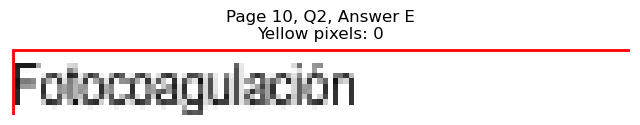


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=344.6, x1=181.7, y1=357.2
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 531
Page 10, Q3, A: Yellow percentage: 0.0%


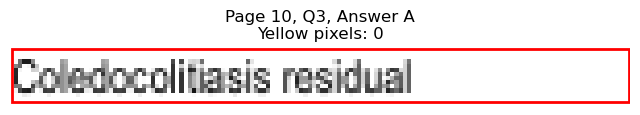

Page 10, Q3 - B: Detected box: x0=82.5, y0=357.3, x1=203.3, y1=369.9
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 643
Page 10, Q3, B: Yellow percentage: 0.0%


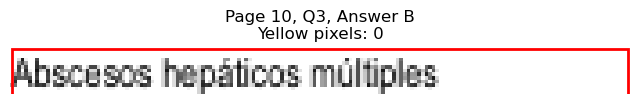

Page 10, Q3 - C: Detected box: x0=82.9, y0=436.0, x1=167.7, y1=448.7
Page 10, Q3, C: Yellow pixels: 1433
Page 10, Q3, C: Total non-white pixels: 1768
Page 10, Q3, C: Yellow percentage: 81.1%


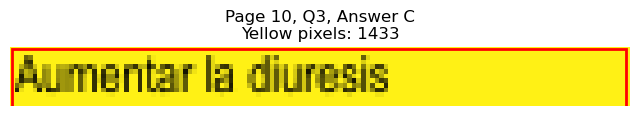

Page 10, Q3 - D: Detected box: x0=334.6, y0=344.7, x1=428.9, y1=357.3
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 517
Page 10, Q3, D: Yellow percentage: 0.0%


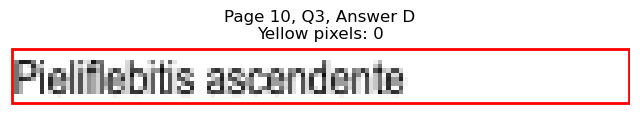

Page 10, Q3 - E: Detected box: x0=334.1, y0=358.1, x1=472.2, y1=370.8
Page 10, Q3, E: Yellow pixels: 1898
Page 10, Q3, E: Total non-white pixels: 2457
Page 10, Q3, E: Yellow percentage: 77.2%


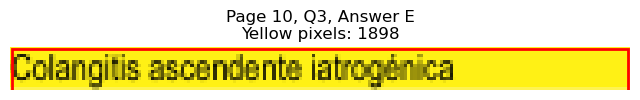


Page 10, Q3 - Selected Answer: E (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.5, y0=409.6, x1=202.4, y1=422.3
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 592
Page 10, Q4, A: Yellow percentage: 0.0%


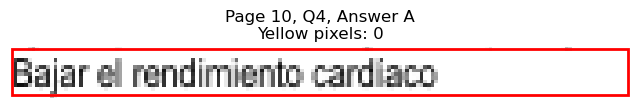

Page 10, Q4 - B: Detected box: x0=82.5, y0=422.3, x1=195.9, y1=435.0
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 537
Page 10, Q4, B: Yellow percentage: 0.0%


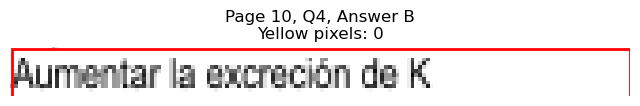

Page 10, Q4 - C: Detected box: x0=82.9, y0=513.8, x1=185.8, y1=526.4
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 526
Page 10, Q4, C: Yellow percentage: 0.0%


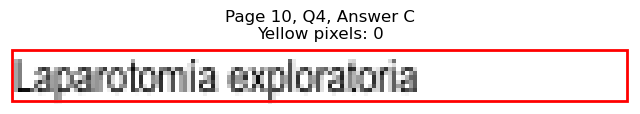

Page 10, Q4 - D: Detected box: x0=334.6, y0=409.7, x1=418.9, y1=422.4
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 430
Page 10, Q4, D: Yellow percentage: 0.0%


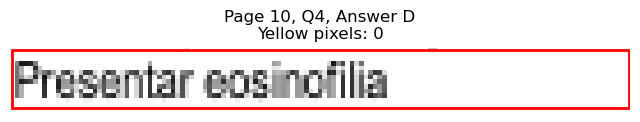

Page 10, Q4 - E: Detected box: x0=334.1, y0=423.3, x1=428.9, y1=435.9
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 490
Page 10, Q4, E: Yellow percentage: 0.0%


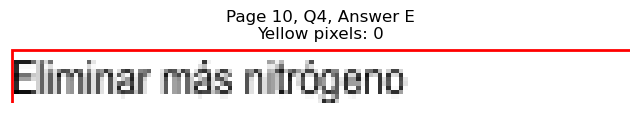

Page 10, Q5 - A: Detected box: x0=82.5, y0=487.4, x1=123.6, y1=500.0
Page 10, Q5, A: Yellow pixels: 92
Page 10, Q5, A: Total non-white pixels: 384
Page 10, Q5, A: Yellow percentage: 24.0%


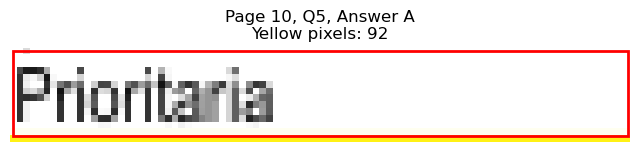

Page 10, Q5 - B: Detected box: x0=82.5, y0=500.1, x1=157.7, y1=512.8
Page 10, Q5, B: Yellow pixels: 1329
Page 10, Q5, B: Total non-white pixels: 1638
Page 10, Q5, B: Yellow percentage: 81.1%


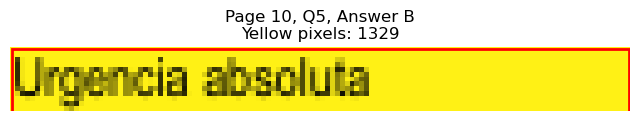

Page 10, Q5 - C: Detected box: x0=82.9, y0=591.5, x1=202.8, y1=604.2
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 614
Page 10, Q5, C: Yellow percentage: 0.0%


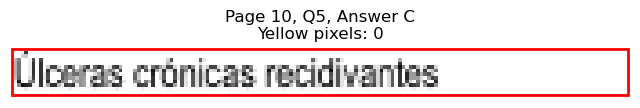

Page 10, Q5 - D: Detected box: x0=334.6, y0=487.5, x1=398.3, y1=500.2
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 338
Page 10, Q5, D: Yellow percentage: 0.0%


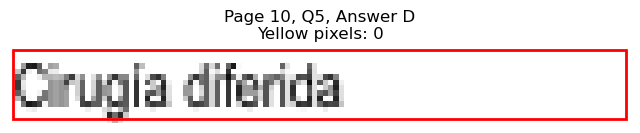

Page 10, Q5 - E: Detected box: x0=334.1, y0=501.1, x1=404.3, y1=513.7
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 360
Page 10, Q5, E: Yellow percentage: 0.0%


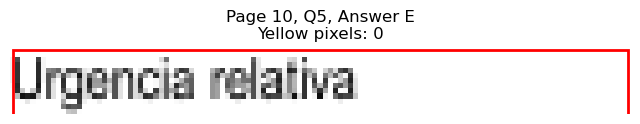


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=565.1, x1=195.3, y1=577.8
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 590
Page 10, Q6, A: Yellow percentage: 0.0%


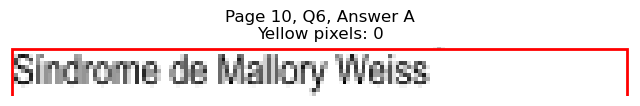

Page 10, Q6 - B: Detected box: x0=82.5, y0=577.9, x1=188.8, y1=590.5
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 562
Page 10, Q6, B: Yellow percentage: 0.0%


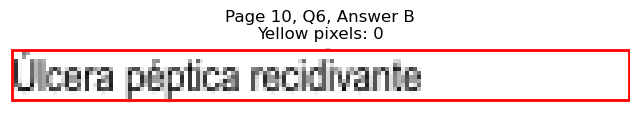

Page 10, Q6 - C: Detected box: x0=82.9, y0=681.8, x1=181.7, y1=694.5
Page 10, Q6, C: Yellow pixels: 1553
Page 10, Q6, C: Total non-white pixels: 2100
Page 10, Q6, C: Yellow percentage: 74.0%


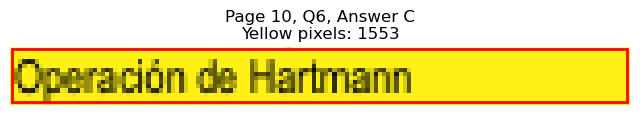

Page 10, Q6 - D: Detected box: x0=334.6, y0=565.3, x1=434.5, y1=577.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 527
Page 10, Q6, D: Yellow percentage: 0.0%


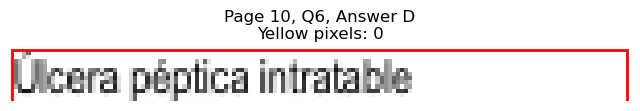

Page 10, Q6 - E: Detected box: x0=334.1, y0=578.7, x1=454.5, y1=591.4
Page 10, Q6, E: Yellow pixels: 1747
Page 10, Q6, E: Total non-white pixels: 2394
Page 10, Q6, E: Yellow percentage: 73.0%


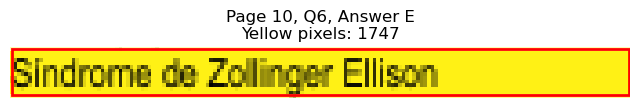


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=655.5, x1=182.8, y1=668.2
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 553
Page 10, Q7, A: Yellow percentage: 0.0%


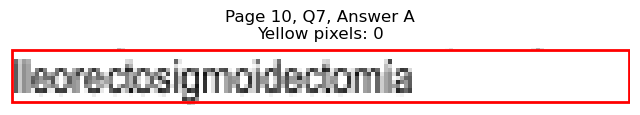

Page 10, Q7 - B: Detected box: x0=82.5, y0=668.3, x1=217.4, y1=680.9
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 695
Page 10, Q7, B: Yellow percentage: 0.0%


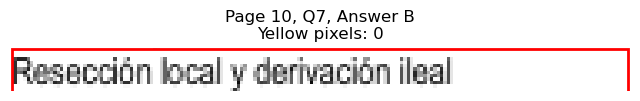

Page 10, Q7 - C: Detected box: x0=82.9, y0=747.0, x1=98.5, y1=759.6
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 76
Page 10, Q7, C: Yellow percentage: 0.0%


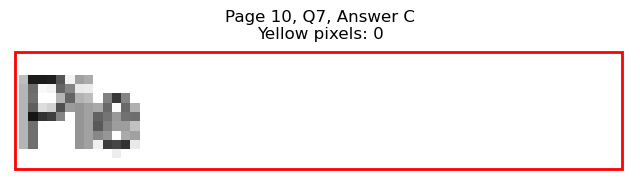

Page 10, Q7 - D: Detected box: x0=334.6, y0=655.7, x1=488.5, y1=668.3
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 728
Page 10, Q7, D: Yellow percentage: 0.0%


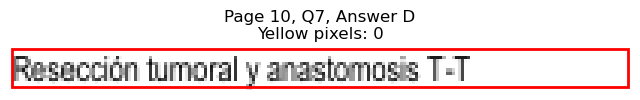

Page 10, Q7 - E: Detected box: x0=334.1, y0=669.1, x1=499.2, y1=681.8
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 811
Page 10, Q7, E: Yellow percentage: 0.0%


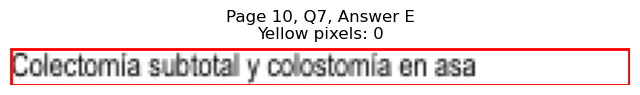

Page 10, Q8 - A: Detected box: x0=82.5, y0=720.6, x1=116.1, y1=733.2
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 163
Page 10, Q8, A: Yellow percentage: 0.0%


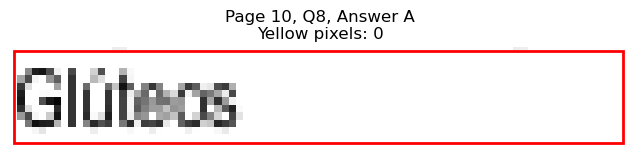

Page 10, Q8 - B: Detected box: x0=82.5, y0=733.4, x1=108.0, y1=746.1
Page 10, Q8, B: Yellow pixels: 988
Page 10, Q8, B: Total non-white pixels: 1078
Page 10, Q8, B: Yellow percentage: 91.7%


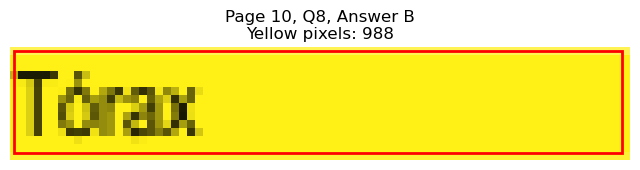

Page 10, Q8 - D: Detected box: x0=334.6, y0=720.7, x1=364.3, y1=733.4
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 155
Page 10, Q8, D: Yellow percentage: 0.0%


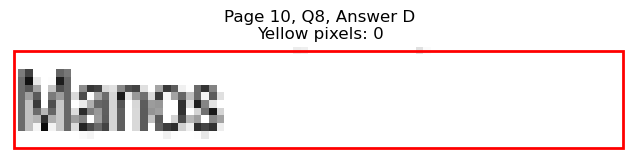

Page 10, Q8 - E: Detected box: x0=334.1, y0=734.2, x1=372.9, y1=746.9
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 207
Page 10, Q8, E: Yellow percentage: 0.0%


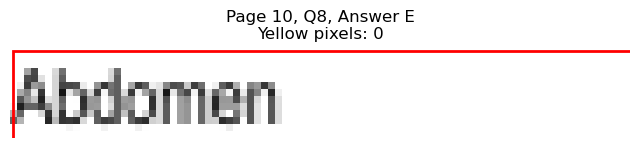


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=111.6, y1=135.6
Page 11, Q1, A: Yellow pixels: 80
Page 11, Q1, A: Total non-white pixels: 210
Page 11, Q1, A: Yellow percentage: 38.1%


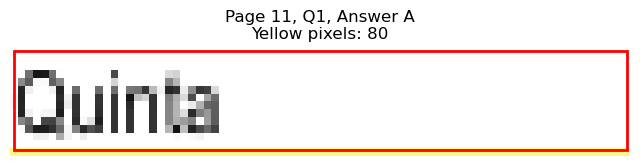

Page 11, Q1 - B: Detected box: x0=82.5, y0=135.6, x1=121.2, y1=148.3
Page 11, Q1, B: Yellow pixels: 1117
Page 11, Q1, B: Total non-white pixels: 1260
Page 11, Q1, B: Yellow percentage: 88.7%


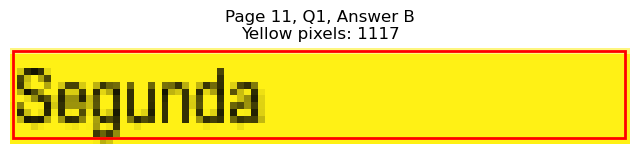

Page 11, Q1 - C: Detected box: x0=82.9, y0=149.3, x1=116.7, y1=162.0
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 156
Page 11, Q1, C: Yellow percentage: 0.0%


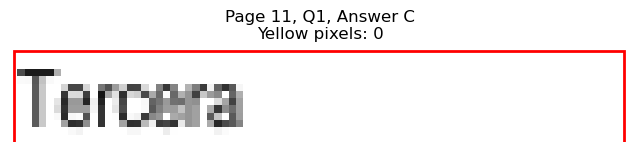

Page 11, Q1 - D: Detected box: x0=334.6, y0=123.0, x1=368.7, y1=135.7
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 164
Page 11, Q1, D: Yellow percentage: 0.0%


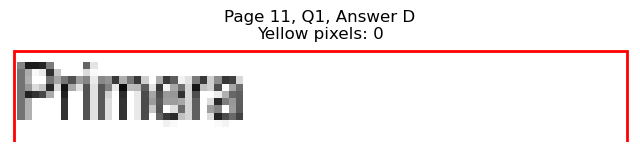

Page 11, Q1 - E: Detected box: x0=334.1, y0=136.6, x1=363.8, y1=149.2
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 147
Page 11, Q1, E: Yellow percentage: 0.0%


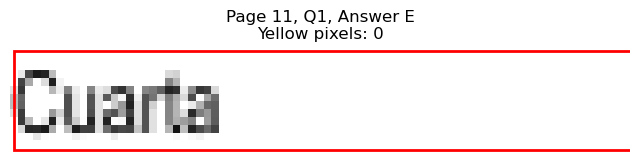


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=213.3, x1=180.3, y1=225.9
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 507
Page 11, Q2, A: Yellow percentage: 0.0%


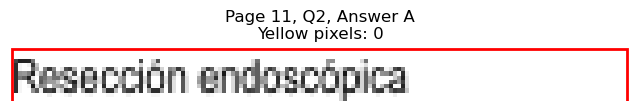

Page 11, Q2 - B: Detected box: x0=82.5, y0=226.0, x1=226.8, y1=238.6
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 752
Page 11, Q2, B: Yellow percentage: 0.0%


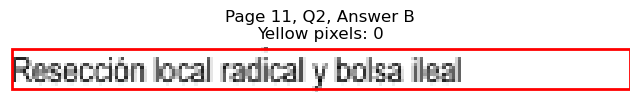

Page 11, Q2 - C: Detected box: x0=82.9, y0=239.7, x1=242.0, y1=252.3
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 802
Page 11, Q2, C: Yellow percentage: 0.0%


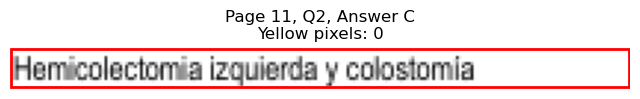

Page 11, Q2 - D: Detected box: x0=334.6, y0=213.4, x1=495.1, y1=226.0
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 775
Page 11, Q2, D: Yellow percentage: 0.0%


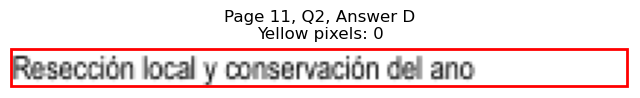

Page 11, Q2 - E: Detected box: x0=334.1, y0=226.9, x1=508.7, y1=239.6
Page 11, Q2, E: Yellow pixels: 1778
Page 11, Q2, E: Total non-white pixels: 2688
Page 11, Q2, E: Yellow percentage: 66.1%


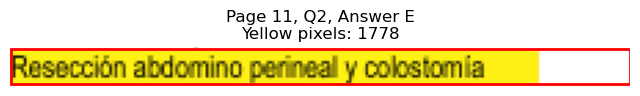


Page 11, Q2 - Selected Answer: E (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.5, y0=303.8, x1=156.7, y1=316.4
Page 11, Q3, A: Yellow pixels: 1338
Page 11, Q3, A: Total non-white pixels: 1750
Page 11, Q3, A: Yellow percentage: 76.5%


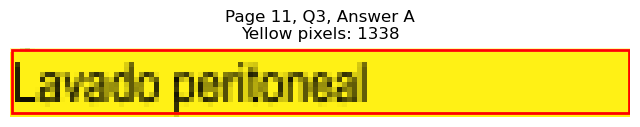

Page 11, Q3 - B: Detected box: x0=82.5, y0=317.4, x1=175.3, y1=330.1
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 473
Page 11, Q3, B: Yellow percentage: 0.0%


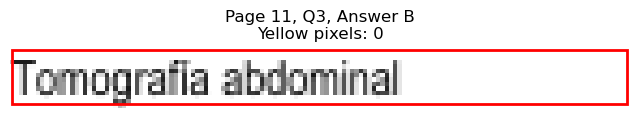

Page 11, Q3 - C: Detected box: x0=82.9, y0=331.0, x1=184.7, y1=343.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 536
Page 11, Q3, C: Yellow percentage: 0.0%


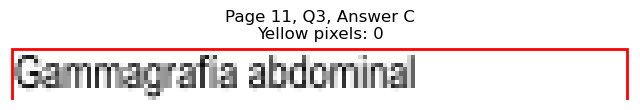

Page 11, Q3 - D: Detected box: x0=334.6, y0=303.8, x1=428.9, y1=316.4
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 487
Page 11, Q3, D: Yellow percentage: 0.0%


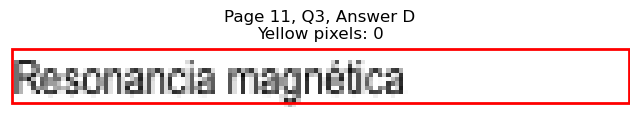

Page 11, Q3 - E: Detected box: x0=334.1, y0=317.3, x1=431.5, y1=330.0
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 461
Page 11, Q3, E: Yellow percentage: 0.0%


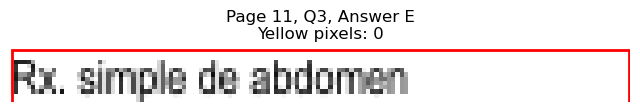


Page 11, Q3 - Selected Answer: A (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=395.0, x1=170.8, y1=407.6
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 442
Page 11, Q4, A: Yellow percentage: 0.0%


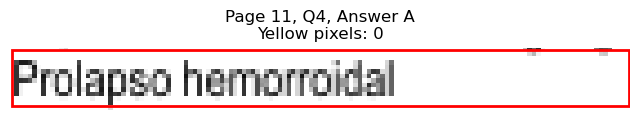

Page 11, Q4 - B: Detected box: x0=82.5, y0=407.8, x1=156.7, y1=420.5
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 387
Page 11, Q4, B: Yellow percentage: 0.0%


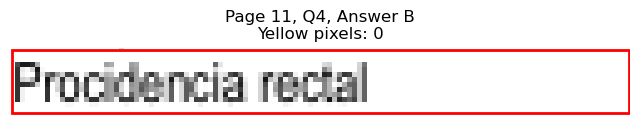

Page 11, Q4 - C: Detected box: x0=82.9, y0=421.4, x1=182.8, y1=434.0
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 501
Page 11, Q4, C: Yellow percentage: 0.0%


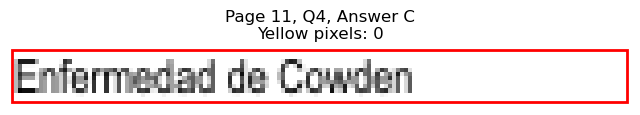

Page 11, Q4 - D: Detected box: x0=334.6, y0=395.1, x1=397.3, y1=407.7
Page 11, Q4, D: Yellow pixels: 1245
Page 11, Q4, D: Total non-white pixels: 1482
Page 11, Q4, D: Yellow percentage: 84.0%


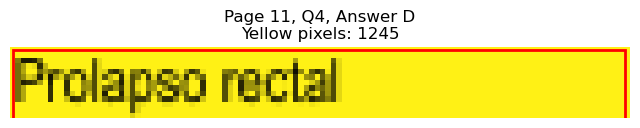

Page 11, Q4 - E: Detected box: x0=334.1, y0=408.6, x1=399.3, y1=421.3
Page 11, Q4, E: Yellow pixels: 116
Page 11, Q4, E: Total non-white pixels: 443
Page 11, Q4, E: Yellow percentage: 26.2%


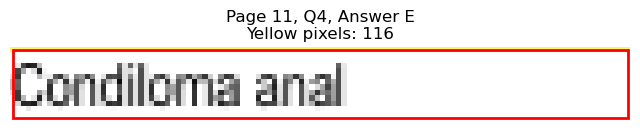


Page 11, Q4 - Selected Answer: D (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.5, y0=472.7, x1=151.7, y1=485.4
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 362
Page 11, Q5, A: Yellow percentage: 0.0%


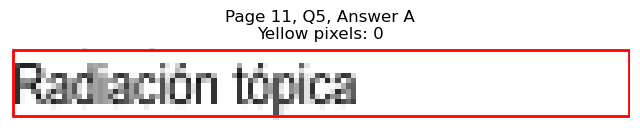

Page 11, Q5 - B: Detected box: x0=82.5, y0=485.5, x1=150.6, y1=498.1
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 333
Page 11, Q5, B: Yellow percentage: 0.0%


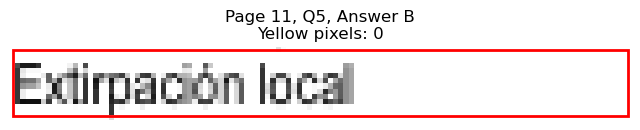

Page 11, Q5 - C: Detected box: x0=82.9, y0=499.1, x1=133.1, y1=511.8
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 254
Page 11, Q5, C: Yellow percentage: 0.0%


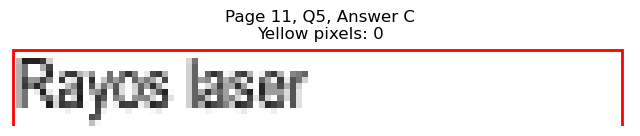

Page 11, Q5 - D: Detected box: x0=334.6, y0=472.9, x1=409.4, y1=485.5
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 395
Page 11, Q5, D: Yellow percentage: 0.0%


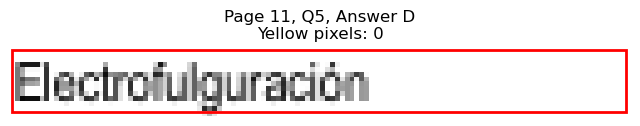

Page 11, Q5 - E: Detected box: x0=334.1, y0=486.4, x1=418.9, y1=499.1
Page 11, Q5, E: Yellow pixels: 1429
Page 11, Q5, E: Total non-white pixels: 1890
Page 11, Q5, E: Yellow percentage: 75.6%


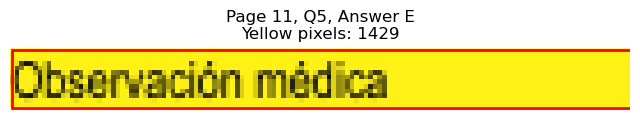


Page 11, Q5 - Selected Answer: E (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=550.5, x1=215.9, y1=563.2
Page 11, Q6, A: Yellow pixels: 184
Page 11, Q6, A: Total non-white pixels: 870
Page 11, Q6, A: Yellow percentage: 21.1%


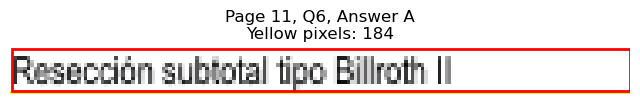

Page 11, Q6 - B: Detected box: x0=82.5, y0=563.2, x1=188.8, y1=575.9
Page 11, Q6, B: Yellow pixels: 1621
Page 11, Q6, B: Total non-white pixels: 2041
Page 11, Q6, B: Yellow percentage: 79.4%


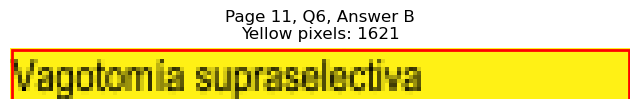

Page 11, Q6 - C: Detected box: x0=82.9, y0=576.9, x1=224.9, y1=589.6
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 725
Page 11, Q6, C: Yellow percentage: 0.0%


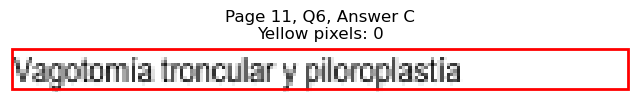

Page 11, Q6 - D: Detected box: x0=334.6, y0=550.6, x1=437.9, y1=563.3
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 520
Page 11, Q6, D: Yellow percentage: 0.0%


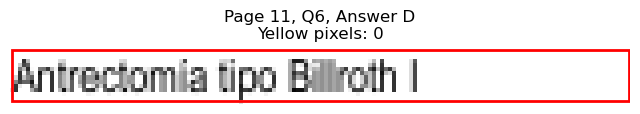

Page 11, Q6 - E: Detected box: x0=334.1, y0=564.1, x1=427.4, y1=576.7
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 451
Page 11, Q6, E: Yellow percentage: 0.0%


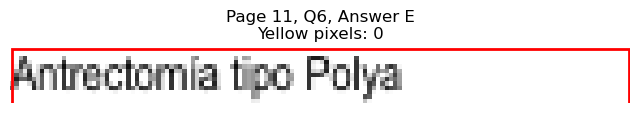


Page 11, Q6 - Selected Answer: B (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.5, y0=628.4, x1=268.0, y1=641.0
Page 11, Q7, A: Yellow pixels: 1985
Page 11, Q7, A: Total non-white pixels: 2702
Page 11, Q7, A: Yellow percentage: 73.5%


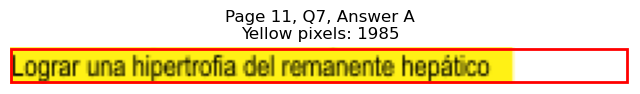

Page 11, Q7 - B: Detected box: x0=82.5, y0=641.9, x1=168.3, y1=654.6
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 423
Page 11, Q7, B: Yellow percentage: 0.0%


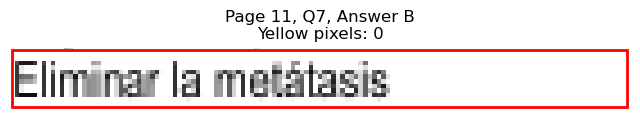

Page 11, Q7 - C: Detected box: x0=82.9, y0=655.7, x1=247.5, y1=668.3
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 832
Page 11, Q7, C: Yellow percentage: 0.0%


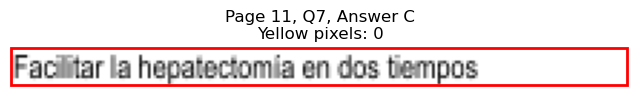

Page 11, Q7 - D: Detected box: x0=334.6, y0=628.4, x1=476.6, y1=641.0
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 740
Page 11, Q7, D: Yellow percentage: 0.0%


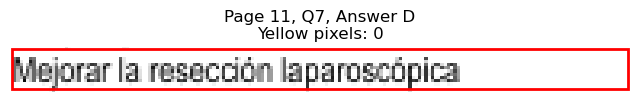

Page 11, Q7 - E: Detected box: x0=334.1, y0=641.8, x1=492.2, y1=654.5
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 841
Page 11, Q7, E: Yellow percentage: 0.0%


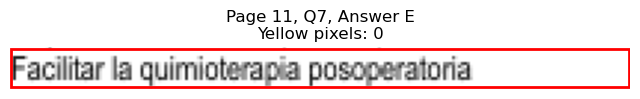


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.5, y0=694.5, x1=131.7, y1=707.2
Page 11, Q8, A: Yellow pixels: 1206
Page 11, Q8, A: Total non-white pixels: 1400
Page 11, Q8, A: Yellow percentage: 86.1%


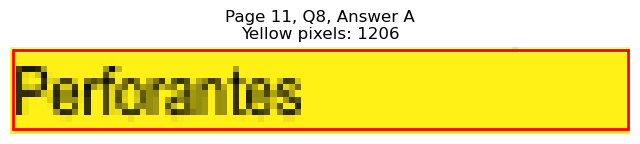

Page 11, Q8 - B: Detected box: x0=82.5, y0=708.1, x1=123.1, y1=720.8
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 199
Page 11, Q8, B: Yellow percentage: 0.0%


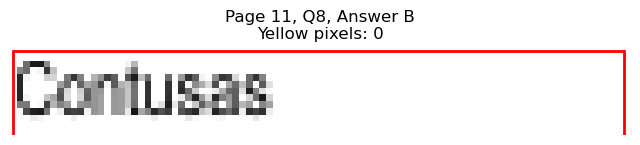

Page 11, Q8 - C: Detected box: x0=82.9, y0=721.8, x1=127.6, y1=734.4
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 224
Page 11, Q8, C: Yellow percentage: 0.0%


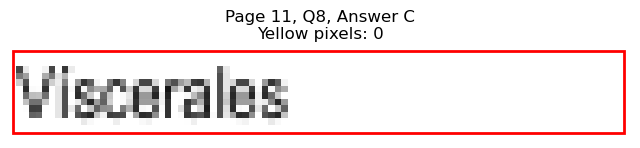

Page 11, Q8 - D: Detected box: x0=334.6, y0=694.5, x1=381.8, y1=707.2
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 240
Page 11, Q8, D: Yellow percentage: 0.0%


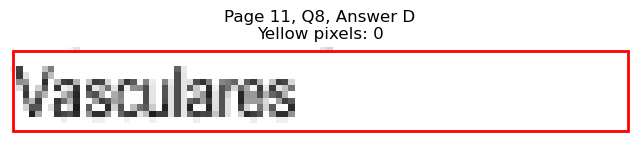

Page 11, Q8 - E: Detected box: x0=334.1, y0=708.0, x1=364.7, y1=720.6
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 147
Page 11, Q8, E: Yellow percentage: 0.0%


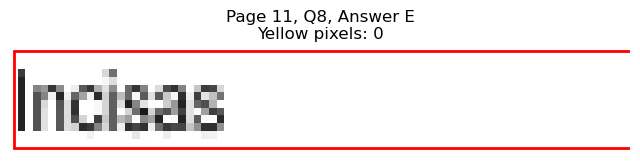


Page 11, Q8 - Selected Answer: A (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=224.8, y1=135.6
Page 12, Q1, A: Yellow pixels: 192
Page 12, Q1, A: Total non-white pixels: 909
Page 12, Q1, A: Yellow percentage: 21.1%


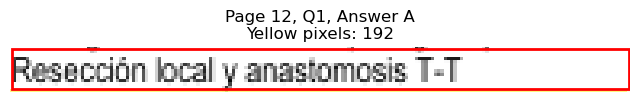

Page 12, Q1 - B: Detected box: x0=82.5, y0=135.6, x1=193.3, y1=148.3
Page 12, Q1, B: Yellow pixels: 1868
Page 12, Q1, B: Total non-white pixels: 2268
Page 12, Q1, B: Yellow percentage: 82.4%


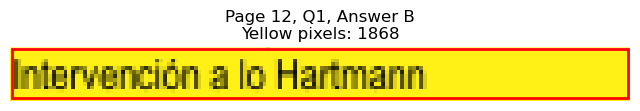

Page 12, Q1 - C: Detected box: x0=82.9, y0=149.3, x1=189.3, y1=162.0
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 550
Page 12, Q1, C: Yellow percentage: 0.0%


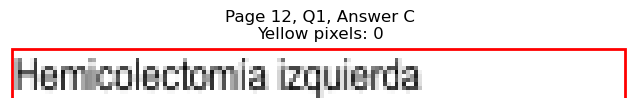

Page 12, Q1 - D: Detected box: x0=334.6, y0=123.0, x1=462.1, y1=135.7
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 613
Page 12, Q1, D: Yellow percentage: 0.0%


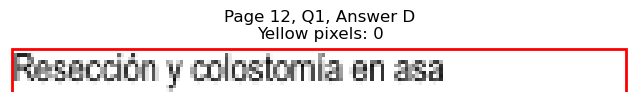

Page 12, Q1 - E: Detected box: x0=334.1, y0=136.6, x1=415.9, y1=149.2
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 422
Page 12, Q1, E: Yellow percentage: 0.0%


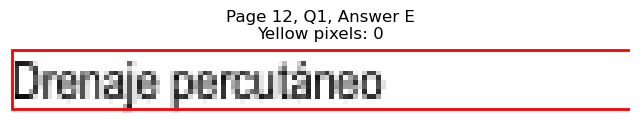


Page 12, Q1 - Selected Answer: B (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.5, y0=200.7, x1=168.3, y1=213.3
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 439
Page 12, Q2, A: Yellow percentage: 0.0%


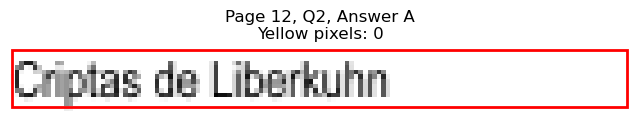

Page 12, Q2 - B: Detected box: x0=82.5, y0=213.4, x1=208.8, y1=226.0
Page 12, Q2, B: Yellow pixels: 0
Page 12, Q2, B: Total non-white pixels: 612
Page 12, Q2, B: Yellow percentage: 0.0%


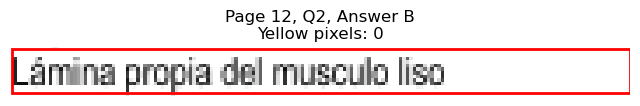

Page 12, Q2 - C: Detected box: x0=82.9, y0=227.1, x1=181.7, y1=239.7
Page 12, Q2, C: Yellow pixels: 1536
Page 12, Q2, C: Total non-white pixels: 1950
Page 12, Q2, C: Yellow percentage: 78.8%


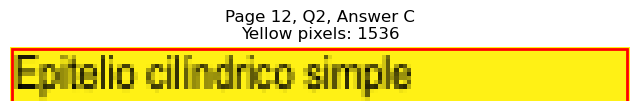

Page 12, Q2 - D: Detected box: x0=334.6, y0=200.8, x1=397.9, y1=213.4
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 304
Page 12, Q2, D: Yellow percentage: 0.0%


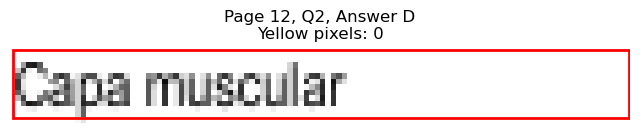

Page 12, Q2 - E: Detected box: x0=334.1, y0=214.3, x1=436.5, y1=227.0
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 510
Page 12, Q2, E: Yellow percentage: 0.0%


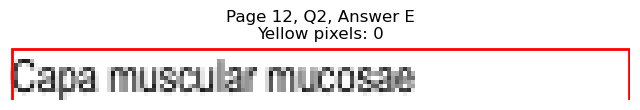


Page 12, Q2 - Selected Answer: C (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.5, y0=291.0, x1=137.7, y1=303.7
Page 12, Q3, A: Yellow pixels: 0
Page 12, Q3, A: Total non-white pixels: 280
Page 12, Q3, A: Yellow percentage: 0.0%


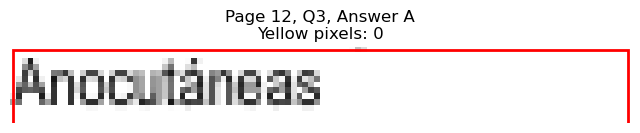

Page 12, Q3 - B: Detected box: x0=82.5, y0=303.8, x1=173.8, y1=316.4
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 444
Page 12, Q3, B: Yellow percentage: 0.0%


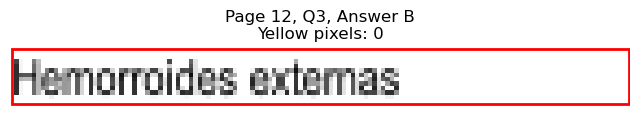

Page 12, Q3 - C: Detected box: x0=82.9, y0=317.4, x1=171.7, y1=330.1
Page 12, Q3, C: Yellow pixels: 1607
Page 12, Q3, C: Total non-white pixels: 1960
Page 12, Q3, C: Yellow percentage: 82.0%


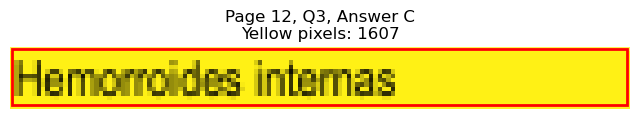

Page 12, Q3 - D: Detected box: x0=334.6, y0=291.2, x1=373.3, y1=303.8
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 173
Page 12, Q3, D: Yellow percentage: 0.0%


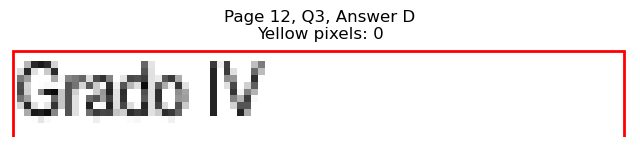

Page 12, Q3 - E: Detected box: x0=334.1, y0=304.7, x1=366.8, y1=317.4
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 151
Page 12, Q3, E: Yellow percentage: 0.0%


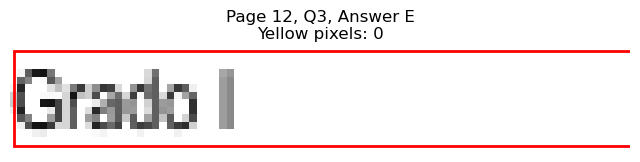


Page 12, Q3 - Selected Answer: C (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.5, y0=368.9, x1=177.3, y1=381.6
Page 12, Q4, A: Yellow pixels: 1530
Page 12, Q4, A: Total non-white pixels: 2044
Page 12, Q4, A: Yellow percentage: 74.9%


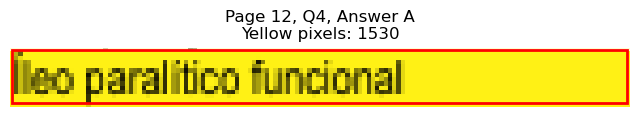

Page 12, Q4 - B: Detected box: x0=82.5, y0=382.5, x1=180.3, y1=395.1
Page 12, Q4, B: Yellow pixels: 0
Page 12, Q4, B: Total non-white pixels: 521
Page 12, Q4, B: Yellow percentage: 0.0%


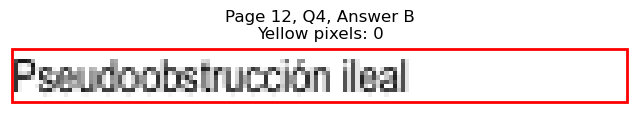

Page 12, Q4 - C: Detected box: x0=82.9, y0=396.2, x1=193.2, y1=408.8
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 571
Page 12, Q4, C: Yellow percentage: 0.0%


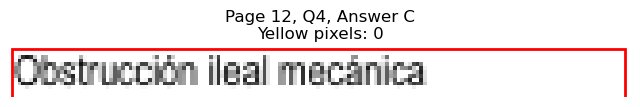

Page 12, Q4 - D: Detected box: x0=334.6, y0=368.9, x1=392.3, y1=381.6
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 311
Page 12, Q4, D: Yellow percentage: 0.0%


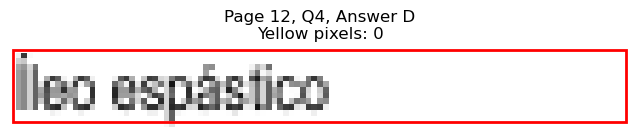

Page 12, Q4 - E: Detected box: x0=334.1, y0=382.4, x1=463.5, y1=395.0
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 664
Page 12, Q4, E: Yellow percentage: 0.0%


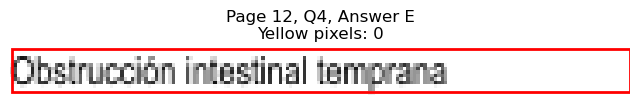


Page 12, Q4 - Selected Answer: A (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.5, y0=460.1, x1=212.4, y1=472.8
Page 12, Q5, A: Yellow pixels: 0
Page 12, Q5, A: Total non-white pixels: 633
Page 12, Q5, A: Yellow percentage: 0.0%


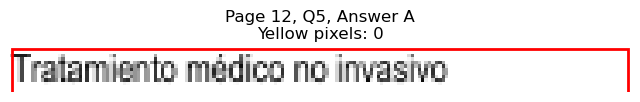

Page 12, Q5 - B: Detected box: x0=82.5, y0=472.9, x1=215.8, y1=485.5
Page 12, Q5, B: Yellow pixels: 0
Page 12, Q5, B: Total non-white pixels: 650
Page 12, Q5, B: Yellow percentage: 0.0%


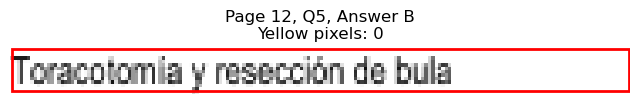

Page 12, Q5 - C: Detected box: x0=82.9, y0=486.5, x1=132.6, y1=499.2
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 263
Page 12, Q5, C: Yellow percentage: 0.0%


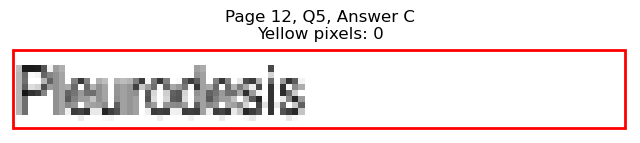

Page 12, Q5 - D: Detected box: x0=334.6, y0=460.3, x1=446.0, y1=472.9
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 572
Page 12, Q5, D: Yellow percentage: 0.0%


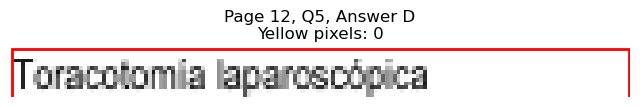

Page 12, Q5 - E: Detected box: x0=334.1, y0=473.8, x1=470.0, y1=486.5
Page 12, Q5, E: Yellow pixels: 1943
Page 12, Q5, E: Total non-white pixels: 2618
Page 12, Q5, E: Yellow percentage: 74.2%


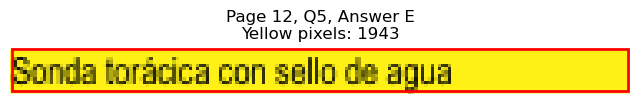


Page 12, Q5 - Selected Answer: E (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=82.5, y0=538.0, x1=207.4, y1=550.7
Page 12, Q6, A: Yellow pixels: 1815
Page 12, Q6, A: Total non-white pixels: 2288
Page 12, Q6, A: Yellow percentage: 79.3%


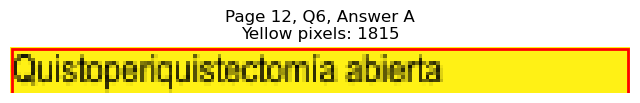

Page 12, Q6 - B: Detected box: x0=82.5, y0=551.6, x1=173.8, y1=564.2
Page 12, Q6, B: Yellow pixels: 0
Page 12, Q6, B: Total non-white pixels: 484
Page 12, Q6, B: Yellow percentage: 0.0%


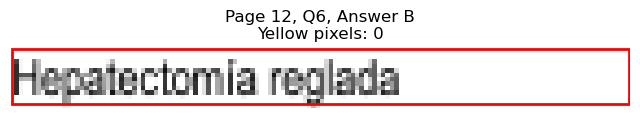

Page 12, Q6 - C: Detected box: x0=82.9, y0=565.3, x1=152.7, y1=577.9
Page 12, Q6, C: Yellow pixels: 0
Page 12, Q6, C: Total non-white pixels: 380
Page 12, Q6, C: Yellow percentage: 0.0%


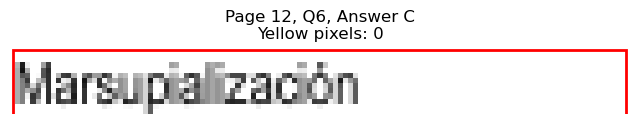

Page 12, Q6 - D: Detected box: x0=334.6, y0=538.0, x1=433.4, y1=550.7
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 503
Page 12, Q6, D: Yellow percentage: 0.0%


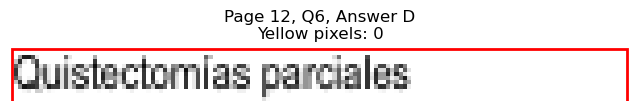

Page 12, Q6 - E: Detected box: x0=334.1, y0=551.5, x1=418.9, y1=564.1
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 460
Page 12, Q6, E: Yellow percentage: 0.0%


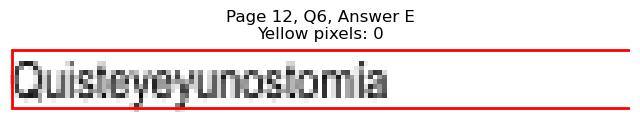


Page 12, Q6 - Selected Answer: A (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=82.5, y0=629.2, x1=191.8, y1=641.9
Page 12, Q7, A: Yellow pixels: 0
Page 12, Q7, A: Total non-white pixels: 542
Page 12, Q7, A: Yellow percentage: 0.0%


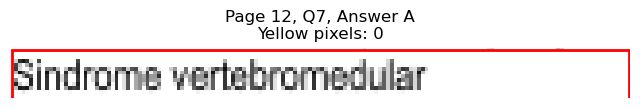

Page 12, Q7 - B: Detected box: x0=82.5, y0=641.9, x1=218.3, y1=654.6
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 658
Page 12, Q7, B: Yellow percentage: 0.0%


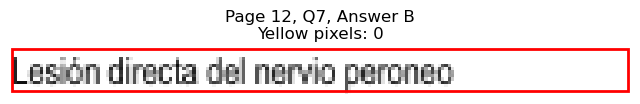

Page 12, Q7 - C: Detected box: x0=82.9, y0=655.7, x1=235.0, y1=668.3
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 742
Page 12, Q7, C: Yellow percentage: 0.0%


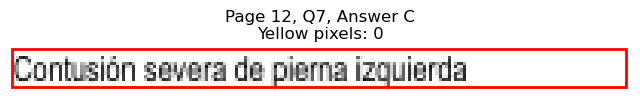

Page 12, Q7 - D: Detected box: x0=334.6, y0=629.3, x1=487.5, y1=642.0
Page 12, Q7, D: Yellow pixels: 2126
Page 12, Q7, D: Total non-white pixels: 2688
Page 12, Q7, D: Yellow percentage: 79.1%


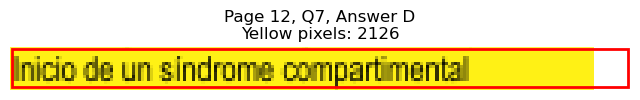

Page 12, Q7 - E: Detected box: x0=334.1, y0=642.9, x1=472.2, y1=655.6
Page 12, Q7, E: Yellow pixels: 189
Page 12, Q7, E: Total non-white pixels: 823
Page 12, Q7, E: Yellow percentage: 23.0%


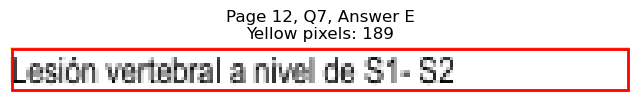


Page 12, Q7 - Selected Answer: D (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=82.5, y0=719.6, x1=190.3, y1=732.3
Page 12, Q8, A: Yellow pixels: 0
Page 12, Q8, A: Total non-white pixels: 580
Page 12, Q8, A: Yellow percentage: 0.0%


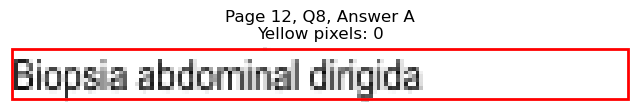

Page 12, Q8 - B: Detected box: x0=82.5, y0=732.3, x1=267.6, y1=745.0
Page 12, Q8, B: Yellow pixels: 0
Page 12, Q8, B: Total non-white pixels: 947
Page 12, Q8, B: Yellow percentage: 0.0%


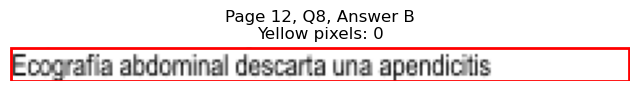

Page 12, Q8 - C: Detected box: x0=82.9, y0=746.0, x1=215.0, y1=758.7
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 667
Page 12, Q8, C: Yellow percentage: 0.0%


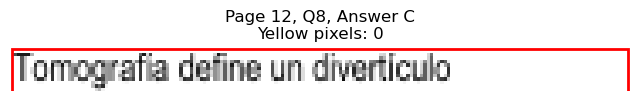

Page 12, Q8 - D: Detected box: x0=334.6, y0=719.7, x1=498.2, y1=732.4
Page 12, Q8, D: Yellow pixels: 0
Page 12, Q8, D: Total non-white pixels: 815
Page 12, Q8, D: Yellow percentage: 0.0%


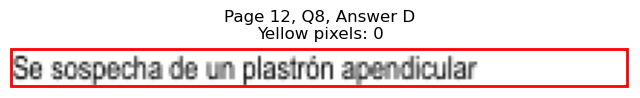

Page 12, Q8 - E: Detected box: x0=334.1, y0=733.3, x1=518.1, y1=746.0
Page 12, Q8, E: Yellow pixels: 1773
Page 12, Q8, E: Total non-white pixels: 2496
Page 12, Q8, E: Yellow percentage: 71.0%


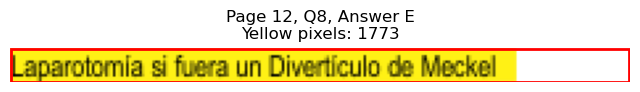


Page 12, Q8 - Selected Answer: E (based on yellow pixel count)





Page 13: Found 1 questions
Page 13, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=147.6, y1=123.0
Page 13, Q1, A: Yellow pixels: 0
Page 13, Q1, A: Total non-white pixels: 350
Page 13, Q1, A: Yellow percentage: 0.0%


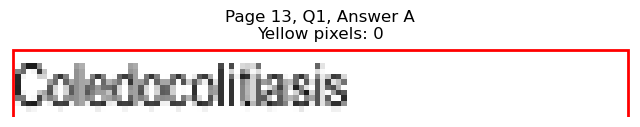

Page 13, Q1 - B: Detected box: x0=82.5, y0=123.0, x1=173.8, y1=135.7
Page 13, Q1, B: Yellow pixels: 0
Page 13, Q1, B: Total non-white pixels: 488
Page 13, Q1, B: Yellow percentage: 0.0%


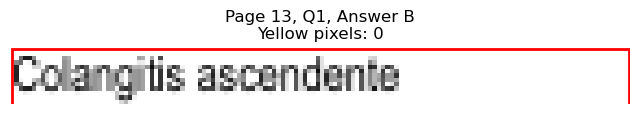

Page 13, Q1 - C: Detected box: x0=82.9, y0=136.7, x1=160.2, y1=149.4
Page 13, Q1, C: Yellow pixels: 0
Page 13, Q1, C: Total non-white pixels: 406
Page 13, Q1, C: Yellow percentage: 0.0%


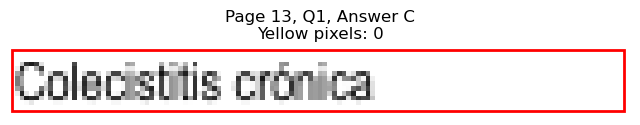

Page 13, Q1 - D: Detected box: x0=334.6, y0=110.4, x1=397.3, y1=123.1
Page 13, Q1, D: Yellow pixels: 0
Page 13, Q1, D: Total non-white pixels: 337
Page 13, Q1, D: Yellow percentage: 0.0%


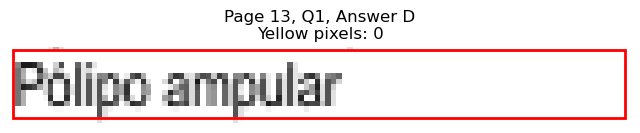

Page 13, Q1 - E: Detected box: x0=334.1, y0=124.1, x1=422.9, y1=136.8
Page 13, Q1, E: Yellow pixels: 1473
Page 13, Q1, E: Total non-white pixels: 1807
Page 13, Q1, E: Yellow percentage: 81.5%


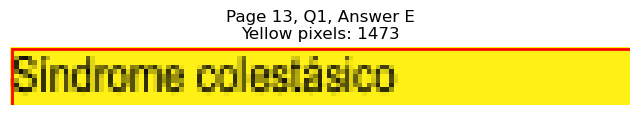


Page 13, Q1 - Selected Answer: E (based on yellow pixel count)





⚠️ The following questions were skipped due to missing options:
Page 10, Q8


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 50 años, procedente de los andes, ing...
1   ¿Cuál es la indicación absoluta para una lapar...
2   Varón de 25 años, ingresa a emergencia por pre...
3   Varón de 30 años, tratado hasta en dos oportun...
4   En relación a la vascularización del recto, Se...
..                                                ...
95  Paciente joven, de contextura delgada, que esp...
96  Ante la presencia de un quiste parasitario tip...
97  Varón de 30 años sufre accidente de tránsito c...
98  Varón de 20 años, presenta dolor en fosa iliac...
99  Mujer de 30 años, presenta cólico intenso en h...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                     Diverticulitis de sigma   
1                           Herida penetrante   
2                    Laparotomía exploratoria   
3                                     Yeyunal   
4   Hemorroidal media nace directamente de la   
..                                        ...   
95             Tratamiento médico no invasivo   
96             Quistoperiquistectomía abierta   
97                   Sindrome vertebromedular   
98                 Biopsia abdominal dirigida   
99                           Coledocolitiasis   

                                        option_B  \
0                               Vólvulo gástrico   
1                              Shock hemorrágico   
2               Continuar con observación médica   
3                                    Apendicular   
4          La mesentérica superior termina en la   
..                                           ...   
95               Toracotomía y resección de bula   
96                          Hepatectomía reglada   
97             Lesión directa del nervio peroneo   
98  Ecografía abdominal descarta una apendicitis   
99                         Colangitis ascendente   

                                          option_C  \
0                              Obstrucción yeyunal   
1            Herida por proyectil de arma de fuego   
2                      Repetir exámenes auxiliares   
3                                          Vesical   
4   Hemorroidal superior es rama de la mesentérica   
..                                             ...   
95                                     Pleurodesis   
96                                Marsupialización   
97            Contusión severa de pierna izquierda   
98                Tomografía define un divertículo   
99                            Colecistitis crónica   

                                       option_D  \
0                          Vólvulo de sigmoides   
1                          Plastrón apendicular   
2              Iniciar antibióticos rápidamente   
3                                         Colon   
4   Hemorroidal inferior es rama de mesentérica   
..                                          ...   
95                    Toracotomía laparoscópica   
96                      Quistectomías parciales   
97         Inicio de un síndrome compartimental   
98       Se sospecha de un plastrón apendicular   
99                               Pólipo ampular   

                                         option_E  
0                            Intususcepción ileal  
1                         Eventración encarcerada  
2                Repetir tomografía computarizada  
3                                        Gástrica  
4    Mesentérica superior nace en la iliaca común  
..                                            ...  
95               Sonda torácica con sello de agua  
96                             Quisteyeyunostomía  
97             Lesión vertebral a nivel de S1- S2  
98  Laparotomía si fuera un Divertículo de Meckel  
99                           Síndrome colestásico  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Varón de 50 años, procedente de los andes, ing...   
1   ¿Cuál es la indicación absoluta para una lapar...   
2   Varón de 25 años, ingresa a emergencia por pre...   
3   Varón de 30 años, tratado hasta en dos oportun...   
4   En relación a la vascularización del recto, Se...   
..                                                ...   
95  Paciente joven, de contextura delgada, que esp...   
96  Ante la presencia de un quiste parasitario tip...   
97  Varón de 30 años sufre accidente de tránsito c...   
98  Varón de 20 años, presenta dolor en fosa iliac...   
99  Mujer de 30 años, presenta cólico intenso en h...   

                                     option_A  \
0                     Diverticulitis de sigma   
1                           Herida penetrante   
2                    Laparotomía exploratoria   
3                                     Yeyunal   
4   Hemorroidal media nace directamente de la   
..                                        ...   
95             Tratamiento médico no invasivo   
96             Quistoperiquistectomía abierta   
97                   Sindrome vertebromedular   
98                 Biopsia abdominal dirigida   
99                           Coledocolitiasis   

                                        option_B  \
0                               Vólvulo gástrico   
1                              Shock hemorrágico   
2               Continuar con observación médica   
3                                    Apendicular   
4          La mesentérica superior termina en la   
..                                           ...   
95               Toracotomía y resección de bula   
96                          Hepatectomía reglada   
97             Lesión directa del nervio peroneo   
98  Ecografía abdominal descarta una apendicitis   
99                         Colangitis ascendente   

                                          option_C  \
0                              Obstrucción yeyunal   
1            Herida por proyectil de arma de fuego   
2                      Repetir exámenes auxiliares   
3                                          Vesical   
4   Hemorroidal superior es rama de la mesentérica   
..                                             ...   
95                                     Pleurodesis   
96                                Marsupialización   
97            Contusión severa de pierna izquierda   
98                Tomografía define un divertículo   
99                            Colecistitis crónica   

                                       option_D  \
0                          Vólvulo de sigmoides   
1                          Plastrón apendicular   
2              Iniciar antibióticos rápidamente   
3                                         Colon   
4   Hemorroidal inferior es rama de mesentérica   
..                                          ...   
95                    Toracotomía laparoscópica   
96                      Quistectomías parciales   
97         Inicio de un síndrome compartimental   
98       Se sospecha de un plastrón apendicular   
99                               Pólipo ampular   

                                         option_E correct_answer  
0                            Intususcepción ileal              D  
1                         Eventración encarcerada              B  
2                Repetir tomografía computarizada              A  
3                                        Gástrica              E  
4    Mesentérica superior nace en la iliaca común              C  
..                                            ...            ...  
95               Sonda torácica con sello de agua              E  
96                             Quisteyeyunostomía              A  
97             Lesión vertebral a nivel de S1- S2              D  
98  Laparotomía si fuera un Divertículo de Meckel              E  
99                           Síndrome colestásico              E  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/CIRUGIA GENERAL.csv
